# Interpreting forces of 5 charged particles with FISGAE

This self-contained notebook generates a dataset of an interacting system, trains a model to learn to predict its trajectories, and extracts the interaction forces.

The dataset consist of 5 charged particles interacting inside a reflective square with 2 types of interaction: repulsion and attraction.
We use PyG dataloaders with implicit batching.

The FISGAE model is a simplified and optimized version from dynamic neural relation inference (dNRI) paper's code. The model learns the physics of the bulk and is able to predict further in time. The loss ignores the reflections from the border by considering only an interior defined by R=0.8. Otherwise, the reflection will dominate the loss.

The training has a warm-up phase and the Gumbel temperature is decreased.

The model unsupervisedly classifies types of interactions based on the full trajectory. We add a final linear layer to the building block MLP and a learnable super-Gaussian cutoff function to mask long distance interactions.

The model is crafted for interpretability, i.e., the edge functions allow extracting the functional form of the forces. We design the edge function to predict directly the force.

# Setup

In [ ]:
import os, matplotlib.pyplot as plt, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange

In the following dict, we set the options of the dataset and the model.

In [ ]:
params = {
    # Data args
 'data_seed': 1, # data loader
 'data_path': '../data/raw/synth_charged_5_10k/',
 'batch_size': 16,
 'val_batch_size': 16,
 'use_data_norm': True,
 'sparse': False, # allow sparse computation of the graph?
    # Model args
 'model_seed': 1,
 'working_dir': '../results/synth_charged_5_10k/dnri/seed_1/',
 'gpu': torch.cuda.is_available(),
 'pred_delta': False, # False: pred = feat[:,:-1]+output
 'mode': 'train',
 'num_vars' : 5, # num objects/particles
 'input_node_size' : 2, # input node features: velocities
 'n_bound':0,           #+ boundaries
 'input_edge_size' : 3, # input edge features: d, versor
 'output_size' : 4,  # position x,y, velocity v_x,v_y
 'input_time_steps' : 50,
    # encoder
 'encoder_hidden': 256,
 'encoder_bn': False,  # better without unless overfitting
 'encoder_mlp_hidden': 128,
 'encoder_mlp_num_layers': 3,
 'encoder_rnn_type': 'lstm',
 'encoder_rnn_hidden': 64,
 'encoder_rnn_num_layers': 1,
 'encoder_dropout': 0.0,
 'prior_num_layers': 3,
 'prior_hidden_size': 128,
 'static': True, # use static prior: one edge type for all times
 'use_supergaussian': False, # to mask out long range interactions that are not
    # decoder
 'num_edge_types': 2, # Interaction types: Attraction, repulsion
 'skip_first': False, # Thus, no need of superGaussian cutoff
 'decoder_type': 'ref_mlp',
 'decoder_hidden': 256,
 'decoder_msg_hidden': 256,
 'decoder_hidden_out': 1, #<-----Scalar message prior to mean Force magnitude with sign
 'decoder_dropout': 0.0,
    # Loss args
 'nll_loss_type' : 'gaussian',
 'prior_variance': 5e-05,
 'normalize_kl': True,
 'normalize_kl_per_var': False,
 'normalize_nll': True,
 'normalize_nll_per_var': False,
 'kl_coef': 1.0,
 'add_uniform_prior': False,  # False = only add learned prior
 'no_edge_prior': 0.9,
    # Train args
 'gumbel_temp': 1.5,
 'continue_training': False,
 'num_epochs': 100, #200,
 'lr': 0.0005,
 'lr_decay_factor': 0.5,
 'lr_decay_steps': 100, # 200
 'mom': 0,
 'clip_grad_norm': None,
 'train_hard_sample': True,
    # Eval args
 'test_burn_in_steps': 10,
 'error_out_name': 'prediction_errors_%dstep.npy',
}

In [ ]:
os.makedirs(params['working_dir'], exist_ok=True, )

In [ ]:
dvc = DEVICE = torch.device('cuda' if torch.cuda.is_available() and params['gpu'] else 'cpu')
print('Selected device: ', dvc)

Selected device:  cuda


In [ ]:
def non_diagonal_linear_index(n):
    # row and column indices of all off‑diagonal entries in an n×n matrix
    idx = np.arange(n*(n-1))
    row_idx = idx // (n-1)
    col_idx = idx % (n-1)
    col_idx += (col_idx >= row_idx).astype(int)
    return row_idx, col_idx

# # example usage:
row_idx, col_idx = non_diagonal_linear_index(params['num_vars'])
# print(idx,row_idx, col_idx)  # [0, 1, 0, 1]

# Data generation

In [ ]:
# from https://github.com/ethanfetaya/NRI/blob/master/data/synthetic_sim.py
class ChargedParticlesSim(object):
    def __init__(self, n_balls=5, box_size=5., loc_std=1., vel_norm=0.5,
                 interaction_strength=1., noise_var=0.):
        self.n_balls = n_balls
        self.box_size = box_size
        self.loc_std = loc_std
        self.vel_norm = vel_norm
        self.interaction_strength = interaction_strength
        self.noise_var = noise_var

        self._charge_types = np.array([-1., 0., 1.])
        self._delta_T = 0.001
        self._max_F = 0.1 / self._delta_T

    def _l2(self, A, B):
        """
        Input: A is a Nxd matrix
               B is a Mxd matrix
        Output: dist is a NxM matrix where dist[i,j] is the square norm
            between A[i,:] and B[j,:]
        i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
        """
        A_norm = (A ** 2).sum(axis=1).reshape(A.shape[0], 1)
        B_norm = (B ** 2).sum(axis=1).reshape(1, B.shape[0])
        dist = A_norm + B_norm - 2 * A.dot(B.transpose())
        return dist

    def _energy(self, loc, vel, edges):

        # disables division by zero warning, since I fix it with fill_diagonal
        with np.errstate(divide='ignore'):

            K = 0.5 * (vel ** 2).sum()
            U = 0
            for i in range(loc.shape[1]):
                for j in range(loc.shape[1]):
                    if i != j:
                        r = loc[:, i] - loc[:, j]
                        dist = np.sqrt((r ** 2).sum())
                        U += 0.5 * self.interaction_strength * edges[
                            i, j] / dist
            return U + K

    def _clamp(self, loc, vel):
        '''
        :param loc: 2xN location at one time stamp
        :param vel: 2xN velocity at one time stamp
        :return: location and velocity after hiting walls and returning after
            elastically colliding with walls
        '''
        assert (np.all(loc <  self.box_size * 3))
        assert (np.all(loc > -self.box_size * 3))

        over = loc > self.box_size
        loc[over] = 2 * self.box_size - loc[over]
        assert (np.all(loc <= self.box_size))

        # assert(np.all(vel[over]>0))
        vel[over] = -np.abs(vel[over])

        under = loc < -self.box_size
        loc[under] = -2 * self.box_size - loc[under]
        # assert (np.all(vel[under] < 0))
        assert (np.all(loc >= -self.box_size))
        vel[under] = np.abs(vel[under])

        return loc, vel

    def sample_trajectory(self, T=10000, sample_freq=10,
                          charge_prob=[1. / 2, 0, 1. / 2]):
        n = self.n_balls
        assert (T % sample_freq == 0)
        T_save = int(T / sample_freq - 1)
        diag_mask = np.ones((n, n), dtype=bool)
        np.fill_diagonal(diag_mask, 0)
        counter = 0
        # Sample edges
        charges = np.random.choice(self._charge_types, size=(self.n_balls, 1),
                                   p=charge_prob)
        edges = charges.dot(charges.transpose())
        # Initialize location and velocity
        loc = np.zeros((T_save, 2, n))
        vel = np.zeros((T_save, 2, n))
        loc_next = np.random.randn(2, n) * self.loc_std
        vel_next = np.random.randn(2, n)
        v_norm = np.sqrt((vel_next ** 2).sum(axis=0)).reshape(1, -1)
        vel_next = vel_next * self.vel_norm / v_norm
        loc[0, :, :], vel[0, :, :] = self._clamp(loc_next, vel_next)

        # disables division by zero warning, since I fix it with fill_diagonal
        with np.errstate(divide='ignore'):
            # half step leapfrog
            l2_dist_power3 = np.power(
                self._l2(loc_next.transpose(), loc_next.transpose()), 3. / 2.)

            # size of forces up to a 1/|r| factor
            # since I later multiply by an unnormalized r vector
            forces_size = self.interaction_strength * edges / l2_dist_power3
            np.fill_diagonal(forces_size,
                             0)  # self forces are zero (fixes division by zero)
            assert (np.abs(forces_size[diag_mask]).min() > 1e-10)
            F = (forces_size.reshape(1, n, n) *
                 np.concatenate((
                     np.subtract.outer(loc_next[0, :],
                                       loc_next[0, :]).reshape(1, n, n),
                     np.subtract.outer(loc_next[1, :],
                                       loc_next[1, :]).reshape(1, n, n)))).sum(
                axis=-1)
            F[F >  self._max_F] =  self._max_F
            F[F < -self._max_F] = -self._max_F

            vel_next += self._delta_T * F
            # run leapfrog
            for i in range(1, T):
                loc_next += self._delta_T * vel_next
                loc_next, vel_next = self._clamp(loc_next, vel_next)

                if i % sample_freq == 0:
                    loc[counter, :, :], vel[counter, :, :] = loc_next, vel_next
                    counter += 1

                l2_dist_power3 = np.power(
                    self._l2(loc_next.transpose(), loc_next.transpose()),
                    3. / 2.)
                forces_size = self.interaction_strength * edges / l2_dist_power3
                np.fill_diagonal(forces_size, 0)
                # assert (np.abs(forces_size[diag_mask]).min() > 1e-10)

                F = (forces_size.reshape(1, n, n) *
                     np.concatenate((
                         np.subtract.outer(loc_next[0, :],
                                           loc_next[0, :]).reshape(1, n, n),
                         np.subtract.outer(loc_next[1, :],
                                           loc_next[1, :]).reshape(1, n,
                                                                   n)))).sum(
                    axis=-1)
                F[F > self._max_F] = self._max_F
                F[F < -self._max_F] = -self._max_F
                vel_next += self._delta_T * F
            # Add noise to observations
            loc += np.random.randn(T_save, 2, self.n_balls) * self.noise_var
            vel += np.random.randn(T_save, 2, self.n_balls) * self.noise_var
            return loc, vel, edges

/tmp/ipykernel_313169/185012918.py:123: RuntimeWarning: invalid value encountered in power
  l2_dist_power3 = np.power(


[[ 1. -1. -1. -1.  1.]
 [-1.  1.  1.  1. -1.]
 [-1.  1.  1.  1. -1.]
 [-1.  1.  1.  1. -1.]
 [ 1. -1. -1. -1.  1.]]
Simulation time: 0.5279026031494141


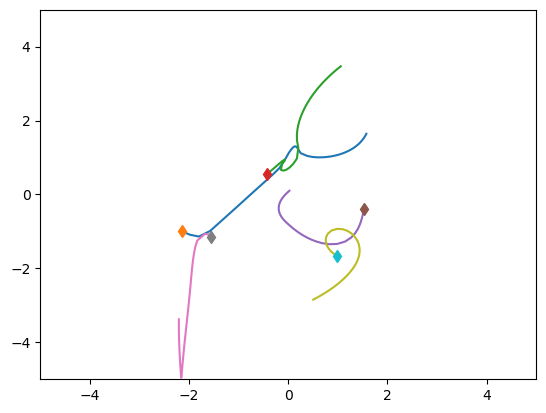

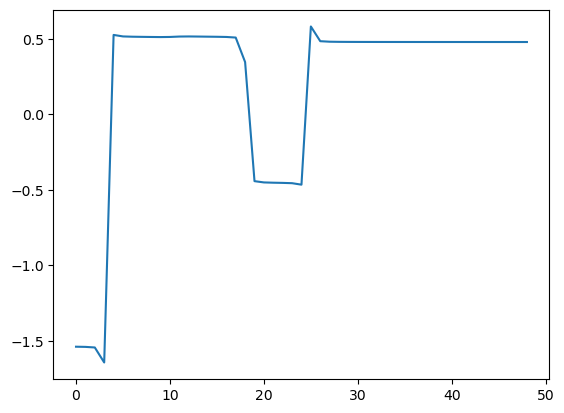

In [ ]:
import time
sim = ChargedParticlesSim()

t = time.time()
loc, vel, edges = sim.sample_trajectory(T=5000, sample_freq=100)

print(edges)
print("Simulation time: {}".format(time.time() - t))
vel_norm = np.sqrt((vel ** 2).sum(axis=1))
plt.figure()
axes = plt.gca()
axes.set_xlim([-5., 5.])
axes.set_ylim([-5., 5.])
for i in range(loc.shape[-1]):
    plt.plot(loc[:, 0, i], loc[:, 1, i])
    plt.plot(loc[0, 0, i], loc[0, 1, i], 'd')
plt.figure()
energies = [sim._energy(loc[i, :, :], vel[i, :, :], edges) for i in
            range(loc.shape[0])]
plt.plot(energies)
plt.show()

In [ ]:
# from https://github.com/ethanfetaya/NRI/blob/master/data/generate_dataset.py
#from synthetic_sim import ChargedParticlesSim, SpringSim
import time
import numpy as np
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--simulation', type=str, default='charged',
                    help='What simulation to generate.')
parser.add_argument('--num-train', type=int, default=50_000,
                    help='Number of training simulations to generate.')
parser.add_argument('--num-valid', type=int, default=10_000,
                    help='Number of validation simulations to generate.')
parser.add_argument('--num-test', type=int, default=10_000,
                    help='Number of test simulations to generate.')
parser.add_argument('--length', type=int, default=5_000,
                    help='Length of trajectory.')
parser.add_argument('--length-test', type=int, default=10_000,
                    help='Length of test set trajectory.')
parser.add_argument('--sample-freq', type=int, default=100, # =10 for smaller dt
                    help='How often to sample the trajectory.')
parser.add_argument('--n-balls', type=int, default=5,
                    help='Number of balls in the simulation.')
parser.add_argument('--seed', type=int, default=42,
                    help='Random seed.')

args = parser.parse_args('')

if args.simulation == 'springs':
    sim = SpringSim(noise_var=0.0, n_balls=args.n_balls)
    suffix = '_springs'
elif args.simulation == 'charged':
    sim = ChargedParticlesSim(noise_var=0.0, n_balls=args.n_balls)
    suffix = '_charged'
else:
    raise ValueError('Simulation {} not implemented'.format(args.simulation))

suffix += str(args.n_balls)
np.random.seed(args.seed)

print(suffix)


def generate_dataset(num_sims, length, sample_freq):
    loc_all = list()
    vel_all = list()
    edges_all = list()

    for i in trange(num_sims):
        t = time.time()
        loc, vel, edges = sim.sample_trajectory(T=length,
                                                sample_freq=sample_freq)
        if i % 100 == 0:
            print("Iter: {}, Simulation time: {}".format(i, time.time() - t))
        loc_all.append(loc)
        vel_all.append(vel)
        edges_all.append(edges)

    loc_all = np.stack(loc_all)
    vel_all = np.stack(vel_all)
    edges_all = np.stack(edges_all)

    return loc_all, vel_all, edges_all

_charged5


In [ ]:
args

Namespace(simulation='charged', num_train=50000, num_valid=10000, num_test=10000, length=5000, length_test=10000, sample_freq=100, n_balls=5, seed=42)

In [ ]:
args.length = 5100

In [ ]:
# T is going to be
args.length//args.sample_freq -1

50

In [ ]:
print("Generating {} training simulations".format(args.num_train))
t0 = time.time()
loc_train, vel_train, edges_train = generate_dataset(args.num_train,
                                                     args.length,
                                                     args.sample_freq)
t1 = time.time()
print(f'Total time: {t1-t0}')

Generating 50000 training simulations


  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipykernel_313169/185012918.py:123: RuntimeWarning: invalid value encountered in power
  l2_dist_power3 = np.power(


Iter: 0, Simulation time: 0.31176042556762695


/tmp/ipykernel_313169/185012918.py:94: RuntimeWarning: invalid value encountered in power
  l2_dist_power3 = np.power(


KeyboardInterrupt: 

In [ ]:
loc_train.shape, vel_train.shape, edges_train.shape

In [ ]:
i+=1
plt.plot(*loc_train[i].transpose(1,0,2));

In [ ]:
all_data = np.concatenate((loc_train, vel_train), axis=-2).transpose(0,1,3,2)
all_edges = edges_train

In [ ]:
all_edges.shape, all_data.shape

In [ ]:
assert np.all(np.isfinite(all_data))

In [ ]:
assert np.all(np.isfinite(all_edges))

In [ ]:
params = {}
params['data_path'] = '../data/raw/synth_charged_5_10k/'
# created with smaller dt at pyg_dnri_noencoder_trueedges_boundarymaskedloss_charged_5particles_gabriel_seed1_smalldt
# and saved at 'data/synth_charged_5_dt001/'

In [ ]:
from pathlib import Path

In [ ]:
out_dir = Path(params['data_path'])
out_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
train_data = torch.FloatTensor(all_data)
train_path = out_dir/'train_feats'
torch.save(train_data, train_path)
train_edges = torch.FloatTensor(all_edges)
train_path = out_dir/'train_edges'
torch.save(train_edges, train_path)

In [ ]:
!ls -alh ../data/raw/synth_charged_5_10k

In [ ]:
print("Generating {} validation simulations".format(args.num_valid))
t0 = time.time()
loc_valid, vel_valid, edges_valid = generate_dataset(args.num_valid,
                                                     args.length,
                                                     args.sample_freq)
t1 = time.time()
print(f'Total time: {t1-t0}')

In [ ]:
val_data   = torch.FloatTensor(np.concatenate((loc_valid, vel_valid), axis=-2).transpose(0,1,3,2))
val_path   = out_dir/'val_feats'
torch.save(val_data, val_path)
val_edges   = torch.FloatTensor(edges_valid)
val_path   = out_dir/'val_edges'
torch.save(val_edges, val_path)

In [ ]:
args.length_test = 10_100

In [ ]:
print("Generating {} test simulations".format(args.num_test))
loc_test, vel_test, edges_test = generate_dataset(args.num_test,
                                                  args.length_test, # which is double the training
                                                  args.sample_freq)

In [ ]:
test_data  = torch.FloatTensor(np.concatenate((loc_test, vel_test), axis=-2).transpose(0,1,3,2))
test_path  = out_dir/'test_feats'
torch.save(test_data, test_path)

test_edges  = torch.FloatTensor(edges_test)
test_path  = out_dir/'test_edges'
torch.save(test_edges, test_path)

# Data loading

In [ ]:
def seed(seed_val: int):
    """Set the random seed for reproducibility across NumPy and PyTorch."""
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    if torch.cuda.is_available():  torch.cuda.manual_seed_all(seed_val)

In [ ]:
def get_dv(
    data: torch.Tensor, # particle data (num_sims, num_particles, T, dim). dim=(x, y, v_x,v_y,…).
    sparse: bool = True # use pre‑computed (s_e, r_e) if True
) -> torch.Tensor:      # returns (d, dversor_x, dversor_y)

    """Pairwise distance `d` and normalized direction `v`
    for a set of particles across simulation frames."""
    assert data.dim() == 4, f"Expected 4‑D tensor, got {data.dim()}"
    N = data.shape[1]

    # Index tensors for particle pairs
    # use pre‑computed sparse index tensors (`s_e` and `r_e`)
    # otherwise fall back to a dense indexing scheme
    row_idx, col_idx = ((s_e.to(data.device), r_e.to(data.device))
                        if sparse else non_diagonal_linear_index(N))

    # Displacement (only first two coords, i.e. x & y)
    v = data[:, col_idx, :, :2] - data[:, row_idx, :, :2]

    # Euclidean distance with a trailing dim for concat
    d = torch.sqrt((v * v).sum(-1, keepdim=True))

    # Normalized direction vector
    v = v / d

    # Concatenate distance and direction
    return torch.cat((d, v), dim=-1)

In [ ]:
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.loader import DataLoader

class SmallSynthDataPyG():
    def __init__(self, data_path, mode, params, max_samples=200):
        assert mode in {"train", "val", "test"}, f"Invalid mode: {mode}"

        # store paths
        self.mode = mode;  self.data_path = data_path;

        path = os.path.join(data_path, f'{mode}_feats')
        edge_path = os.path.join(data_path, f'{mode}_edges')

        # load node data into device directly
        device = torch.device('cuda' if (params['gpu'] and torch.cuda.is_available())
                     else 'cpu')
        self.node_feats = torch.load(path, map_location=device)[:max_samples]

        # Transpose data:
        # shape=  sims,T,num_particles, dim -> sims,num_particles,T, dim
        self.node_feats = self.node_feats.transpose(1,2).contiguous()

        # take the latest 50 snapshots (optionally subsampled)
        sf = 1
        self.delta_t = 1e-3*100
        self.slice_t = slice_t = slice(-50, None, sf)
        self.node_feats = self.node_feats[:,:,slice_t]

        # normalize data as in dnri
        self.use_data_norm = params.get('use_data_norm',True)
        if self.use_data_norm:
            if params.get('norms', None) is None:
                self._set_norm()
            else:
                print('Using given norm')
                self.loc_max, self.loc_min = params['norms']['loc_max'], params['norms']['loc_min']
                self.vel_max, self.vel_min = params['norms']['vel_max'], params['norms']['vel_min']
                self.norm, self.norm_v = params['norms']['norm'], params['norms']['norm_v']
            self._normalize_data()

        # get edge features from normalized node features
        with device:
            self.edge_feats = get_dv(self.node_feats, params['sparse'])

            # set edges
            if params['sparse']: # For instance, if we know particle 0 and 1 do not interact with each other
                send_edges, recv_edges = (s_e.cuda(), r_e.cuda()) if params['gpu'] else (s_e, r_e)
            else: # fully connected, no prior assumption
                send_edges, recv_edges = torch.where(torch.ones(params['num_vars']) - torch.eye(params['num_vars']))
                edge2node_mat = nn.Parameter(torch.stack([(recv_edges == i)*1.
                                                      for i in range(params['num_vars'])]),
                                         requires_grad=False)
                self.edge2node_mat = edge2node_mat
        edge_index = torch.stack((send_edges, recv_edges))

        # create Data list containing time series' node and edge feats
        if not params['sparse']:
            self.datalist = [Data(node_feats=n, edge_feats=e,
                                  edge_index=edge_index, edge2node_mat=edge2node_mat)
                         for n,e in zip(self.node_feats,self.edge_feats)]
        else:
            self.datalist = [Data(node_feats=n, edge_feats=e,
                                  edge_index=edge_index)
                         for n,e in zip(self.node_feats,self.edge_feats)]

        # load ground truth edges into CPU for comparison-only
        self.edges = torch.load(edge_path)
        self.edges = self.edges[:max_samples] # samples, 5, 5
        # take out the diagonal and flatten
        # Get the indices of diagonal elements
        r,c = np.diag_indices(self.edges.shape[1])
        # Create a mask to select non-diagonal elements
        mask = torch.ones_like(self.edges[0], dtype=bool)
        mask[r,c] = False
        # Apply the mask to the matrix
        self.edges = self.edges[:,mask] # samples, E=N*(N-1)
        if params['sparse']:
            self.edges = self.edges[...,np.concatenate([np.flatnonzero(np.logical_and(row_idx==i.item(), col_idx==j.item())) for i,j in zip(s_e,r_e)])]
        # take the latest 50 snapshots
        self.edges = ((self.edges+1.)*.5)[:,:,None].expand(-1,-1,self.node_feats.shape[2]) # samples, E, T
        # self.edges = F.one_hot(self.edges.long())  # samples, E, T, C
        self.edges = self.edges.transpose(1,2)

    def _set_norm(self):
        """Compute min / max statistics from the *training* feature file."""
        train_data = torch.load(os.path.join(self.data_path, 'train_feats'))
        self.loc_max, self.loc_min = train_data[...,  :2].max(), train_data[...,  :2].min()
        self.vel_max, self.vel_min = train_data[..., 2:4].max(), train_data[..., 2:4 ].min()
        self.norm, self.norm_v = (self.loc_max-self.loc_min)*.5, (self.vel_max-self.vel_min)*.5

    def _normalize_data(self):
        """Apply min‑max scaling to position (first 2 dims) and velocity (next 2)."""
        self.node_feats[...,  :2] = (self.node_feats[...,  :2]-self.loc_min) / self.norm  -1
        self.node_feats[..., 2:4] = (self.node_feats[..., 2:4]-self.vel_min) / self.norm_v-1

    def unnormalize(self, data):
        """Revert the normalisation applied in ``_normalize_data``."""
        if self.use_data_norm:
            result1 = (data[...,  :2] + 1) * self.norm   + self.loc_min
            result2 = (data[..., 2:4] + 1) * self.norm_v + self.vel_min
            return torch.cat([result1, result2], dim=-1)
        else:
            return data

    def _normalize_symmetric_data(self):
        """Scale by the absolute maximum observed in the training set."""
        train_data = torch.load(os.path.join(self.data_path, 'train_feats'))
        self.loc_max = train_data[...,  :2].abs().max()
        self.vel_max = train_data[..., 2:4].abs().max()
        self.norm, self.norm_v = self.loc_max, self.vel_max

        self.node_feats[...,  :2] = (self.node_feats[...,  :2]+self.loc_max) / self.norm  -1.
        self.node_feats[..., 2:4] = (self.node_feats[..., 2:4]+self.vel_max) / self.norm_v-1.

In [ ]:
params['data_path']

'../data/raw/synth_charged_5_10k/'

In [ ]:
ds_train = SmallSynthDataPyG(params['data_path'], 'train', params)

In [ ]:
ds_train.norm, ds_train.node_feats.shape, ds_train.edges.shape

(tensor(5.), torch.Size([200, 5, 50, 4]), torch.Size([200, 50, 20]))

We prepare a data loader with implicit batching.

In [ ]:
seed(params['data_seed'])
dl_train = DataLoader(ds_train.datalist, batch_size=params['batch_size'], shuffle=True, drop_last=True)

The same for the validation set.

In [ ]:
ds_valid = SmallSynthDataPyG(params['data_path'], 'val', params, max_samples=1_000)
dl_valid = DataLoader(ds_valid.datalist, batch_size=16, shuffle=False, drop_last=False)

Then, check one batch.

In [ ]:
b = next(iter(dl_train)); b

DataBatch(edge_index=[2, 320], node_feats=[80, 50, 4], edge_feats=[320, 50, 3], edge2node_mat=[80, 20], batch=[80], ptr=[17])

In [ ]:
b.edge_index

tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,
          4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
          9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13,
         13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17,
         18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21, 22, 22,
         22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26,
         27, 27, 27, 27, 28, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31,
         31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35,
         36, 36, 36, 36, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40,
         40, 40, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44, 44,
         45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48, 49, 49,
         49, 49, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 52, 52, 53, 53, 53, 53,
         54, 54, 54, 54, 55,

In [ ]:
b.ptr

tensor([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80],
       device='cuda:0')

And make a quick visualization of the training data.

tensor(5.) tensor(6.4169)
tensor(5.) tensor(-5.0000)
tensor(6.4619) tensor(-6.3719)


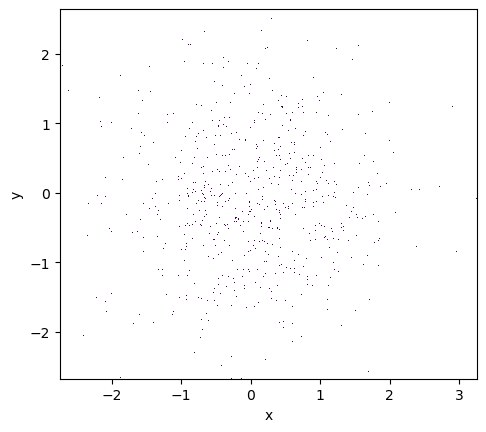

In [ ]:
print(ds_train.norm, ds_train.norm_v)
print(ds_train.loc_max, ds_train.loc_min)
print(ds_train.vel_max, ds_train.vel_min)
plt.hist2d(ds_train.node_feats[:,:,:1,0].reshape(-1).cpu().numpy()*ds_train.norm.cpu().numpy(),
           ds_train.node_feats[:,:,:1,1].reshape(-1).cpu().numpy()*ds_train.norm.cpu().numpy(), 500, norm='log');
plt.gca().set_aspect('equal');
plt.gca().set( xlabel='x', ylabel='y');

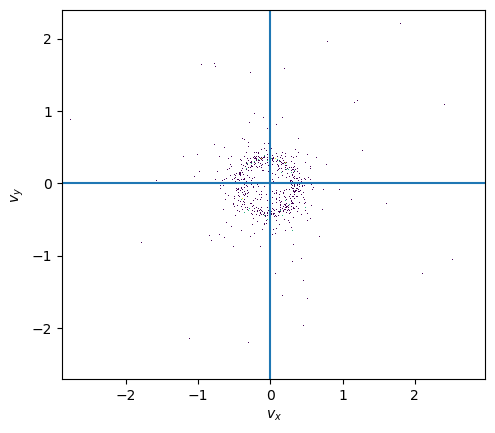

In [ ]:
plt.hist2d(ds_train.node_feats[:,:,:1,2].reshape(-1).cpu().numpy()*ds_train.norm.cpu().numpy(),
           ds_train.node_feats[:,:,:1,3].reshape(-1).cpu().numpy()*ds_train.norm.cpu().numpy(), 500, norm='log');
plt.axhline(0);plt.axvline(0);
plt.gca().set_aspect('equal');
plt.gca().set( xlabel=r'$v_x$', ylabel=r'$v_y$');

## Inspect data

In [ ]:
n = ds_train.node_feats.shape[1]; n

5

In [ ]:
feats = ds_train.node_feats.cpu().transpose(2,1)

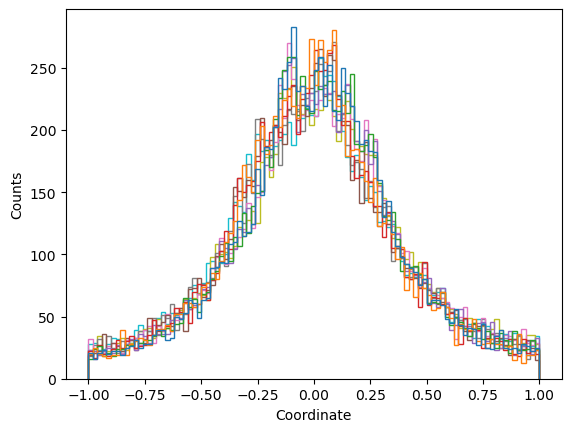

In [ ]:
plt.hist(ds_train.node_feats[:,0:n,:,:2].reshape(-1,2*n).cpu().numpy(), 100, histtype='step');
plt.gca().set( xlabel='Coordinate', ylabel='Counts');

In [ ]:
norm = ds_train.norm.numpy()

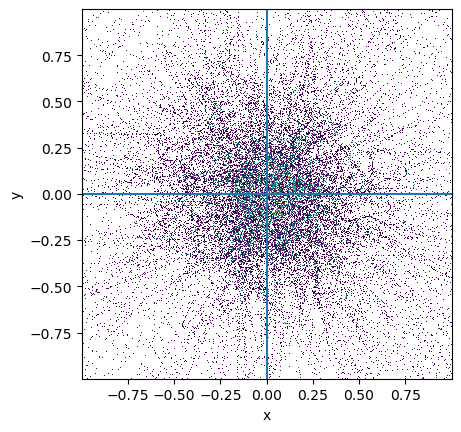

In [ ]:
plt.hist2d(feats[:,:,:,0].reshape(-1).numpy(),
           feats[:,:,:,1].reshape(-1).numpy(), 500, norm='log');
plt.axhline(0);plt.axvline(0);
plt.gca().set_aspect('equal');
plt.gca().set( xlabel='x', ylabel='y');

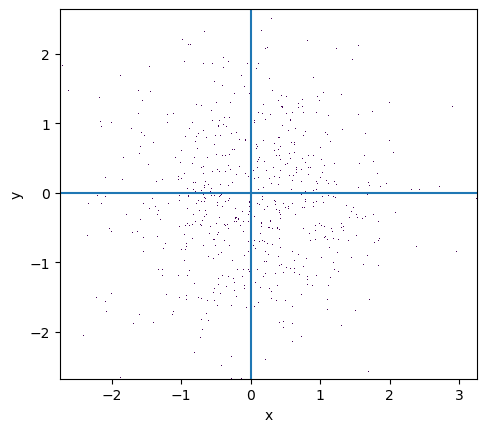

In [ ]:
plt.hist2d(feats[:,:1,:,0].reshape(-1).numpy()*norm,
           feats[:,:1,:,1].reshape(-1).numpy()*norm, 500, norm='log');
plt.axhline(0);plt.axvline(0);
plt.gca().set_aspect('equal');
plt.gca().set( xlabel='x', ylabel='y');

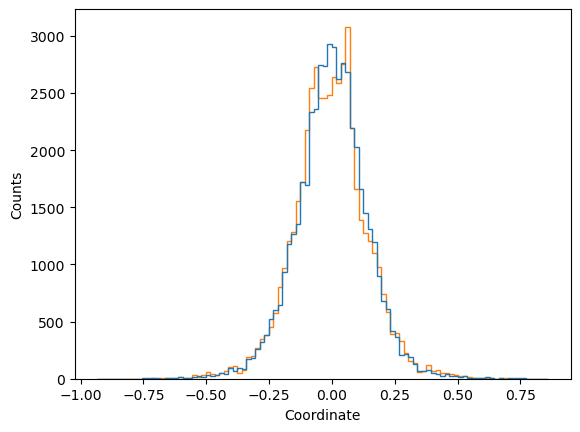

In [ ]:
plt.hist(feats[...,2:].reshape(-1,2).numpy(), 100, histtype='step');plt.gca().set( xlabel='Coordinate', ylabel='Counts');

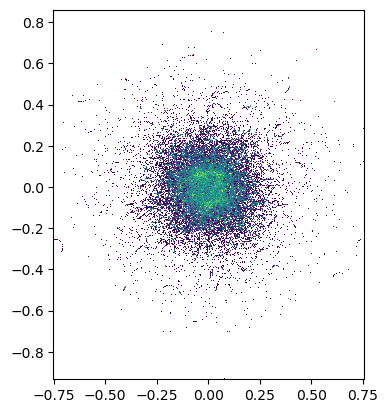

In [ ]:
plt.hist2d(feats[:,:,:,2].reshape(-1).numpy(),
           feats[:,:,:,3].reshape(-1).numpy(), 400, norm='log');
plt.gca().set_aspect('equal');

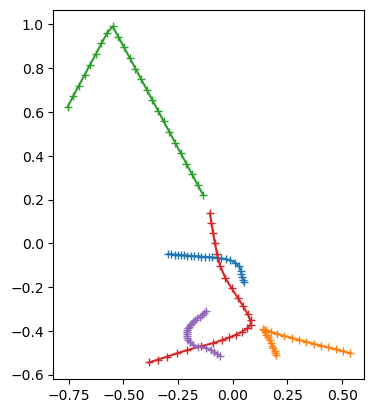

In [ ]:
i=0#i+=1
for j in range(n):
    plt.plot(*feats[i,:25,j,:2].cpu().T,'+-');
plt.gca().set_aspect('equal');

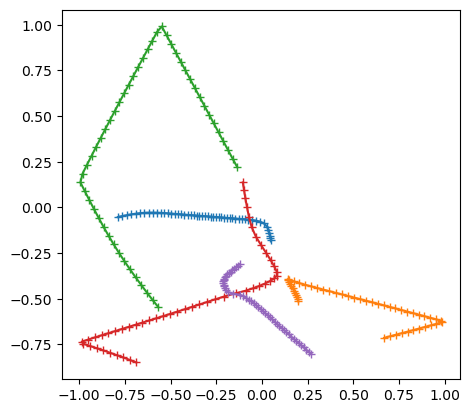

In [ ]:
i=0#i+=1
for j in range(n):
    plt.plot(*feats[i,:,j,:2].cpu().T,'+-');
plt.gca().set_aspect('equal');

In [ ]:
print( f"{((ds_train.edges[:,1:]==0)*1.).mean()*100:.2g}% of repulsive(attractive) interacting edges")

51% of repulsive(attractive) interacting edges


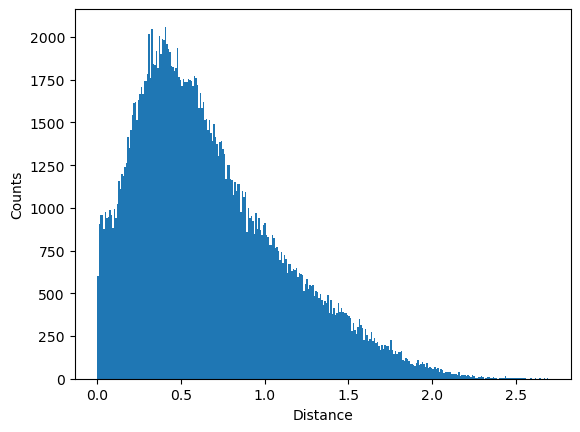

In [ ]:
plt.hist(ds_train.edge_feats[...,0].reshape(-1).cpu().numpy(),300);
plt.gca().set( xlabel='Distance', ylabel='Counts');

## How to determine interior? R < maximum bounce from boundary

We take a radius smaller than the step from the boundary to the center with the biggest velocity as a safe aproximation to the region where particles normally do not touch the boundary.

In [ ]:
path = os.path.join(params['data_path'],f'train_feats')
# load node data into device directly
sf = 1
slice_t = slice(None, None, sf)
node_feats = torch.load(path,
                         map_location=torch.device('cuda' if (params['gpu'] and torch.cuda.is_available())
                                                   else 'cpu'))[:,slice_t].transpose(2,1)

node_feats.shape, path

(torch.Size([50000, 5, 50, 4]), '../data/raw/synth_charged_5_10k/train_feats')

In [ ]:
delta_t = 1e-3*100 # delta_T*smapling_freq
circle_radius = 5.
circle_center = np.zeros(2)

In [ ]:
# take the maximum velocity and suppose it starts from the border
# then that radius is save
vmax = torch.linalg.norm(node_feats[...,2:4],axis=-1).max()
Rinterior = (1. - vmax*delta_t/circle_radius).item()
print(f'{Rinterior=:.3g}')
print(vmax, delta_t, circle_radius)

Rinterior=0.85
tensor(7.5170, device='cuda:0') 0.1 5.0


The actual bounces with the boundary can be seen to lie on on bigger radius than Rinterior.

In this case, the boundary is a square.

In [ ]:
mask = torch.any((node_feats[:,:,:-1,:2]+node_feats[:,:,:-1,2:4]/
              torch.linalg.norm(node_feats[:,:,:-1,2:4],axis=-1, keepdims=True)*
              torch.linalg.norm(node_feats[:,:,1:,2:4],axis=-1, keepdims=True)*delta_t).abs()
              >circle_radius,axis=-1)
idx = torch.nonzero(mask)

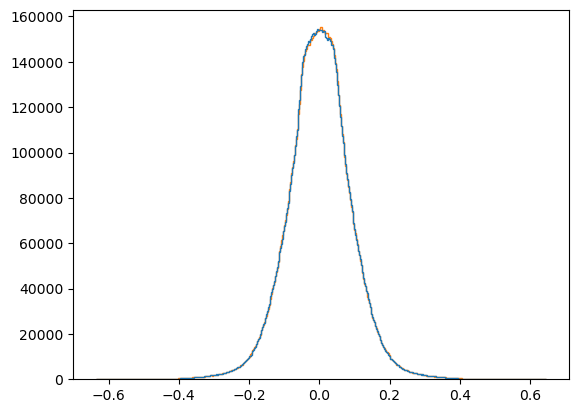

In [ ]:
plt.hist(node_feats[:,:,:,2:].reshape(-1,2).cpu().numpy()*delta_t,500, histtype='step', );

In [ ]:
mask.shape, idx.shape, node_feats[:,:,:-1,:2].shape

(torch.Size([50000, 5, 49]),
 torch.Size([82316, 3]),
 torch.Size([50000, 5, 49, 2]))

In [ ]:
idx_ = idx+torch.tensor([[0,0,1]], device=idx.device)

In [ ]:
assert (idx_[:,-1]>=50).sum()==0

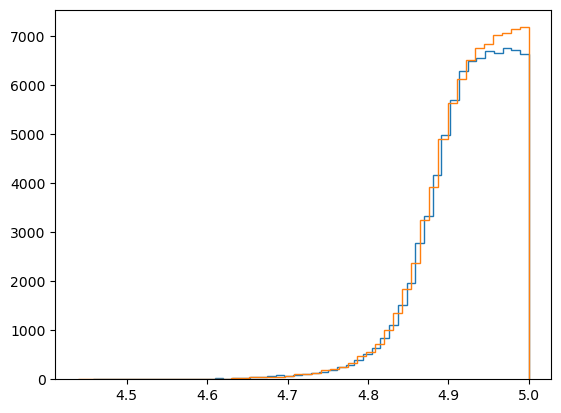

In [ ]:
plt.hist(node_feats[:,:,:-1,:2][mask].abs().max(-1).values.cpu().numpy(),50, histtype='step');
plt.hist(node_feats[:,:,:,:2][*(idx_).T].abs().max(-1).values.cpu().numpy(),50, histtype='step');

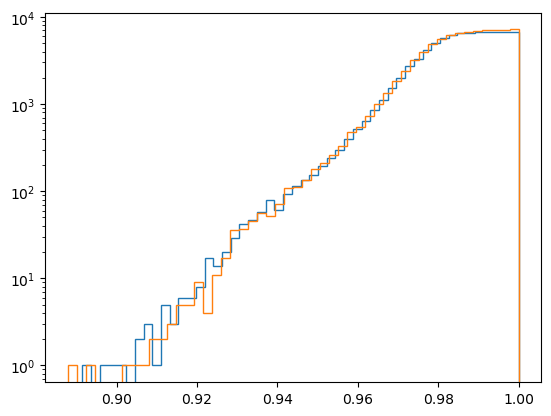

In [ ]:
plt.hist(node_feats[:,:,:-1,:2][mask].abs().max(-1).values.cpu().numpy()/circle_radius,50, histtype='step', log=True);
plt.hist(node_feats[:,:,:,:2][*(idx_).T].abs().max(-1).values.cpu().numpy()/circle_radius,50, histtype='step');

# Model

## Utils

In [ ]:
def init_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight.data)
            m.bias.data.fill_(0.1)
        elif isinstance(m, nn.BatchNorm1d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()

def set_dropout(self,p: float):
    """Set the dropout rate `p` for every nn.Dropout module in the network."""
    for m in self.modules():
        if isinstance(m, nn.Dropout):
            m.p = p

In [ ]:
class RefNRIMLP(nn.Module):
    """Two-layer fully-connected ELU net with batch norm."""

    def __init__(self, n_in, n_hid, n_out, do_prob=0., use_bn=True):
        super(RefNRIMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_in, n_hid),
            nn.ELU(inplace=True),
            nn.Dropout(do_prob),
            nn.Linear(n_hid, n_out),
            nn.ELU(inplace=True),
            nn.Linear(n_out,n_out)  # <--linear at the end gives full range
        )
        self.bn = nn.BatchNorm1d(n_out) if use_bn else None

        init_weights(self)

    def batch_norm(self, inputs):
        orig_shape = inputs.shape
        x = inputs.view(-1, inputs.size(-1))
        x = self.bn(x)
        return x.view(orig_shape)

    def forward(self, inputs):
        # Input shape: [num_sims, num_things, num_features]
        x = self.model(inputs)
        return self.batch_norm(x) if self.bn is not None else x

In [ ]:
# from torch.nn.functional import gumbel_softmax

# redefine gumbel_softmax to avoid Gumbel noise in the inference
# effectively sampling from a categorical distribution
from torch.overrides import handle_torch_function,has_torch_function_unary
import warnings

def gumbel_softmax (
    logits: torch.Tensor,
    tau: float = 1,
    hard: bool = False,
    eps: float = 1e-10,
    dim: int = -1,
    training: bool = True,
) -> torch.Tensor:
    assert tau>0, f"`tau` must be > 0, got {tau}"
    if has_torch_function_unary(logits):
        return handle_torch_function(
            gumbel_softmax, (logits,), logits,
            tau=tau, hard=hard, eps=eps, dim=dim, training=training)
    if not torch.isfinite(logits).all():
        raise ValueError("`logits` contain NaN or Inf values")
    if eps != 1e-10:
        warnings.warn("`eps` parameter is deprecated and has no effect.")

    gumbels = (
        -torch.empty_like(logits, memory_format=torch.legacy_contiguous_format)
        .exponential_()
        .log()
    )  # ~Gumbel(0,1)
    if training:
        gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    else:
        gumbels = logits / tau
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(
            logits, memory_format=torch.legacy_contiguous_format
        ).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

## Learnable super-Gaussian

In [ ]:
def getattrs(o,l): return *[getattr(o,n) for n in l],

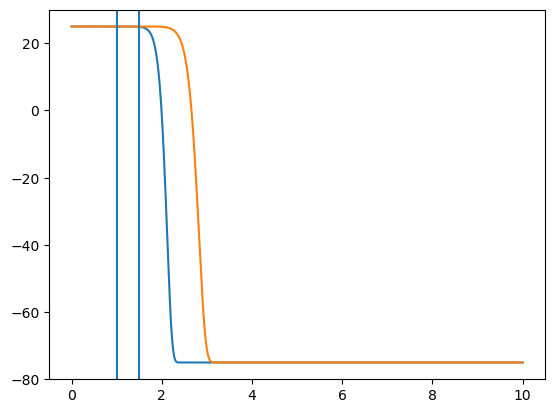

In [ ]:
x = torch.linspace(0,10,1000)/ds_train.norm
sigma = torch.tensor(0.3)
beta = torch.tensor(10)
plt.plot(x*ds_train.norm,(torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta))-.75)*100);
sigma = torch.tensor(0.4)
beta = torch.tensor(10)
plt.plot(x*ds_train.norm,(torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta))-.75)*100);
plt.axvline(1.5);plt.axvline(1);

In [ ]:
# modified from https://github.com/DeepTrackAI/deeplay/blob/develop/deeplay/components/gnn/mpn/ldw.py#L9
class LearnableDistanceMask(nn.Module):
    def __init__(
        self,
        C: int,  # number of classes (-1 if skip_first)
        sigma: list[float] = None,  # default [.4]*C
        beta:  list[float] = None,   # default [10.]*C
        sigma_limit  = [1e-3, 1.],
        beta_limit   = [1.,   100.],
        skip_first   = True,
    ):
        super().__init__()

        self.C = C
        self.sigma_limit = sigma_limit
        self.beta_limit  = beta_limit
        self.skip_first = skip_first

        if sigma is None:  sigma = [.4]*C
        if beta is None:   beta  = [10.]*C
        self.sigma = nn.Parameter(torch.tensor(sigma*C if len(sigma)==1 else sigma))
        self.beta  = nn.Parameter(torch.tensor(beta*C  if len(beta)==1 else beta))
        assert len(self.sigma)==C
        assert len(self.beta) ==C

    def forward(self, distance  # BE, 1
               ):
        sigma = torch.clamp(self.sigma, *self.sigma_limit)
        beta  = torch.clamp(self.beta,  *self.beta_limit)
        if self.skip_first:
            edge_weights = torch.zeros(*distance.shape[:-1],self.C+1,
                                       device=distance.device)
            edge_weights[...,1:] = torch.exp(-1.*torch.pow(torch.square(distance) / (2. * torch.square(sigma)), beta))  # BE,C-1
            return edge_weights  # [BE, C]
        else:
            return torch.exp(-1.*torch.pow(torch.square(distance) / (2. * torch.square(sigma)), beta))  # BE,C

## Encoder

In [ ]:
class Pooling(nn.Module):
    """linear aggregation of min, max, std, and mean values in a given dimension."""
    def __init__(self, dim, **kwargs):
        super(Pooling,self).__init__()
        self.lin_agg = nn.Linear(4,1)
        self.dim = dim
        init_weights(self)

    def forward(self, x, dim=None):
        if dim is None: dim = self.dim
        return self.lin_agg(torch.stack((x.min(dim=dim).values,x.max(dim=dim).values,  # aminmax derivative not implemented
                                         *torch.std_mean(x,dim=dim)),
                                        dim=dim).transpose(dim,-1)).transpose(dim,-1)

In [ ]:
class DNRI_Encoder(nn.Module):
    def __init__(self, params,**kwargs):
        super(DNRI_Encoder, self).__init__()
        self.num_vars = num_vars = params['num_vars']  # 3
        self.num_edges = params['num_edge_types']  # 2
        self.skip_first = skip_first = params['skip_first']  # True
        self.sparse = sparse = params['sparse']
        if not self.sparse: self.edge2node_mat = kwargs['edge2node_mat']
        use_bn = params['encoder_bn']
        dropout = params['encoder_dropout']  # 0

        inp_node_size = params['input_node_size']    #  4
        n_bound = params.get('n_bound',0)
        inp_edge_size = params['input_edge_size']
        hidden_size = params['encoder_hidden']  # 256
        rnn_hidden_size = params['encoder_rnn_hidden']  # 64
        if rnn_hidden_size is None:  rnn_hidden_size = hidden_size
        self.rnn_hidden_size = rnn_hidden_size
        rnn_type = params['encoder_rnn_type']  # 'lstm'
        self.rnn_num_layers = rnn_num_layers = params.get('encoder_rnn_num_layers', 1)
        self.static = params.get('static', False)

        # encoder takes both positions and velocities
        # hence ---------------------------v   as decoder takes only velocities to not depend on absolute coordinates
        self.mlp1 = RefNRIMLP(inp_node_size*2, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp1_e = RefNRIMLP(inp_edge_size, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp2 = RefNRIMLP(3*hidden_size, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp3 = RefNRIMLP(  hidden_size, hidden_size, hidden_size, dropout, use_bn=use_bn)
        self.mlp4 = RefNRIMLP(3*hidden_size, hidden_size, hidden_size, dropout, use_bn=use_bn)

        if rnn_type == 'lstm': # True
            self.bi_rnn = nn.LSTM(hidden_size, rnn_hidden_size, num_layers=rnn_num_layers, batch_first=True, bidirectional=True)
        elif rnn_type == 'gru':
            self.bi_rnn = nn.GRU (hidden_size, rnn_hidden_size, num_layers=rnn_num_layers, batch_first=True, bidirectional=True)

        # encoder out
        out_hidden_size = 2*rnn_hidden_size  # 128
        num_layers = params['encoder_mlp_num_layers']  # 3
        if num_layers == 1: # False
            self.encoder_fc_out = nn.Linear(out_hidden_size, self.num_edges)
        else:
            tmp_hidden_size = params['encoder_mlp_hidden'] # 128
            layers = [nn.Linear(out_hidden_size, tmp_hidden_size), nn.ELU(inplace=True)]
            for _ in range(num_layers - 2):
                layers.append(nn.Linear(tmp_hidden_size, tmp_hidden_size))
                layers.append(nn.ELU(inplace=True))
            layers.append(nn.Linear(tmp_hidden_size, self.num_edges))
            self.encoder_fc_out = nn.Sequential(*layers)

        # prior out
        num_layers = params['prior_num_layers'] # 3
        if num_layers == 1: # False
            self.prior_fc_out = nn.Linear(rnn_hidden_size, self.num_edges)
        else:
            tmp_hidden_size = params['prior_hidden_size'] # 128
            layers = [nn.Linear(rnn_hidden_size, tmp_hidden_size), nn.ELU(inplace=True)]
            for _ in range(num_layers - 2):
                layers.append(nn.Linear(tmp_hidden_size, tmp_hidden_size))
                layers.append(nn.ELU(inplace=True))
            layers.append(nn.Linear(tmp_hidden_size, self.num_edges))
            self.prior_fc_out = nn.Sequential(*layers)

        # static prior
        if self.static:
            self.pool_e = Pooling(dim=-2)
            self.pool_p = Pooling(dim=-2)

        init_weights(self)

    def node2edge(self, node_embeddings, edge_index):
        # Input size: [batch*num_vars, num_timesteps, embed_size]
        return torch.cat([node_embeddings[edge_index[0]],
                          node_embeddings[edge_index[1]]],
                         dim=-1)

    def edge2node(self, edge_embeddings, BN,  # [batch*num_edges, timesteps, embed_size]
                  edge_index=None, sparse=True):
        # BN is Batch*Nodes_num, not edges
        old_shape = edge_embeddings.shape
        device = next(self.parameters()).device
        node_aggregate = torch.zeros((BN, *old_shape[1:]), # B*N, T, H
                                     device=device)
        if sparse:
            if len(edge_embeddings.shape) == 3:
                node_aggregate = node_aggregate.scatter_add(dim=0, # nodes dim
                                     index=edge_index[1].view(-1,1,1).expand(-1, *old_shape[1:]),
                                     src=edge_embeddings,)
            else: # single_timestep
                 node_aggregate = node_aggregate.scatter_add(dim=0, # nodes dim
                                     index=edge_index[1].view(-1,1).expand(-1, old_shape[-1]),
                                     src=edge_embeddings,)
        else: # fully connected
            if len(edge_embeddings.shape) == 3:
                tmp_embeddings = edge_embeddings.view(old_shape[0], old_shape[1], -1)
                node_aggregate = torch.matmul(self.edge2node_mat, tmp_embeddings).view(old_shape[0], -1, *old_shape[2:])
            else:
                node_aggregate = torch.matmul(self.edge2node_mat, edge_embeddings)
        return node_aggregate/(self.num_vars-1)

    def forward(self,
                node_feats,
                edge_feats,
                edge_index,
               ):
        # Inputs is shape [batch*num_vars, num_timesteps,  input_size]
        x = node_feats  # B*N, T, 2
        BN = node_feats.shape[0]
        num_timesteps = node_feats.size(1)
        # x = node_feats.transpose(-3, -2).contiguous()  # already done in dataset creation
        x = self.mlp1(x)  # 2-layer ELU net per node        # B*N, T, H
        x = self.node2edge(x, edge_index)                   # B*E, T, 2H
        x_ = self.mlp1_e(edge_feats)                        # B*E, T, H
        x = self.mlp2(torch.cat((x,x_), dim=-1))            # B*E, T, H
        x_skip = x
        x = self.edge2node(x, BN, edge_index)               # B*N, T, 2H
        x = self.mlp3(x)                                    # B*N, T, H
        x = self.node2edge(x, edge_index)                   # B*E, T, H
        x = torch.cat((x, x_skip), dim=-1)  # Skip connection  # B*E, T, 2H
        x = self.mlp4(x)                                    # B*E, T, H


        # At this point, x should be [batch*num_edges, num_timesteps, hidden_size]
        # RNN aggregation
        old_shape = x.shape # B*E, T, H

        x, (h, c) = self.bi_rnn(x)  # B*E, T, 2*H; D*num_layers, B, H
        forward_x = x[...,:self.rnn_hidden_size]  # B*E,T,H
        prior_state = (h,c) # h[:self.rnn_num_layers], c[:self.rnn_num_layers]           # (D*num_layers, B*E,H)

        #x: [batch*num_edges, num_timesteps, hidden_size]
        prior_result = self.prior_fc_out(forward_x)  # B*E,T,C
        encoder_result = self.encoder_fc_out(x)  # B*E,T,C

        if self.static:
            encoder_result = self.pool_e(encoder_result).expand(-1,num_timesteps,-1)
            prior_result   = self.pool_p(prior_result  ).expand(-1,num_timesteps,-1)
        return prior_result, encoder_result, prior_state
                # B*E, T, C

    def single_step_forward(self,
                            node_feats,
                            edge_feats,
                            edge_index,
                            prior_state):
        # Inputs is shape [batch*num_vars, input_size]
        x = node_feats                                      # B*N, 2
        BN = node_feats.shape[0]
        x = self.mlp1(x)  # 2-layer ELU net per node        # B*N, H
        x = self.node2edge(x, edge_index)                   # B*E, 2H
        x_ = self.mlp1_e(edge_feats)                        # B*E, H
        x = self.mlp2(torch.cat((x,x_), dim=-1))            # B*E, H
        x_skip = x
        x = self.edge2node(x, BN, edge_index)               # B*N, 2H
        x = self.mlp3(x)                                    # B*N, H
        x = self.node2edge(x, edge_index)                   # B*E, H
        x = torch.cat((x, x_skip), dim=-1)  # Skip connection  # B*E, 2H
        x = self.mlp4(x)                                    # B*E, H


        # At this point, x should be [batch*num_edges, hidden_size]
        # RNN aggregation
        old_shape = x.shape # B*E, H
        x  = x.contiguous().view(-1, 1, old_shape[-1])   # B*E, 1, H


        x, (h, c) = self.bi_rnn(x,prior_state)  # B*E, 1, 2*H; D*num_layers, B, H
        forward_x = x[...,:self.rnn_hidden_size]  # B*E,1,H
        prior_state = (h, c) #h[:self.rnn_num_layers], c[:self.rnn_num_layers]           # (num_layers, B*E,H)
        prior_result = self.prior_fc_out(forward_x).view(*old_shape[:-1], self.num_edges).contiguous() # B*E, C

        return prior_result, prior_state

## Decoder

In [ ]:
class DNRI_MLP_Decoder(nn.Module):   # this is the Markovian decoder
    def __init__(self, params, **kwargs):
        super(DNRI_MLP_Decoder, self).__init__()
        self.num_vars = num_vars = params['num_vars']  # 3
        self.pred_delta = params.get('pred_delta',False)
        self.sparse = sparse = params['sparse']
        if not self.sparse: self.edge2node_mat = kwargs['edge2node_mat'].T
        edge_types = params['num_edge_types']  # 2
        self.n_bound = params.get('n_bound',0)
        n_hid   = params['decoder_hidden']  # 256
        msg_hid = params['decoder_msg_hidden']  # 256
        self.msg_out_size = msg_out = params['decoder_hidden_out'] # 1
        self.skip_first_edge_type = skip_first = params['skip_first']  # True
        inp_node_size  = n_in_node = params['input_node_size']  # 4
        inp_edge_size  = params['input_edge_size']  # 4
        out_size = params['output_size']
        self.dropout_prob = do_prob = params['decoder_dropout']  # 0.0

        self.edge_functions = nn.ModuleList([
            nn.Sequential(nn.Linear(1, msg_hid),nn.ReLU(),   # (B,E,H)
                          nn.Dropout(p=do_prob),
                          nn.Linear(msg_hid, msg_hid),nn.ReLU(),   # (B,E,H)
                          nn.Dropout(p=do_prob),
                          nn.Linear(  msg_hid, msg_out) # <-- msg_out = d for interpretability
                          # ,nn.ReLU() #
                          # NOTE: we deliberately omit a final activation;
                          # leaving the output linear lets the network learn
                          # unrestricted (possibly signed) message values.
                         )   # (B,E,O)
            for _ in range(edge_types if not skip_first else edge_types -1)
        ])
        self.node_function_x = nn.Sequential(
            nn.Linear(inp_node_size + msg_out+1+self.n_bound, n_hid), nn.ReLU(), nn.Dropout(p=do_prob),
            nn.Linear(            n_hid, n_hid), nn.ReLU(), nn.Dropout(p=do_prob),
            nn.Linear(            n_hid, out_size//2))
        self.node_function_v = nn.Sequential(
            nn.Linear(inp_node_size +self.n_bound, n_hid), nn.ReLU(), nn.Dropout(p=do_prob),
            nn.Linear(            n_hid, n_hid), nn.ReLU(), nn.Dropout(p=do_prob),
            nn.Linear(            n_hid, out_size//2))

        print('Using learned interaction net decoder.')


    def get_initial_hidden(self, inputs):  return None

    def forward(self, inputs,  # BN,F; BE,V; 2,BE
                hidden,
                edges,         # BE,C
               ):
        # TODO hidden is not used!! So, it can handle all times at once.
        node_feats_, edge_feats, edge_index = inputs
        # BN,F;      BE,V;       2,BE
        node_feats = node_feats_[...,2:]  # BE,2; # velocities

        # Node2edge
        pre_msg = edge_feats[...,0:1]  # (B*E,1) # distances

        all_msgs = torch.zeros(pre_msg.size(0),2,   # (B*E,d=2)
                               device=node_feats.device)

        # To exlude one edge type, simply offset range by 1
        start_idx = 1 if self.skip_first_edge_type else 0

        # Run separate MLP for every edge type
        # assume edge functions depend only on pairwise distance
        # and follow distance versor
        # TODO extend to other directions like magnetic force
        for i in range(len(self.edge_functions)):
            msg = self.edge_functions[i](pre_msg)*edge_feats[...,1:]
            msg = msg*edges[..., i+start_idx:i+start_idx+1]  # <-- Encoder z edges predictions
            all_msgs += msg     # (B*E,O)

        # Aggregate all msgs to receiver
        if self.sparse:
            agg_msgs = torch.zeros(node_feats.shape[0], all_msgs.shape[-1], #  B*N, H
                              device=all_msgs.device
                         ).scatter_add(
                             dim=0, # node dimension
                             index=edge_index[1].view(-1,1).expand(-1, all_msgs.shape[-1]), # repeat for each feature
                             src=all_msgs,)  # [BN, H]
        else:
            all_msgs = all_msgs.reshape(-1,self.edge2node_mat.shape[0],all_msgs.shape[-1])
            agg_msgs = all_msgs.transpose(-2, -1).matmul(self.edge2node_mat).transpose(-2, -1)
            agg_msgs = agg_msgs.reshape(-1,agg_msgs.shape[-1])

        agg_msgs = agg_msgs.contiguous()   # (B*N,O)

        # Skip connection
        aug_inputs = torch.cat([node_feats, agg_msgs], dim=-1) # B*N,F+O

        # NODE FUNCTION--------------------------------
        # separate positions and velocity predictions as an integrator
        pred_x = self.node_function_x(aug_inputs)   # B*N,O/2
        # impose the message is added to possible forces depending on velocity or active forces
        pred_v = self.node_function_v(node_feats) + agg_msgs   # B*N,O/2
        # Predict position and velocity deltas
        pred = torch.cat([pred_x,pred_v],dim=-1)   # B*N,O

        return (node_feats_ + pred, None) if not self.pred_delta else (pred, None)

## dNRI

In [ ]:
from torch_geometric.utils import to_dense_batch
class DNRI(nn.Module):
    def __init__(self, params, **kwargs):
        super(DNRI, self).__init__()
        self.sparse = sparse = params['sparse']
        # Model Params
        self.num_vars = params['num_vars']  # 21
        self.pred_delta = params.get('pred_delta',False)

        self.num_edges = self.num_edge_types = params.get('num_edge_types')  # 2

        self.skip_first = skip_first = params['skip_first']  # True
        self.Rbox = torch.tensor(params.get('Rbox', 3.0), device=dvc)
        self.n_bound = params.get('n_bound',0)

        self.use_supergaussian = params.get('use_supergaussian', True)
        if self.use_supergaussian:
            self.super_gaussians = LearnableDistanceMask(C=self.num_edges-1 if skip_first else self.num_edges,
                                                          skip_first=skip_first)

        self.encoder = DNRI_Encoder(params,) if self.sparse else DNRI_Encoder(params, **kwargs)

        decoder_type = params.get('decoder_type', None)  # ref_mlp
        if decoder_type == 'ref_mlp':
            self.decoder = DNRI_MLP_Decoder(params, ) if self.sparse else DNRI_MLP_Decoder(params, **kwargs)
        else:
            # recurrent decoder with hidden state
            self.decoder = DNRI_Decoder(params,) if self.sparse else DNRI_Decoder(params, **kwargs)

        # Training params
        self.gumbel_temp = params.get('gumbel_temp')  # 0.5
        self.train_hard_sample = params.get('train_hard_sample', True)  # True

        # loss params
        self.normalize_kl = params.get('normalize_kl', False)  # True
        self.normalize_kl_per_var = params.get('normalize_kl_per_var', False) # False
        self.normalize_nll = params.get('normalize_nll', False)  # True
        self.normalize_nll_per_var = params.get('normalize_nll_per_var', False) # False
        self.kl_coef = params.get('kl_coef', 1.)  # 1.0
        self.prior_coef = params.get('prior_coef', 1.)
        self.nll_loss_type = params.get('nll_loss_type', 'crossent')  # gaussian
        self.prior_variance = params.get('prior_variance')   # 5e-05
        self.timesteps = params.get('timesteps', 0)  #
        self.burn_in_steps = params.get('train_burn_in_steps') #
        self.add_uniform_prior = params.get('add_uniform_prior')
        self.Rinterior = params.get('Rinterior', 0.8)

        if self.add_uniform_prior:
            if params.get('no_edge_prior') is not None: # 0.9
                prior = torch.full((self.num_edge_types,),(1 - params['no_edge_prior'])/(self.num_edge_types - 1)) # 0.1/1
                prior[0] = params['no_edge_prior'] # 0.9
                log_prior = torch.log(prior) # log([0.9,0.1])
                log_prior = torch.unsqueeze(log_prior, 0)
                if params['gpu']:  log_prior = log_prior.cuda(non_blocking=True)
                self.log_prior = log_prior
                print("USING NO-EDGE PRIOR: ",prior, self.log_prior) # <-----
            else:
                print("USING UNIFORM PRIOR")
                prior = torch.full((self.num_edge_types,), 1.0/self.num_edge_types)
                log_prior = torch.log(prior)
                log_prior = torch.unsqueeze(log_prior, 0)
                if params['gpu']:  log_prior = log_prior.cuda(non_blocking=True)
                self.log_prior = log_prior

    def single_step_forward(self, inputs, # BN,F; BE,V; 2,BE
                            decoder_hidden,
                            edge_logits,  # BE,C
                            hard_sample):
        # sample edges at each timestep
        edges = gumbel_softmax(edge_logits,
                               tau=self.gumbel_temp,
                               hard=hard_sample,
                               training=self.training,
                              )  # BE,C
        if self.use_supergaussian:
            # mask with learnable supergaussian based on distance
            mask_type = self.super_gaussians(inputs[1][...,0:1])  # distance
            edges = edges * mask_type  # zero-out type of edges beyond distance
        predictions, decoder_hidden = self.decoder(inputs, decoder_hidden, edges)  # BN,O; None
        return predictions, decoder_hidden, edges

    def forward(self, inputs, is_train=False,
                      return_edges=False, return_logits=False, use_prior_logits=False):
        node_feats, edge_feats, edge_index = getattrs(inputs,['node_feats','edge_feats', 'edge_index'])
        decoder_hidden = self.decoder.get_initial_hidden(node_feats) # None
        num_time_steps = node_feats.size(1)
        all_edges = []
        all_predictions = []
        all_priors = []
        hard_sample = (not is_train) or self.train_hard_sample  # False
        prior_logits, posterior_logits, _ = self.encoder(node_feats[:,:-1], edge_feats[:,:-1], edge_index)
        for step in range(num_time_steps-1):
            current_inputs = (node_feats[:, step], edge_feats[:,step], edge_index)
            current_p_logits = posterior_logits[:, step]
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs,
                                                                          decoder_hidden,
                                                                          current_p_logits,
                                                                          hard_sample)
            all_predictions.append(predictions)
            all_edges.append(edges)
        all_predictions = torch.stack(all_predictions, dim=1)  # BN,T-1,O
        all_edges = torch.stack(all_edges, dim=1) # BE,T-1,C
        return posterior_logits, prior_logits, all_predictions, all_edges
               # BE,T-1,C;       BE,T-1,C;     # BN,T-1,O

    def calculate_loss(self, inputs, is_train=False,
                       return_edges=False, return_logits=False, use_prior_logits=False):
        node_feats, edge_feats, edge_index = getattrs(inputs,['node_feats','edge_feats', 'edge_index'])
        # BN,T,F;   BE,T,V;     2,BE
        decoder_hidden = self.decoder.get_initial_hidden(node_feats) # None
        num_time_steps = node_feats.size(1) # T
        all_edges = []
        all_predictions = []
        all_priors = []
        hard_sample = (not is_train) or self.train_hard_sample
        prior_logits, posterior_logits, _ = self.encoder(node_feats[:,:-1],edge_feats[:,:-1], edge_index)
        # BE,T-1,C;     BE,T-1,C;          2*(D*num_layers, BE,H)
        for step in range(num_time_steps-1):
            current_inputs = (node_feats[:, step], edge_feats[:,step], edge_index)  # BN,F; BE,V; 2,BE
            current_p_logits = posterior_logits[:, step]  # BE,C
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs,  # BN,F; BE,V; 2,BE
                                                                          decoder_hidden,
                                                                          current_p_logits, # BE,C
                                                                          hard_sample)
            # BN,O; None; BE,C
            all_predictions.append(predictions)
            all_edges.append(edges)
        all_predictions = torch.stack(all_predictions, dim=1) # BN,T-1,O

        target = node_feats[:, 1:,] if not self.pred_delta else node_feats[...,2:].diff(dim=1) # BN,T-1,O
        loss_nll = self.nll(all_predictions, target)  # gaussian
        posterior_prob = F.softmax(posterior_logits, dim=-1)  # BE,T-1,C
        loss_kl = self.kl_categorical_learned(posterior_prob, prior_logits) # 1
        if self.add_uniform_prior:  # True
            loss_kl = 0.5*loss_kl + 0.5*self.prior_coef*self.kl_categorical_avg(posterior_prob)   # 1
        loss = loss_nll + self.kl_coef*loss_kl  # 1
        loss = loss.mean()  # 1

        if return_edges: # False
            all_edges = torch.stack(all_edges, dim=1) # BE,T-1,C
            return loss, loss_nll, loss_kl, all_edges, all_predictions
        elif return_logits:  # True <-----------
            return loss, loss_nll, loss_kl, posterior_logits, all_predictions
        else:
            return loss, loss_nll, loss_kl

    def calculate_baseloss(self, inputs,):
        node_feats = inputs['node_feats'] # node_feats=[21, 50, 4]# BN,T,F
        all_predictions = node_feats[:, :-1]
        target = node_feats[:, 1:]# BN,T-1,O
        loss_nll = self.nll(all_predictions, target)  # gaussian
        return loss_nll#, loss_kl

    def predict_future(self, inputs, prediction_steps, return_edges=False, return_everything=False):
        node_feats, edge_feats, edge_index = getattrs(inputs,['node_feats','edge_feats', 'edge_index'])
        burn_in_timesteps = node_feats.size(1)
        decoder_hidden = self.decoder.get_initial_hidden(node_feats)
        all_predictions = []
        all_edges = []
        prior_logits, _, prior_hidden = self.encoder(node_feats[:,:-1],edge_feats[:,:-1], edge_index)
        for step in range(burn_in_timesteps-1):
            current_inputs = (node_feats[:, step], edge_feats[:,step], edge_index)
            current_edge_logits = prior_logits[:, step]
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs, decoder_hidden, current_edge_logits, True)
            if return_everything:
                all_edges.append(edges)
                all_predictions.append(predictions)
        # compute distances of predictions
        predictions = node_feats[:, burn_in_timesteps-1]  # BN, F
        for step in range(prediction_steps):
            pred_,mask = to_dense_batch(predictions, inputs.batch)# B,N,F
            pred_edge_feats = get_dv(pred_.unsqueeze(2), self.sparse)
            pred_edge_feats = pred_edge_feats.squeeze().reshape(-1,3)
            current_inputs = (predictions, pred_edge_feats, edge_index)
            current_edge_logits, prior_hidden  = self.encoder.single_step_forward(*current_inputs, prior_hidden)
            predictions, decoder_hidden, edges = self.single_step_forward(current_inputs, decoder_hidden, current_edge_logits, True)
            all_predictions.append(predictions)
            all_edges.append(edges)
            # add distance to boundary feature to predictions
            if self.n_bound !=0:
                d_boundary = distance_to_boundary(predictions[...,:2], R=1.)  # interior|0->1|boundary
                predictions = torch.cat((predictions,d_boundary),dim=-1)

        predictions = torch.stack(all_predictions, dim=1)
        if return_edges:
            edges = torch.stack(all_edges, dim=1)
            return predictions, edges
        else:
            return predictions

    def nll(self, preds, target):
        if self.nll_loss_type == 'crossent':
            return self.nll_crossent(preds, target)
        elif self.nll_loss_type == 'gaussian':
            return self.nll_gaussian(preds, target)
        elif self.nll_loss_type == 'poisson':
            return self.nll_poisson(preds, target)

    def nll_gaussian(self, preds, target, add_const=False):
                           # BN,T-1,O
        # ignore border to learn the bulk
        border_mask = torch.linalg.norm(target[...,:2],axis=-1) < self.Rinterior
        neg_log_p = ((preds - target) ** 2 / (2 * self.prior_variance))  # prior variance=5e-5
        #const = 0.5 * np.log(2 * np.pi * self.prior_variance)
        #neg_log_p += const
        if self.normalize_nll_per_var:  # False
            return neg_log_p.sum() / (target.size(0) * target.size(2))
        elif self.normalize_nll: # True
            return (neg_log_p.sum(-1)[border_mask] #+ const
                   ).mean() # 1
        else:
            return neg_log_p.view(target.size(0), -1).sum() / (target.size(1))

    def kl_categorical_learned(self, preds, prior_logits):
                                     # BE,T-1,C; BE,T-1,C
        log_prior = nn.LogSoftmax(dim=-1)(prior_logits) # BE,T-1,C
        kl_div = preds*(torch.log(preds + 1e-16) - log_prior)
        if self.normalize_kl:     # True
            return kl_div.sum(-1).view(preds.size(0), -1).mean(dim=1).mean() # 1
        elif self.normalize_kl_per_var:
            return kl_div.sum() / (self.num_vars * preds.size(0))
        else:
            return kl_div.view(preds.size(0), -1).sum(dim=1)

    def kl_categorical_avg(self, preds, eps=1e-16):
                               # BE,T-1,C
        avg_preds = preds.mean(dim=1)  # BE,C  # temporal mean
        kl_div = avg_preds*(torch.log(avg_preds+eps) - self.log_prior)
        if self.normalize_kl:     # True
            return kl_div.sum(-1).mean() # 1 #.view(preds.size(0), -1).mean(dim=1) # <----
        elif self.normalize_kl_per_var:
            return kl_div.sum() / (self.num_vars * preds.size(0))
        else:
            return kl_div.view(preds.size(0), -1).sum(dim=1)

    def save(self, path):  torch.save(self.state_dict(), path)

    def load(self, path):  self.load_state_dict(torch.load(path))

## Instantiate model

In [ ]:
seed(params['model_seed']) # set seed for numpy torch cuda and random libs

In [ ]:
if params['gpu']:
    with dvc:
        model = DNRI(params).cuda() if params['sparse'] else DNRI(params,edge2node_mat=ds_train.edge2node_mat).cuda()
else:
    model = DNRI(params)  if params['sparse'] else DNRI(params,ds_train.edge2node_mat)

Using learned interaction net decoder.


In [ ]:
next(model.parameters()).device

device(type='cuda', index=0)

Check the model runs on the first item of the training dataset.

In [ ]:
with torch.no_grad():
    print(list(map(lambda x: f'{x.item():.4g}', model.calculate_loss(ds_train.datalist[0]))))

['1272', '1272', '0.001398']


In [ ]:
model.calculate_baseloss(ds_train.datalist[0])

tensor(37.8251, device='cuda:0')

In [ ]:
ds_train.datalist[0]

Data(edge_index=[2, 20], node_feats=[5, 50, 4], edge_feats=[20, 50, 3], edge2node_mat=[5, 20])

In [ ]:
with torch.no_grad():
    out = model(ds_train.datalist[0])

In [ ]:
print(out[0].shape, out[1].shape, out[2].shape) # BE,T-1,C;     BE,T-1,C;  BN,T-1, O

torch.Size([20, 49, 2]) torch.Size([20, 49, 2]) torch.Size([5, 49, 4])


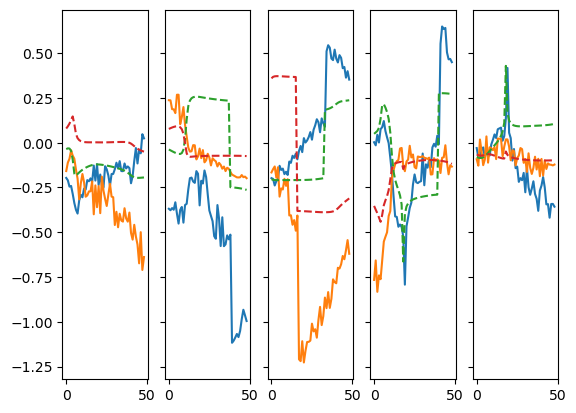

In [ ]:
fig,axs = plt.subplots(1,min(params['num_vars'],6), sharey=True)
for i,ax in enumerate(axs.flatten()):
    ax.plot(out[2][i,:,-2:].cpu());
    ax.plot(ds_train.datalist[0].node_feats[i,1:,-2:].cpu(), '--');

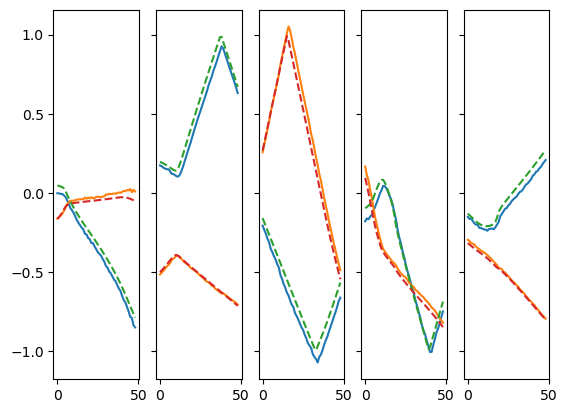

In [ ]:
fig,axs = plt.subplots(1,min(params['num_vars'],6), sharey=True)
for i,ax in enumerate(axs.flatten()):
    ax.plot(out[2][i,:,:2].cpu());
    ax.plot(ds_train.datalist[0].node_feats[i,1:,:2].cpu(), '--');

In [ ]:
model

DNRI(
  (encoder): DNRI_Encoder(
    (mlp1): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=4, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
        (5): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (mlp1_e): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=3, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ELU(alpha=1.0, inplace=True)
        (5): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (mlp2): RefNRIMLP(
      (model): Sequential(
        (0): Linear(in_features=768, out_features=256, bias=True)
        (1): ELU(alpha=1.0, inplace=True)
        (2): Dropout(p=0.0, inpla

## Activations histograms

Inspecting activations and gradients distributions at init and after training,
we can get an idea of what layers are helping or not to the learning.

In [ ]:
def disable_elu_inplace(model: nn.Module) -> None:
    """
    Recursively replace every nn.ELU(inplace=True) with nn.ELU(inplace=False).
    The function mutates the model in place.
    """
    for name, child in model.named_children():
        # If the child itself is an ELU, replace it if needed
        if isinstance(child, nn.ELU) and child.inplace:
            # Preserve the original alpha value
            new_elu = nn.ELU(alpha=child.alpha, inplace=False)
            setattr(model, name, new_elu)
        else:
            # Recurse into containers (Sequential, ModuleList, custom sub‑modules, …)
            disable_elu_inplace(child)

In [ ]:
import torch
from collections import OrderedDict, namedtuple
from typing import Iterable, Dict, Union

# ----------------------------------------------------------------------
# Container that holds everything we want to return for a layer.
# ----------------------------------------------------------------------
LayerInfo = namedtuple(
    "LayerInfo",
    ["layer_type", "activation", "grad_wrt_output"]
)

def get_activations_and_grads(
    model: torch.nn.Module,
    inputs: Union[torch.Tensor, tuple, list],
    layers: Iterable[str] = None,
    detach_act: bool = True,
    detach_grad: bool = True,
    cpu_act: bool = True,
    cpu_grad: bool = True,
) -> Dict[str, LayerInfo]:
    """
    Run a forward‑pass, compute a loss, back‑propagate, and collect
    (layer_type, activation, grad_wrt_output) for the requested layers.

    Parameters
    ----------
    model : torch.nn.Module
        The network to probe.
    inputs : Tensor or (tuple/list of Tensors)
        Input(s) fed to the model.
    loss_fn : callable
        Function that takes ``(model_output, targets)`` and returns a scalar loss.
        Typical examples: ``torch.nn.functional.mse_loss`` or a custom loss.
    targets : Tensor or (tuple/list of Tensors)
        Ground‑truth values used by ``loss_fn``.
    layers : iterable of str, optional
        Names of sub‑modules to record.  If ``None`` all *leaf* modules are used.
    detach_act / detach_grad : bool, default=True
        Whether to detach the stored tensors from the autograd graph.
    cpu_act / cpu_grad : bool, default=True
        Whether to move the stored tensors to CPU.

    Returns
    -------
    dict
        Mapping ``layer_name → LayerInfo(layer_type, activation, grad_wrt_output)``.
    """

    disable_elu_inplace(model)
    # --------------------------------------------------------------
    # 1️⃣  Determine which modules we will hook.
    # --------------------------------------------------------------
    if layers is None:
        # All leaf modules (no children) – this mirrors the earlier helper.
        layers = [
            name for name, mod in model.named_modules()
            if len(list(mod.children())) == 0
        ]

    # --------------------------------------------------------------
    # 2️⃣  Containers for forward activations and backward grads.
    # --------------------------------------------------------------
    fwd_store: Dict[str, torch.Tensor] = {}
    bwd_store: Dict[str, torch.Tensor] = {}

    # --------------------------------------------------------------
    # 3️⃣  Forward hook – saves the output.
    # --------------------------------------------------------------
    def _forward_hook(name, module):
        def fn(_, __, output):
            act = output[0].clone() if isinstance(output, tuple) else output.clone()
            act = act.detach() if detach_act else act
            act = act.cpu() if cpu_act else act
            fwd_store[name] = act
        return fn

    # --------------------------------------------------------------
    # 4️⃣  Backward hook – saves the gradient w.r.t. the output.
    # --------------------------------------------------------------
    def _backward_hook(name, module):
        def fn(_, grad_input, grad_output):
            # grad_output is a tuple; for most layers it has length 1.
            g = grad_output[0].clone()
            g = g.detach() if detach_grad else g
            g = g.cpu() if cpu_grad else g
            bwd_store[name] = g
        return fn

    # --------------------------------------------------------------
    # 5️⃣  Register both hooks.
    # --------------------------------------------------------------
    handles = []
    for name, module in model.named_modules():
        if name in layers:
            handles.append(module.register_forward_hook(_forward_hook(name, module)))
            handles.append(module.register_full_backward_hook(_backward_hook(name, module)))

    # --------------------------------------------------------------
    # 6️⃣  Forward pass, loss computation, backward pass.
    # --------------------------------------------------------------
    try:
        model.train()                     # keep dropout/batchnorm in training mode (if you want eval, call .eval() beforehand)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.0)   # dummy optimizer – we only need .step() to clear grads
        optimizer.zero_grad()

        # Forward and
        # Compute loss
        loss, *_ = model.calculate_loss(inputs)

        # Backward – this triggers the backward hooks
        loss.backward()

    # --------------------------------------------------------------
    # 7️⃣  Clean‑up – remove hooks so the model returns to normal.
    # --------------------------------------------------------------
    finally:
        for h in handles: h.remove()

    # --------------------------------------------------------------
    # 8️⃣  Assemble the final dictionary.
    # --------------------------------------------------------------
    result: Dict[str, LayerInfo] = OrderedDict()
    for name, module in model.named_modules():
        if name in layers:
            result[name] = LayerInfo(
                layer_type=type(module).__name__,
                activation=fwd_store.get(name),
                grad_wrt_output=bwd_store.get(name)
            )
    return result

In [ ]:
acts_all = get_activations_and_grads(model.cuda(), b.cuda())   # no `layers=` argument → everything
for name, tensor in acts_all.items():
    print(name, tensor)

encoder.mlp1.model.0 LayerInfo(layer_type='Linear', activation=tensor([[[ 0.1259,  0.0786,  0.0854,  ...,  0.0993,  0.0836,  0.0741],
         [ 0.1278,  0.0773,  0.0836,  ...,  0.1014,  0.0808,  0.0719],
         [ 0.1298,  0.0758,  0.0818,  ...,  0.1030,  0.0782,  0.0697],
         ...,
         [ 0.2159,  0.1249,  0.1046,  ...,  0.0660,  0.1097,  0.0790],
         [ 0.2168,  0.1278,  0.1076,  ...,  0.0663,  0.1080,  0.0829],
         [ 0.2176,  0.1307,  0.1105,  ...,  0.0666,  0.1062,  0.0868]],

        [[ 0.0735,  0.0960,  0.0890,  ...,  0.1127,  0.1066,  0.0951],
         [ 0.0733,  0.1039,  0.0914,  ...,  0.1106,  0.1155,  0.0987],
         [ 0.0728,  0.1083,  0.0938,  ...,  0.1081,  0.1207,  0.1018],
         ...,
         [-0.0357,  0.1694,  0.1285,  ...,  0.1547,  0.1328,  0.1871],
         [-0.0346,  0.1718,  0.1312,  ...,  0.1545,  0.1316,  0.1904],
         [-0.0335,  0.1742,  0.1339,  ...,  0.1542,  0.1303,  0.1937]],

        [[ 0.1002,  0.0953,  0.0981,  ...,  0.0913,  

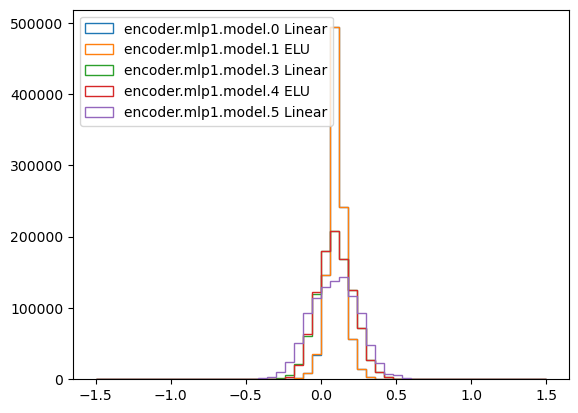

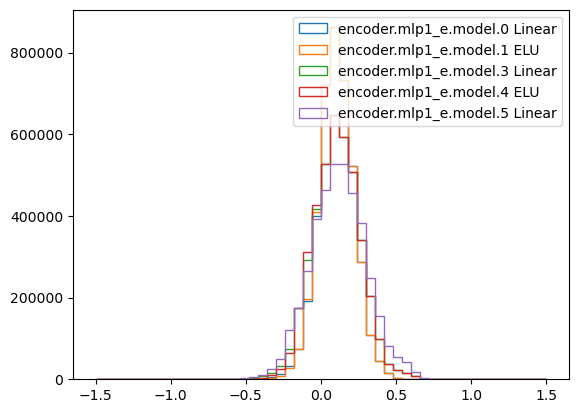

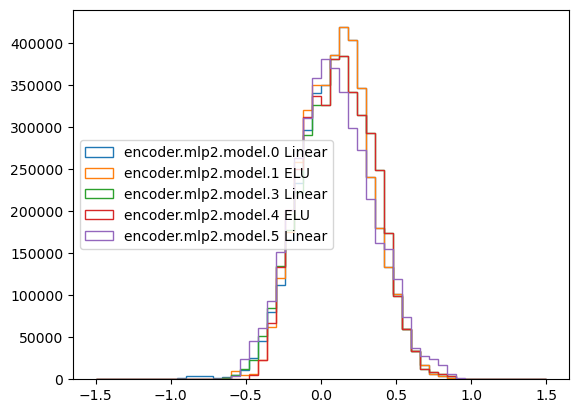

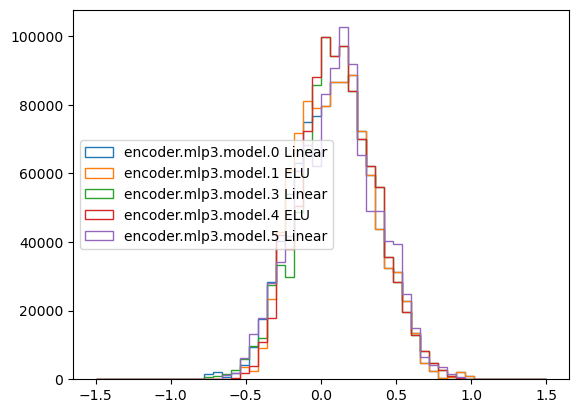

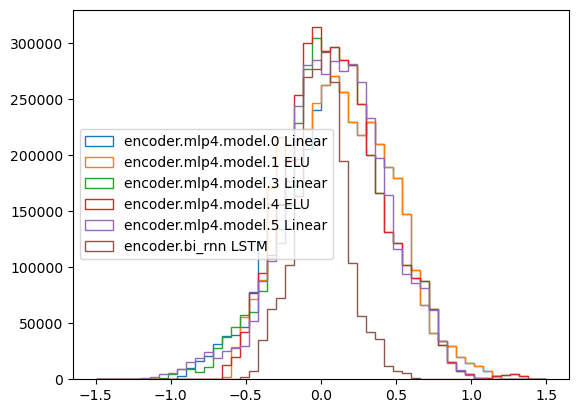

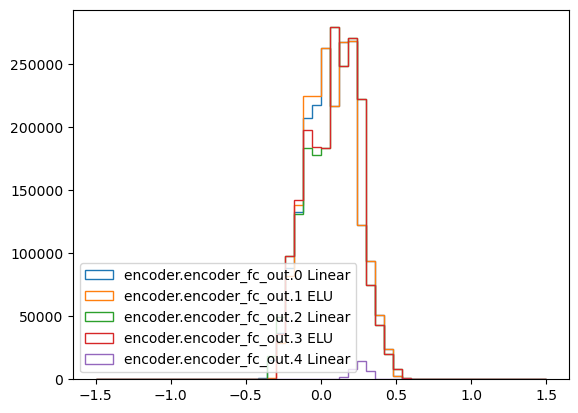

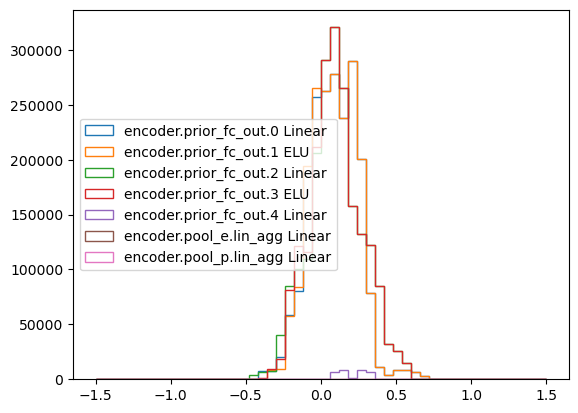

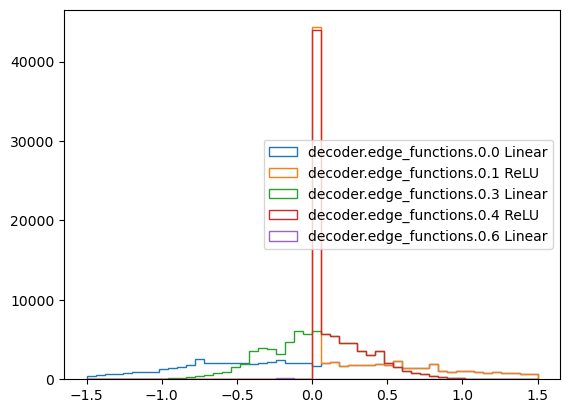

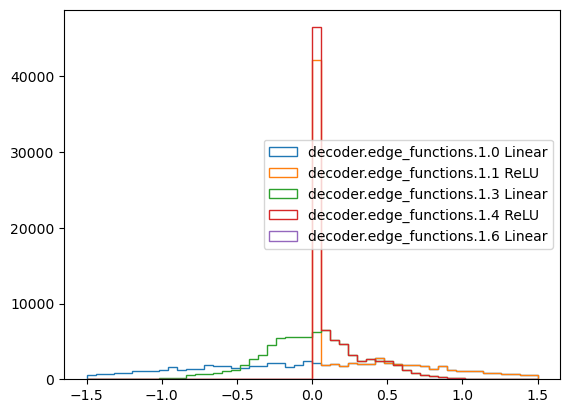

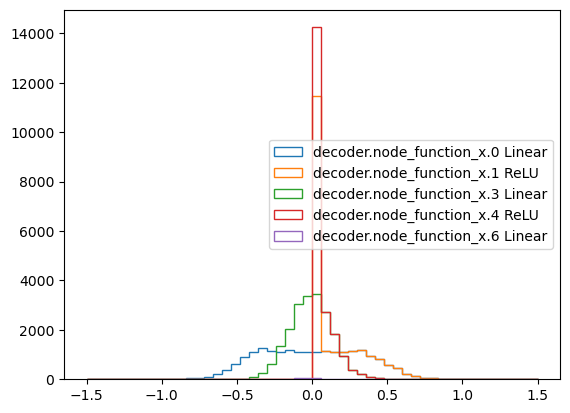

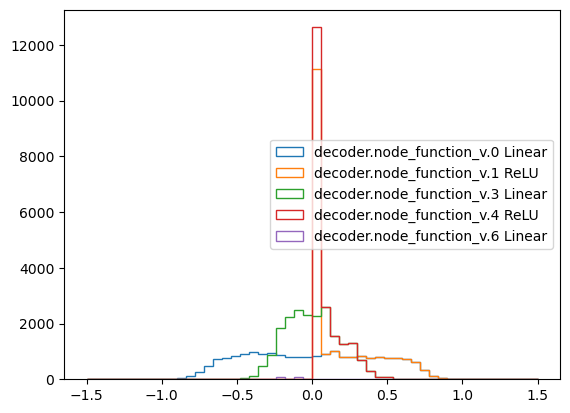

In [ ]:
for name, info in acts_all.items():
    if info.layer_type=='Dropout': continue # skip dropout layers
    if name[-1]=='0': plt.figure()
    tensor = info.activation
    plt.hist(tensor.numpy().reshape(-1), bins=50, range=[-1.5,1.5],
             histtype='step', label=name+' '+info.layer_type,);
    plt.legend();

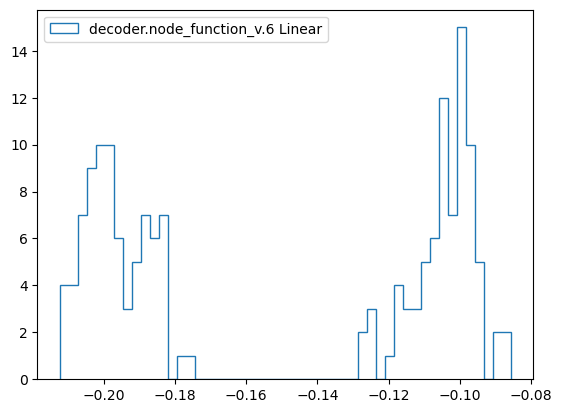

In [ ]:
name = 'decoder.node_function_v.6'
info = acts_all[name]
tensor = info.activation
plt.hist(tensor.numpy().reshape(-1), bins=50, #range=[-1,1],
         histtype='step', label=name+' '+info.layer_type,);
plt.legend();

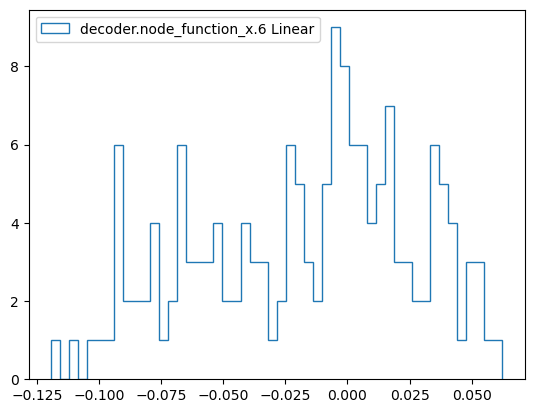

In [ ]:
name = 'decoder.node_function_x.6'
info = acts_all[name]
tensor = info.activation
plt.hist(tensor.numpy().reshape(-1), bins=50, #range=[-1,1],
         histtype='step', label=name+' '+info.layer_type,);
plt.legend();

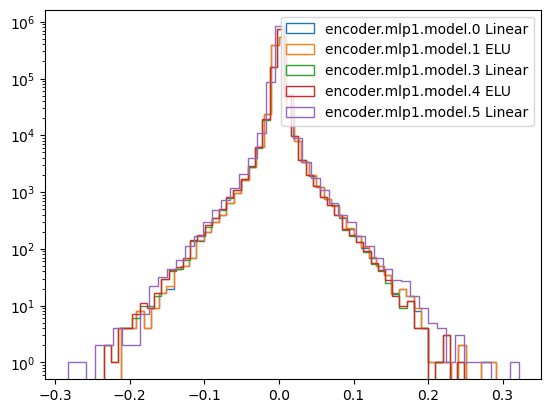

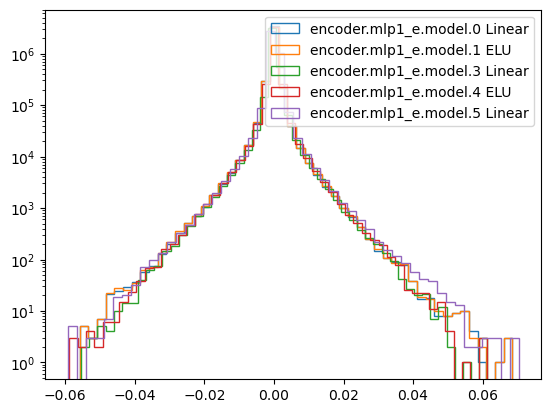

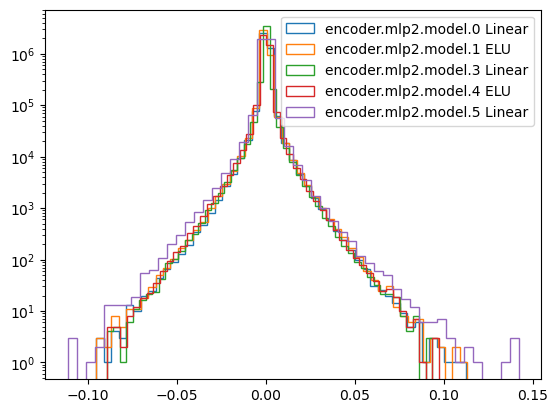

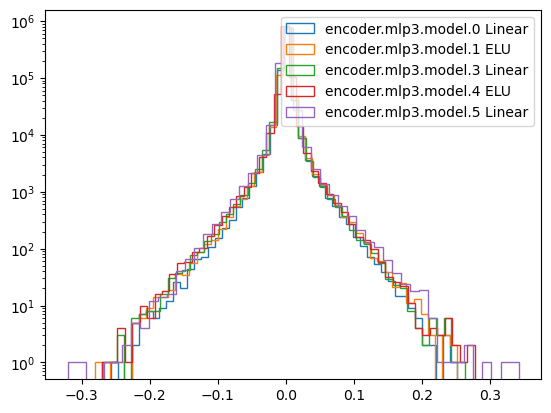

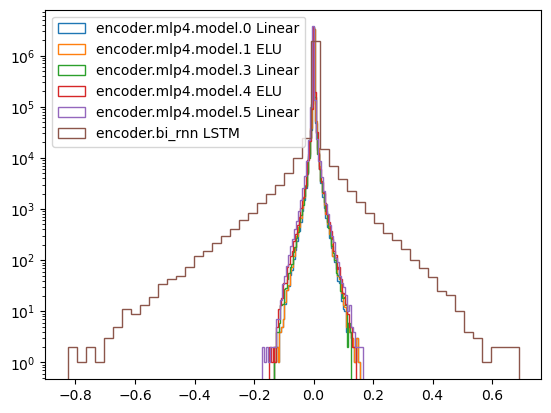

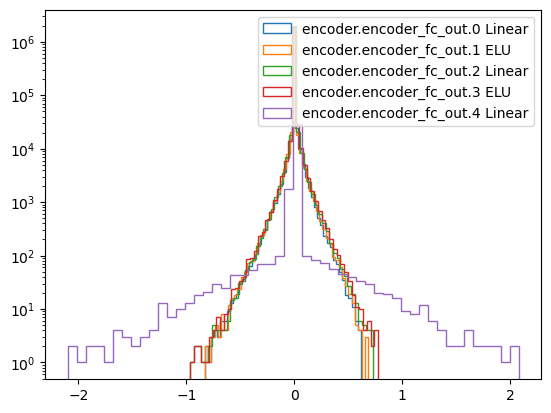

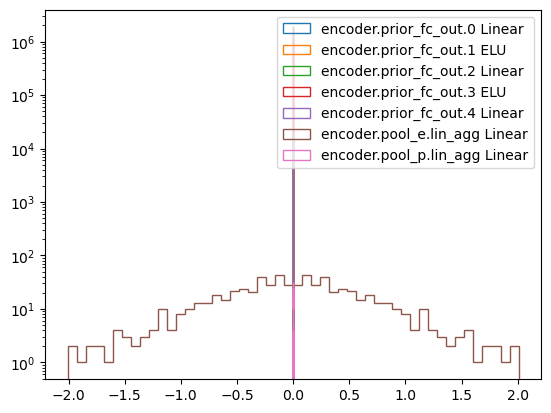

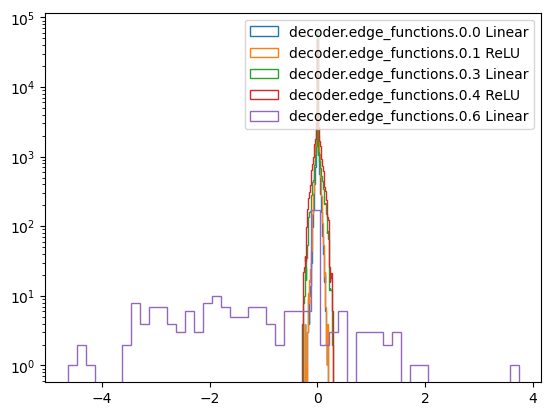

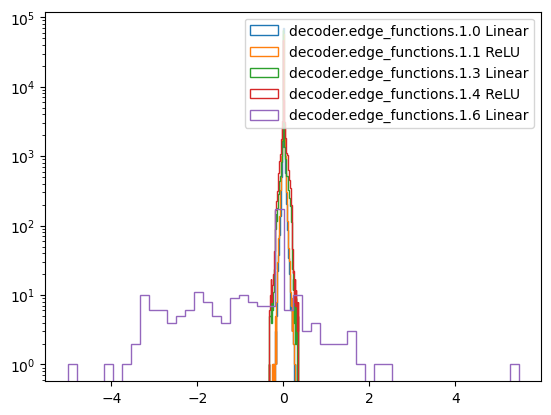

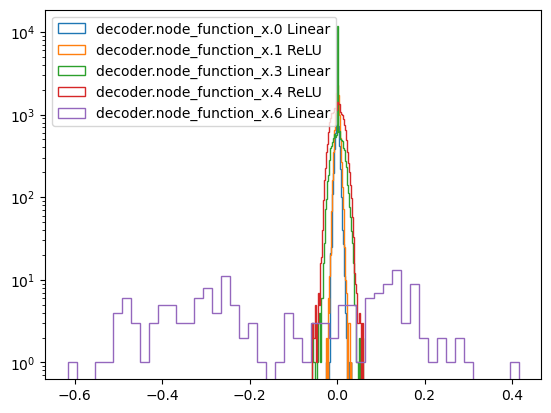

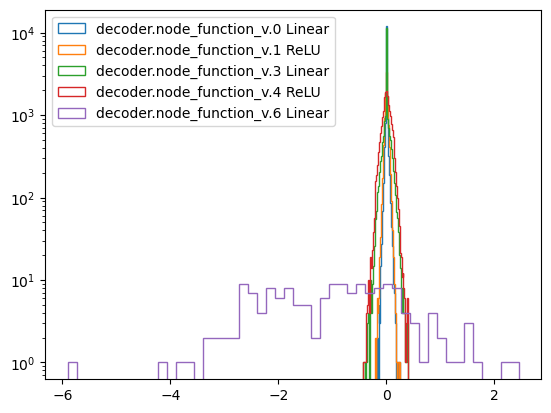

In [ ]:
for name, info in acts_all.items():
    if info.layer_type=='Dropout': continue # skip dropout layers
    if info.grad_wrt_output is None: continue
    if name[-1]=='0': plt.figure();
    tensor = info.grad_wrt_output
    plt.hist(tensor.numpy().reshape(-1), bins=50,log=True, #range=[-1,1],
             histtype='step', label=name+' '+info.layer_type,);
    plt.legend();

# Train

In [ ]:
def get_edges_count_table(edges, dim=1):
    edges_table = np.zeros((params['num_edge_types'],params['num_vars']*(params['num_vars']-1)), dtype=int)
    idx = [slice(None)]*dim
    for i in range(edges.shape[dim]):
        u,c = edges[*(*idx,i)].unique(return_counts=True,)
        for j,j_c in zip(u,c):
            edges_table[int(j),i] = j_c
    return edges_table

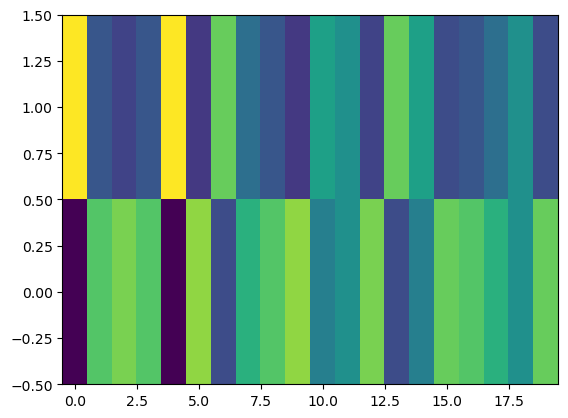

In [ ]:
plt.imshow(get_edges_count_table(ds_train.edges[:,1:], dim=2),origin='lower', aspect='auto', interpolation='none');

In [ ]:
import time

def build_scheduler(opt, params):
    lr_decay_factor, lr_decay_steps = params.get('lr_decay_factor'), params.get('lr_decay_steps')
    return torch.optim.lr_scheduler.StepLR(opt, lr_decay_steps, lr_decay_factor) if lr_decay_factor else None

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
def f1_score_dnri(edges_pred, edges_true_):
    if isinstance(edges_true_,torch.Tensor): edges_true_ = edges_true_.numpy()
    if isinstance(edges_pred,torch.Tensor): edges_pred = edges_pred.cpu().numpy()
    return f1_score(edges_true_.reshape(-1),
                    edges_pred.reshape(-1),
                    average='macro' if edges_true_.shape[-1]>2 else 'binary'), None

def train(model, dl_train, dl_valid, params):
    gpu = params.get('gpu', False)
    accumulate_steps = params.get('accumulate_steps')  # 1
    training_scheduler = params.get('training_scheduler', None) #
    num_epochs = params.get('num_epochs', 100) # 200
    clip_grad = params.get('clip_grad', None)  #
    clip_grad_norm = params.get('clip_grad_norm', None) # None
    normalize_nll = params.get('normalize_nll', False) # True
    normalize_kl = params.get('normalize_kl', False)  # True
    continue_training = params.get('continue_training', False)  # FAlse
    lr = params['lr']  # 5e-4
    wd = params.get('wd', 0.)  #

    model_params = [param for param in model.parameters() if param.requires_grad]
    opt = torch.optim.Adam(model_params, lr=lr, weight_decay=wd)

    working_dir = params['working_dir']
    best_path = os.path.join(working_dir, 'best_model')
    checkpoint_dir = os.path.join(working_dir, 'model_checkpoint')
    training_path = os.path.join(working_dir, 'training_checkpoint')
    if continue_training: # False
        print("RESUMING TRAINING")
        model.load(checkpoint_dir)
        train_params = torch.load(training_path)
        start_epoch = train_params['epoch']
        opt.load_state_dict(train_params['optimizer'])
        # set lr
        for g in opt.param_groups:    g['lr'] = lr
        best_val_result = train_params['best_val_result']
        best_val_epoch = train_params['best_val_epoch']
        print("STARTING EPOCH: ",start_epoch)
    else: # <------------------------------------------
        start_epoch = 1
        best_val_epoch = -1
        best_val_result = 10000000
    unnorm_targ_pos = ds_valid.node_feats[...,1:, :2].reshape(-1,49,2)*ds_train.norm
    unnorm_targ_vel = ds_valid.node_feats[...,1:,2:4].reshape(-1,49,2)*ds_train.norm_v

    training_scheduler = build_scheduler(opt, params)
    end = start = 0
    train_loss, val_loss_ = [], []
    for epoch in trange(start_epoch, num_epochs+1):
        log = f"{epoch} {end-start:.2g}s"
        model.train()
        model.train_percent = epoch / num_epochs
        start = time.time()
        for batch in dl_train:
            loss, loss_nll, loss_kl = model.calculate_loss(batch, is_train=True)
            loss.backward()
            if clip_grad is not None:
                nn.utils.clip_grad_value_(model.parameters(), clip_grad)
                print('clipping gradient values')
            elif clip_grad_norm is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
                print('clipping gradient norms')
            opt.step()
            opt.zero_grad()

        if training_scheduler is not None:  training_scheduler.step()
        loss_train = loss.item()
        train_loss.append(loss.item())

        model.eval()
        opt.zero_grad()

        total_nll, total_kl, bs = 0., 0., 0
        val_loss = 0.
        all_edges, all_false_edges, all_preds = [], [], []
        with torch.no_grad():
            for batch in dl_valid:
                loss, loss_nll, loss_kl, edges, preds = model.calculate_loss(batch, is_train=False, return_edges=True)
                val_loss += loss.sum().item()*len(batch.batch)
                total_kl += loss_kl.sum().item()*len(batch.batch)
                total_nll += loss_nll.sum().item()*len(batch.batch)
                bs+=len(batch.batch)
                all_edges.append(edges)
                all_preds.append(preds)
            all_edges = torch.cat(all_edges,dim=0)
            all_preds = torch.cat(all_preds,dim=0)
            total_kl  /= bs
            total_nll /= bs
            val_loss  /= bs
            total_loss = model.kl_coef*total_kl + total_nll
            val_loss_.append(val_loss)
            # NLL positions, velocities
            unnorm_pred_pos = all_preds[...,:2]*ds_train.norm
            unnorm_pred_vel = all_preds[...,2:]*ds_train.norm_v
            # MSE is a scaled version of the nll gaussian with fixed variance
            nll_pos = ((unnorm_pred_pos-unnorm_targ_pos) ** 2 / (2 * model.prior_variance))
            nll_vel = ((unnorm_pred_vel-unnorm_targ_vel) ** 2 / (2 * model.prior_variance))

            all_edges_ = all_edges.argmax(dim=-1).float().cpu()
            if all_edges_[ds_valid.edges[:,1:].transpose(1,2).reshape(-1, all_edges.shape[-2])==1].mean()> 1.2: # sort labels
                all_edges_ = all_edges[...,[0,2,1]].argmax(dim=-1).float().cpu()
            f1, *_ = f1_score_dnri(all_edges_,
                                   ds_valid.edges[:,1:].transpose(1,2))
            cm = confusion_matrix(ds_valid.edges[:,1:].transpose(1,2).reshape(-1),
                                  all_edges_.numpy().reshape(-1),
                                  normalize='true'
                                 )
        tuning_loss = total_nll
        if tuning_loss < best_val_result:
            best_val_epoch = epoch
            best_val_result = tuning_loss
            model.save(best_path)
        model.save(checkpoint_dir)
        torch.save({'epoch':epoch+1,
                    'optimizer':opt.state_dict(),
                    'best_val_result':best_val_result,
                    'best_val_epoch':best_val_epoch,
                   }, training_path)
        print(log, f"{training_scheduler.get_last_lr()[0]:.2g}"\
              f"\t{loss_train:.4g}/{total_loss:.4g}({best_val_result:.4g}) {total_kl:.4g} {f1:.3g}")
        if model.use_supergaussian:
            print(*map(lambda x: f'{x.sum(-1).mean().item():.3g}',[nll_pos, nll_vel]),
                  "sigma=",*[f'{p.item():.3g}' for p in model.super_gaussians.sigma[:]],
                  "beta",  *[f'{p.item():.3g}' for p in model.super_gaussians.beta[:]])
        with np.printoptions(precision=1, suppress=True):
            print(cm*100)
        end = time.time()
    tab = get_edges_count_table(all_edges_.reshape(-1,params['num_vars']*(params['num_vars']-1),*all_edges_.shape[1:]), dim=1)
    plt.imshow(tab,origin='lower', aspect='auto', interpolation='none');
    plt.figure()
    plt.plot(train_loss);plt.plot(val_loss_);
    print(f"{best_val_result:.4g}|",*map(lambda x: f'{x.sum(-1).mean().item():.3g}',[nll_pos, nll_vel]),f"|{f1:.3g}|{cm[0,0]*100:.0f},{cm[1,1]*100:.0f}|")

Instantiate the model previous seeding for reproducibility.

In [ ]:
seed(params['model_seed']) # set seed for numpy, torch, cuda, and random libs
if params['gpu']:
    with dvc:
        model = DNRI(params).cuda() if params['sparse'] else DNRI(params,edge2node_mat=ds_train.edge2node_mat).cuda()
else:
    model = DNRI(params)  if params['sparse'] else DNRI(params,ds_train.edge2node_mat)

Using learned interaction net decoder.


Inspect outputs at init.

In [ ]:
with torch.inference_mode():
    loss, loss_nll, loss_kl, logits, preds = model.calculate_loss(ds_train.datalist[0], is_train=False, return_logits=True)
    loss, loss_nll, loss_kl, edges, preds = model.calculate_loss(ds_train.datalist[0], is_train=False, return_edges=True)
    print(f'{loss=:.4g} = {loss_nll=:.4g} + {loss_kl=:.4g}')
    # MSE positions, velocities
    unnorm_pred_pos = preds[...,:2]*ds_train.norm
    unnorm_pred_vel = preds[...,2:]*ds_train.norm_v
    unnorm_targ_pos = ds_train.datalist[0].node_feats[...,1:, :2].reshape(-1,49,2)*ds_train.norm
    unnorm_targ_vel = ds_train.datalist[0].node_feats[...,1:,2:4].reshape(-1,49,2)*ds_train.norm_v
    nll_pos = ((unnorm_pred_pos-unnorm_targ_pos) ** 2 / (2 * model.prior_variance)).sum(-1).mean().item()
    nll_vel = ((unnorm_pred_vel-unnorm_targ_vel) ** 2 / (2 * model.prior_variance)).sum(-1).mean().item()
    print(f'unnormed NLL: {nll_pos=:.4g}, {nll_vel=:.4g}')

    all_edges_ = edges.argmax(dim=-1).float().cpu()
    print(all_edges_.shape, ds_train.edges[0,1:].shape)
    f1, *_ = f1_score_dnri(all_edges_,
                           ds_train.edges[0,1:])
    cm = confusion_matrix(ds_train.edges[0,1:].reshape(-1),
                          all_edges_.numpy().reshape(-1),
                          normalize='true'
                         )
    print(f'F1={f1:.2g}')
    print(f'CM=')
    with np.printoptions(precision=1, suppress=True):
        print(cm*100)

loss=1297 = loss_nll=1297 + loss_kl=0.001398
unnormed NLL: nll_pos=1234, nll_vel=8.593e+04
torch.Size([20, 49]) torch.Size([49, 20])
F1=0.47
CM=
[[45.6 54.4]
 [50.5 49.5]]


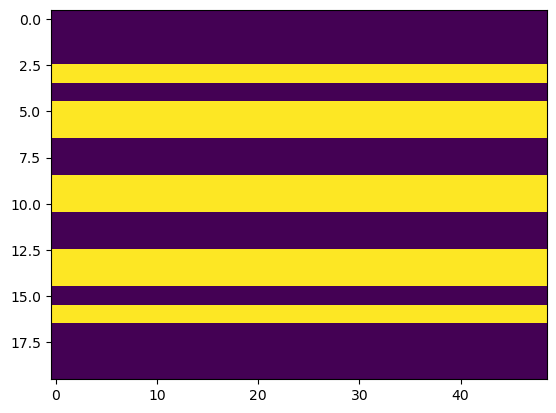

In [ ]:
plt.imshow(ds_train.edges[0,1:].cpu().numpy().T, aspect='auto', interpolation='none');

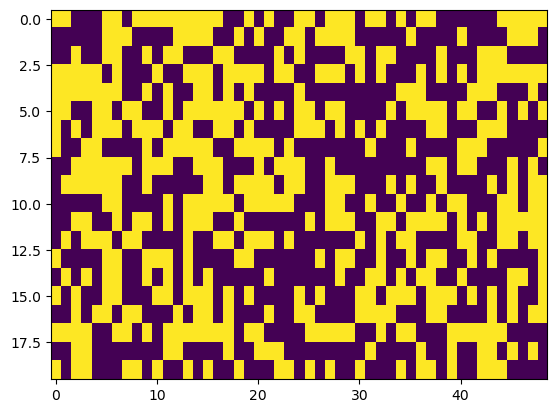

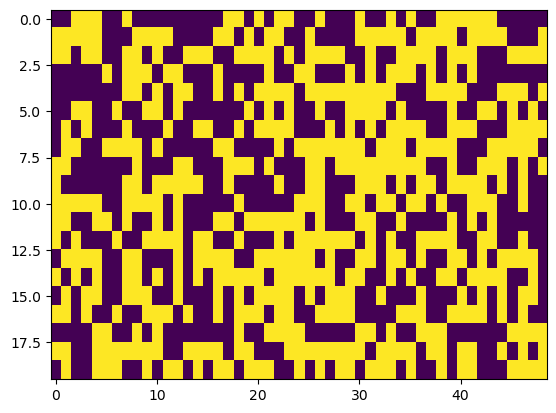

In [ ]:
for i in range(params['num_edge_types']):
    plt.figure();    plt.imshow(edges[...,i].cpu().numpy(), aspect='auto', interpolation='none');

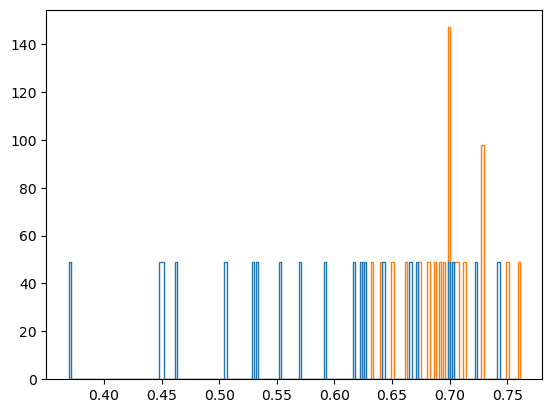

In [ ]:
plt.hist(logits.reshape(-1,params['num_edge_types']).cpu().numpy(), 200, histtype='step');

## Training

We train making a small warm-up and annealing Gumbel temperature.
TODO implement a proper one-cycle lr schedule and annealing schedule.

In [ ]:
params['lr']=5e-6

In [ ]:
params['continue_training'] = False

In [ ]:
params['num_epochs']=20  # warm-up

In [ ]:
params['gumbel_temp']=model.gumbel_temp=1.5

In [ ]:
assert not model.use_supergaussian
assert not model.add_uniform_prior
assert model.encoder.static

  0%|          | 0/20 [00:00<?, ?it/s]

1 0s 5e-06	1063/872.1(872) 0.1031 0.334
[[  0. 100.]
 [  0. 100.]]
2 8.5s 5e-06	737.4/701.5(701.2) 0.2736 0.334
[[  0. 100.]
 [  0. 100.]]
3 9.4s 5e-06	786/606.3(605.9) 0.3669 0.334
[[  0. 100.]
 [  0. 100.]]
4 9.8s 5e-06	610.6/552.9(552.5) 0.4024 0.334
[[  0. 100.]
 [  0. 100.]]
5 9.9s 5e-06	525.1/510.6(510.2) 0.4068 0.334
[[  0. 100.]
 [  0. 100.]]
6 9.4s 5e-06	586.6/470.4(470) 0.3953 0.334
[[  0. 100.]
 [  0. 100.]]
7 8.5s 5e-06	371.4/434.5(434.1) 0.3781 0.334
[[  0. 100.]
 [  0. 100.]]
8 7.8s 5e-06	447.3/402.9(402.5) 0.3606 0.334
[[  0. 100.]
 [  0. 100.]]
9 8.8s 5e-06	380.5/375.1(374.8) 0.3432 0.334
[[  0. 100.]
 [  0. 100.]]
10 9.5s 5e-06	312/350.7(350.4) 0.3254 0.334
[[  0. 100.]
 [  0. 100.]]
11 9.8s 5e-06	235.8/329.3(329) 0.3069 0.334
[[  0. 100.]
 [  0. 100.]]
12 10s 5e-06	395.3/310.5(310.2) 0.2861 0.334
[[  0. 100.]
 [  0. 100.]]
13 9.9s 5e-06	220.3/293.8(293.6) 0.2648 0.334
[[  0. 100.]
 [  0. 100.]]
14 9.9s 5e-06	316.3/279.6(279.4) 0.246 0.334
[[  0. 100.]
 [  0. 100.]]
15

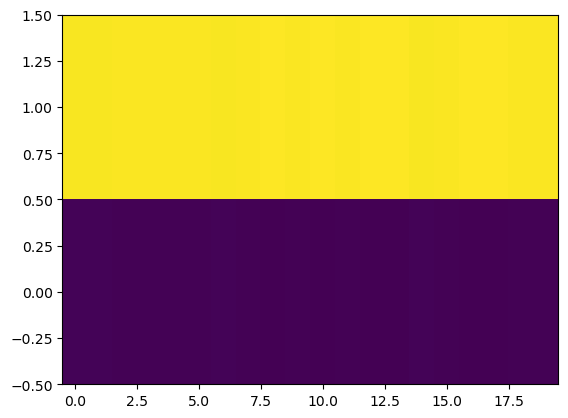

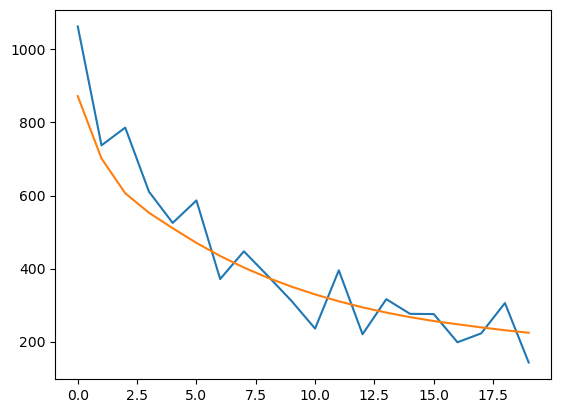

In [ ]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [ ]:
params['lr']=1e-5

In [ ]:
params['num_epochs']=40

  0%|          | 0/40 [00:00<?, ?it/s]

1 0s 1e-05	242.6/199.3(199) 0.2097 0.36
[[ 5.6 94.4]
 [11.9 88.1]]
2 10s 1e-05	133.4/190.9(190.7) 0.2297 0.364
[[ 6.6 93.4]
 [13.7 86.3]]
3 10s 1e-05	237/186.5(186.3) 0.2687 0.335
[[ 0.4 99.6]
 [ 1.6 98.4]]
4 10s 1e-05	161.7/183.7(183.5) 0.2742 0.334
[[  0. 100.]
 [  0. 100.]]
5 9.5s 1e-05	143.8/181.1(180.9) 0.2433 0.334
[[  0. 100.]
 [  0. 100.]]
6 9s 1e-05	84.62/178.8(178.6) 0.205 0.334
[[  0. 100.]
 [  0. 100.]]
7 8.3s 1e-05	311.9/176.8(176.6) 0.1687 0.334
[[  0. 100.]
 [  0. 100.]]
8 8s 1e-05	207.5/175(174.9) 0.1356 0.334
[[  0. 100.]
 [  0. 100.]]
9 8.9s 1e-05	93.77/173.3(173.2) 0.1181 0.334
[[  0. 100.]
 [  0. 100.]]
10 9.9s 1e-05	276.7/172(171.9) 0.1016 0.334
[[  0. 100.]
 [  0. 100.]]
11 10s 1e-05	120.2/170.6(170.6) 0.09026 0.334
[[  0. 100.]
 [  0. 100.]]
12 10s 1e-05	122.5/169.5(169.4) 0.07964 0.334
[[  0. 100.]
 [  0. 100.]]
13 10s 1e-05	145.5/168.6(168.5) 0.07104 0.334
[[  0. 100.]
 [  0. 100.]]
14 10s 1e-05	136.1/167.9(167.8) 0.06647 0.334
[[  0. 100.]
 [  0. 100.]]
15 9.7

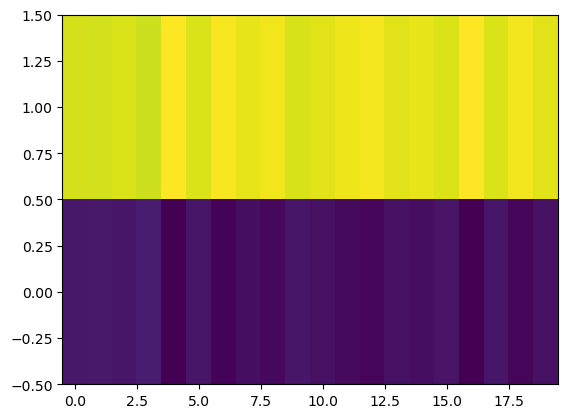

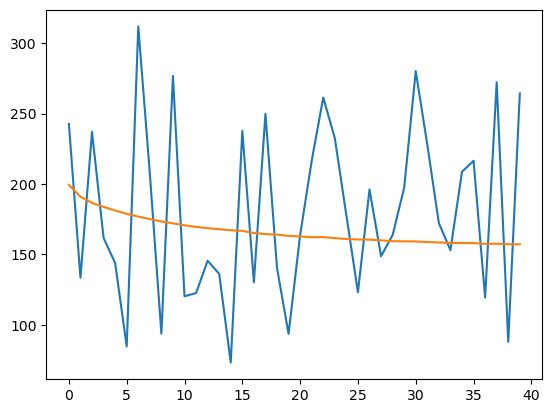

In [ ]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [ ]:
params['lr']=5e-5

In [ ]:
params['num_epochs']=100

  0%|          | 0/100 [00:00<?, ?it/s]

1 0s 5e-05	306.7/157.1(157) 0.04962 0.395
[[16.8 83.2]
 [29.1 70.9]]
2 10s 5e-05	156.8/156.5(156.5) 0.03566 0.391
[[15.1 84.9]
 [26.8 73.2]]
3 10s 5e-05	144.5/155.7(155.7) 0.0296 0.392
[[16.2 83.8]
 [28.5 71.5]]
4 9.9s 5e-05	274.3/155.4(155.4) 0.01544 0.359
[[ 5.5 94.5]
 [12.  88. ]]
5 9.7s 5e-05	226.5/154.2(154.2) 0.04376 0.4
[[20.4 79.6]
 [34.3 65.7]]
6 9.4s 5e-05	176.2/153.8(153.8) 0.02441 0.384
[[13.9 86.1]
 [26.1 73.9]]
7 9.5s 5e-05	171.9/153.4(153.4) 0.02799 0.398
[[19.9 80.1]
 [34.1 65.9]]
8 9s 5e-05	94.24/153.5(153.4) 0.03043 0.394
[[20.2 79.8]
 [35.6 64.4]]
9 7.6s 5e-05	247.5/151.2(151.1) 0.04182 0.373
[[39.  61. ]
 [64.3 35.7]]
10 8.3s 5e-05	284.5/151.5(151.1) 0.03976 0.329
[[62.7 37.3]
 [88.2 11.8]]
11 9.7s 5e-05	154.2/150.5(150.5) 0.02799 0.359
[[49.7 50.3]
 [75.7 24.3]]
12 9.6s 5e-05	183.6/150.2(150.2) 0.02271 0.379
[[36.7 63.3]
 [61.  39. ]]
13 9.7s 5e-05	158/149.1(149.1) 0.02234 0.374
[[43.1 56.9]
 [67.9 32.1]]
14 10s 5e-05	205.9/148.9(148.8) 0.01908 0.369
[[44.4 55.6]
 

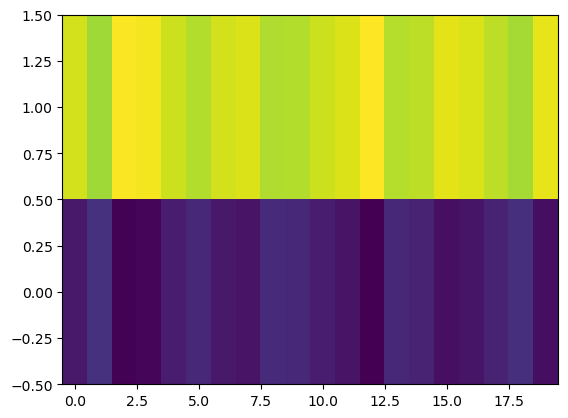

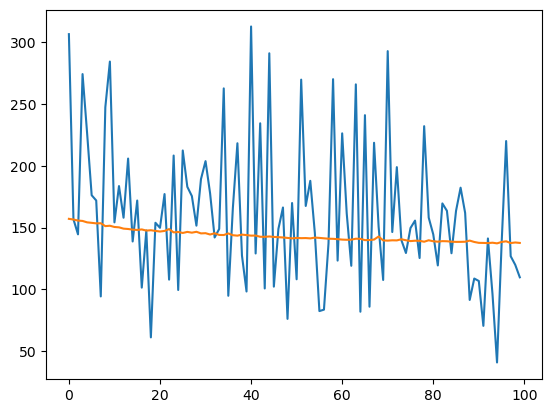

In [ ]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [ ]:
params['continue_training'] = True

In [ ]:
params['num_epochs']+=100

In [ ]:
params['gumbel_temp']=0.5
model.gumbel_temp=0.5

RESUMING TRAINING
STARTING EPOCH:  101


  0%|          | 0/100 [00:00<?, ?it/s]

101 0s 5e-05	65.09/137.8(137.2) 0.06211 0.354
[[15.6 84.4]
 [37.9 62.1]]
102 9.3s 5e-05	115.8/137.2(137.2) 0.05178 0.369
[[18.6 81.4]
 [39.2 60.8]]
103 8.7s 5e-05	130.2/137.5(137.2) 0.0647 0.352
[[27.5 72.5]
 [56.2 43.8]]
104 7.9s 5e-05	221.7/137.1(137) 0.0769 0.347
[[30.5 69.5]
 [60.8 39.2]]
105 8.8s 5e-05	200.5/137.2(137) 0.06375 0.357
[[29.  71. ]
 [56.9 43.1]]
106 9.3s 5e-05	141.7/137.7(137) 0.05886 0.37
[[22.6 77.4]
 [45.3 54.7]]
107 9.6s 5e-05	209.5/137.6(137) 0.09079 0.355
[[32.9 67.1]
 [61.8 38.2]]
108 9.7s 5e-05	140.7/137.2(137) 0.06973 0.357
[[24.2 75.8]
 [50.9 49.1]]
109 9.8s 5e-05	137.3/137.1(137) 0.07433 0.349
[[26.3 73.7]
 [55.6 44.4]]
110 10s 5e-05	94.93/136.8(136.7) 0.1055 0.35
[[21.4 78.6]
 [48.5 51.5]]
111 9.8s 5e-05	190.6/136.9(136.7) 0.06509 0.357
[[19.7 80.3]
 [44.2 55.8]]
112 9.8s 5e-05	196.2/136.7(136.6) 0.07242 0.354
[[26.7 73.3]
 [54.9 45.1]]
113 9.6s 5e-05	180.2/136.6(136.6) 0.0652 0.351
[[20.2 79.8]
 [46.6 53.4]]
114 9.2s 5e-05	241.9/136.6(136.5) 0.07861 0.36

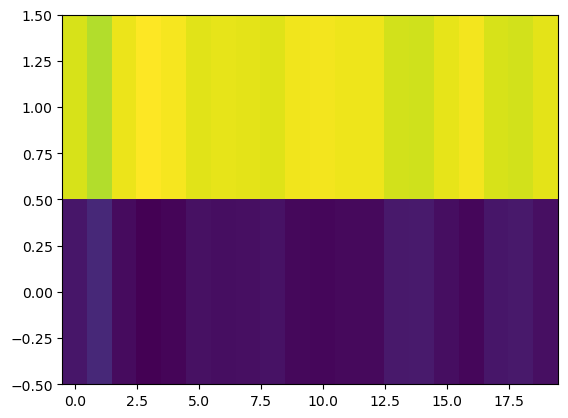

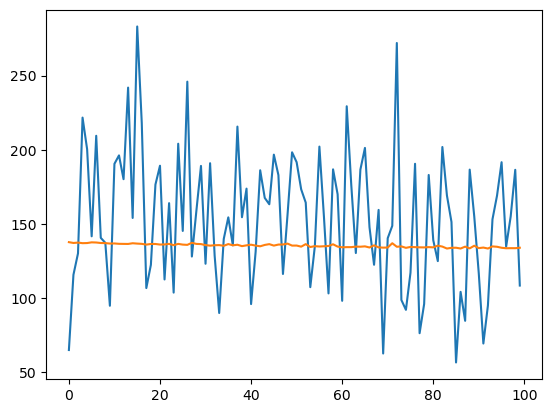

In [ ]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [ ]:
params['gumbel_temp']=0.1
model.gumbel_temp=0.1

In [ ]:
params['num_epochs']+=100

RESUMING TRAINING
STARTING EPOCH:  201


  0%|          | 0/100 [00:00<?, ?it/s]

201 0s 5e-05	166.9/134(133.4) 0.07394 0.355
[[11. 89.]
 [28. 72.]]
202 9.9s 5e-05	212.9/134.5(133.4) 0.08063 0.347
[[13.8 86.2]
 [36.3 63.7]]
203 10s 5e-05	138.8/135.7(133.4) 0.06543 0.344
[[ 6.3 93.7]
 [19.7 80.3]]
204 9.8s 5e-05	110.6/134.1(133.4) 0.09996 0.348
[[18.9 81.1]
 [45.1 54.9]]
205 9.4s 5e-05	179/135.8(133.4) 0.1007 0.349
[[ 6.5 93.5]
 [18.5 81.5]]
206 9s 5e-05	150.6/136.2(133.4) 0.1272 0.355
[[21.7 78.3]
 [47.7 52.3]]
207 8.5s 5e-05	225.1/135.1(133.4) 0.09355 0.347
[[ 8.6 91.4]
 [24.9 75.1]]
208 7.9s 5e-05	84.46/135.1(133.4) 0.09961 0.353
[[15.4 84.6]
 [37.7 62.3]]
209 8.8s 5e-05	187/134.1(133.4) 0.09528 0.35
[[16.  84. ]
 [39.6 60.4]]
210 9.6s 5e-05	103.1/134.2(133.4) 0.09598 0.34
[[15.2 84.8]
 [40.9 59.1]]
211 9.8s 5e-05	135/133.4(133.2) 0.1061 0.354
[[22.4 77.6]
 [48.8 51.2]]
212 10s 5e-05	170.9/133.7(133.2) 0.113 0.349
[[19.1 80.9]
 [45.2 54.8]]
213 10s 5e-05	90.14/134.7(133.2) 0.08603 0.346
[[11.9 88.1]
 [32.9 67.1]]
214 10s 5e-05	152.6/133.3(133.2) 0.1121 0.351
[[17.

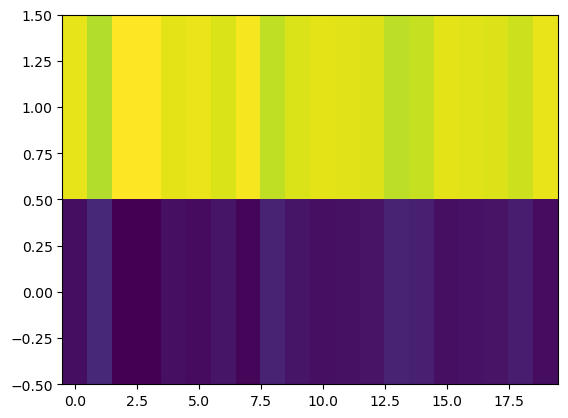

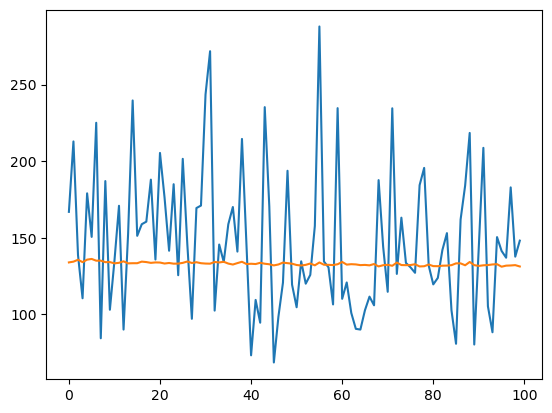

In [ ]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [ ]:
params['gumbel_temp']=0.05
model.gumbel_temp=0.05

In [ ]:
params['num_epochs']+=100

RESUMING TRAINING
STARTING EPOCH:  301


  0%|          | 0/100 [00:00<?, ?it/s]

301 0s 5e-05	89.09/132.6(131.1) 0.0933 0.342
[[ 7.4 92.6]
 [23.4 76.6]]
302 10s 5e-05	268.5/131.4(131.1) 0.09225 0.336
[[15.7 84.3]
 [42.9 57.1]]
303 9.5s 5e-05	125.1/131.6(131.1) 0.09744 0.35
[[22.7 77.3]
 [50.5 49.5]]
304 9.5s 5e-05	171.3/131.9(131.1) 0.1007 0.351
[[18.1 81.9]
 [43.  57. ]]
305 8.6s 5e-05	141.5/131.2(131) 0.1079 0.355
[[16.  84. ]
 [38.4 61.6]]
306 7.7s 5e-05	121/131(130.9) 0.09715 0.35
[[14.5 85.5]
 [36.8 63.2]]
307 9.1s 5e-05	140.4/131.1(130.9) 0.1159 0.348
[[13.  87. ]
 [34.4 65.6]]
308 9.7s 5e-05	111.4/131.2(130.9) 0.1172 0.355
[[14.  86. ]
 [34.7 65.3]]
309 10s 5e-05	231.6/131.4(130.9) 0.07944 0.343
[[ 6.6 93.4]
 [20.7 79.3]]
310 10s 5e-05	223.2/131.6(130.9) 0.122 0.345
[[17.8 82.2]
 [44.2 55.8]]
311 10s 5e-05	233.1/132.6(130.9) 0.09922 0.339
[[14.9 85.1]
 [40.6 59.4]]
312 10s 5e-05	150.3/130.9(130.8) 0.1039 0.347
[[17.9 82.1]
 [43.8 56.2]]
313 9.7s 5e-05	167.8/132(130.8) 0.09112 0.343
[[11.8 88.2]
 [33.7 66.3]]
314 9.6s 5e-05	139.5/132.2(130.8) 0.08868 0.344
[[

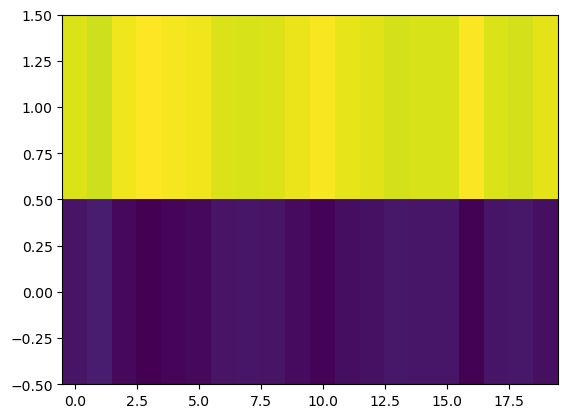

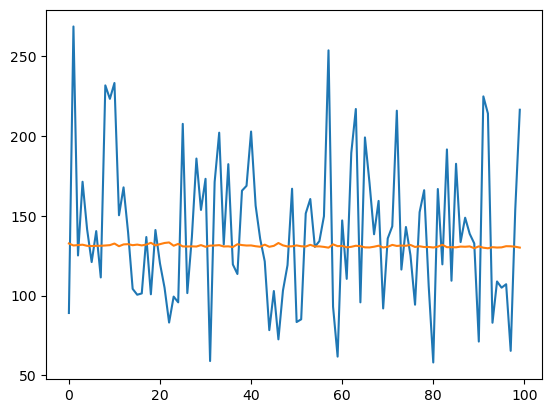

In [ ]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [ ]:
params['lr']=1e-5

In [ ]:
params['num_epochs']+=100

RESUMING TRAINING
STARTING EPOCH:  401


  0%|          | 0/100 [00:00<?, ?it/s]

401 0s 1e-05	131.5/129.8(129.5) 0.07364 0.343
[[10.2 89.8]
 [30.  70. ]]
402 10s 1e-05	170.3/129.8(129.5) 0.07671 0.342
[[11.5 88.5]
 [33.  67. ]]
403 10s 1e-05	97.1/129.6(129.5) 0.07772 0.342
[[11.8 88.2]
 [33.6 66.4]]
404 10s 1e-05	120.6/129.7(129.5) 0.07611 0.342
[[11.8 88.2]
 [33.6 66.4]]
405 9.9s 1e-05	178.2/129.6(129.5) 0.07825 0.343
[[13.  87. ]
 [36.1 63.9]]
406 9.8s 1e-05	196.4/129.6(129.5) 0.07579 0.341
[[12.3 87.7]
 [34.9 65.1]]
407 9.4s 1e-05	154.6/129.7(129.5) 0.06853 0.342
[[ 9.8 90.2]
 [29.5 70.5]]
408 8.8s 1e-05	141.4/129.8(129.5) 0.06674 0.341
[[ 9.3 90.7]
 [28.4 71.6]]
409 7.8s 1e-05	85.7/129.7(129.5) 0.0673 0.342
[[10.  90. ]
 [29.7 70.3]]
410 8.6s 1e-05	148.7/129.6(129.5) 0.06978 0.343
[[10.7 89.3]
 [31.2 68.8]]
411 9.5s 1e-05	101.1/130(129.5) 0.06492 0.343
[[ 8.4 91.6]
 [25.4 74.6]]
412 9.7s 1e-05	190.4/129.9(129.5) 0.06431 0.343
[[ 8.4 91.6]
 [25.6 74.4]]
413 8.2s 1e-05	105.4/130(129.5) 0.06635 0.343
[[ 9.4 90.6]
 [28.2 71.8]]
414 12s 1e-05	213.3/129.7(129.5) 0.07

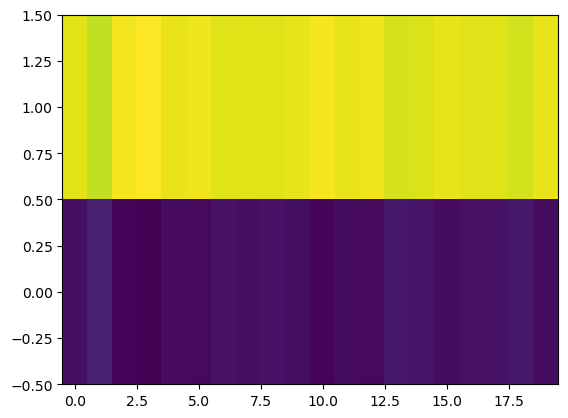

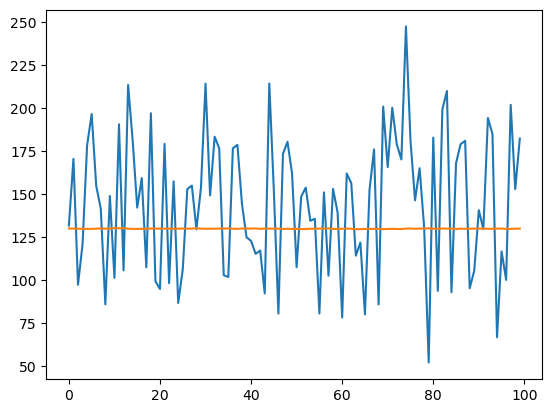

In [ ]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [ ]:
params['num_epochs']+=100

RESUMING TRAINING
STARTING EPOCH:  501


  0%|          | 0/100 [00:00<?, ?it/s]

501 0s 1e-05	91.99/129.6(129.3) 0.07289 0.343
[[10.3 89.7]
 [30.2 69.8]]
502 6.5s 1e-05	150.1/129.8(129.3) 0.07654 0.343
[[11.4 88.6]
 [32.6 67.4]]
503 6.8s 1e-05	78.09/129.7(129.3) 0.07269 0.342
[[10.4 89.6]
 [30.8 69.2]]
504 6.6s 1e-05	106.5/129.7(129.3) 0.07313 0.343
[[10.9 89.1]
 [31.5 68.5]]
505 6.7s 1e-05	157/129.8(129.3) 0.07435 0.342
[[11.2 88.8]
 [32.5 67.5]]
506 6.8s 1e-05	194.8/129.7(129.3) 0.07851 0.342
[[11.9 88.1]
 [33.9 66.1]]
507 6.8s 1e-05	100.8/129.7(129.3) 0.07963 0.343
[[12.  88. ]
 [33.9 66.1]]
508 6.1s 1e-05	123.5/129.7(129.3) 0.08343 0.342
[[12.9 87.1]
 [36.  64. ]]
509 6.4s 1e-05	174.5/129.7(129.3) 0.08263 0.343
[[12.7 87.3]
 [35.3 64.7]]
510 6.8s 1e-05	140.7/129.7(129.3) 0.07672 0.343
[[11.2 88.8]
 [32.  68. ]]
511 6.8s 1e-05	89.14/130.1(129.3) 0.07824 0.345
[[12.1 87.9]
 [33.5 66.5]]
512 7s 1e-05	102.8/129.6(129.3) 0.0758 0.342
[[11.3 88.7]
 [32.6 67.4]]
513 6.9s 1e-05	67.94/129.6(129.3) 0.07914 0.343
[[12.2 87.8]
 [34.3 65.7]]
514 6.6s 1e-05	72.81/129.6(129.3

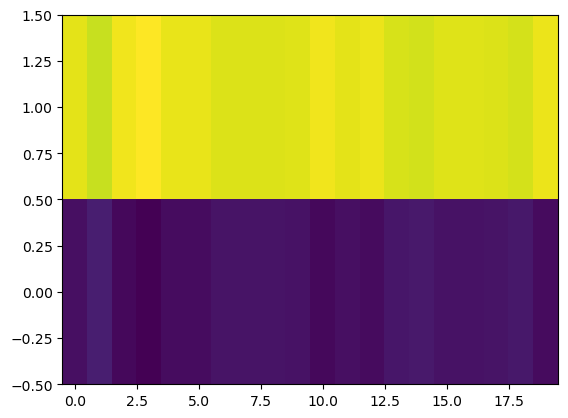

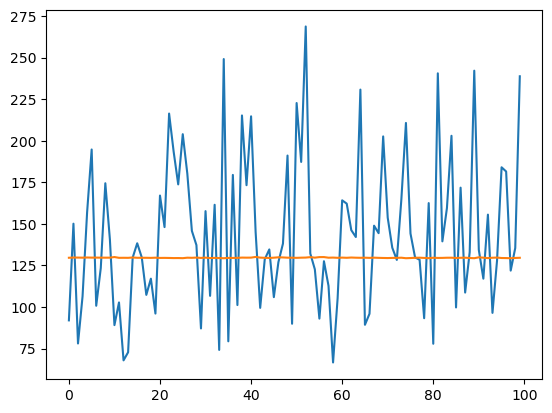

In [ ]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

In [ ]:
params['num_epochs']+=100

RESUMING TRAINING
STARTING EPOCH:  601


  0%|          | 0/100 [00:00<?, ?it/s]

601 0s 1e-05	182.5/129.6(129.3) 0.07397 0.344
[[ 9.8 90.2]
 [28.7 71.3]]
602 6.7s 1e-05	93.62/129.7(129.3) 0.07894 0.344
[[11.1 88.9]
 [31.7 68.3]]
603 6.7s 1e-05	136.7/129.5(129.3) 0.08094 0.344
[[11.7 88.3]
 [33.2 66.8]]
604 6.6s 1e-05	113.5/129.6(129.3) 0.07809 0.344
[[10.8 89.2]
 [30.9 69.1]]
605 6.5s 1e-05	130.5/129.6(129.3) 0.0789 0.344
[[10.6 89.4]
 [30.6 69.4]]
606 6.5s 1e-05	139.2/129.7(129.3) 0.08048 0.344
[[11.6 88.4]
 [32.8 67.2]]
607 6.5s 1e-05	72.47/129.6(129.3) 0.07347 0.341
[[ 9.4 90.6]
 [28.4 71.6]]
608 6.5s 1e-05	171.8/129.7(129.3) 0.06964 0.342
[[ 8.3 91.7]
 [25.8 74.2]]
609 6.6s 1e-05	122.3/129.5(129.3) 0.07511 0.344
[[10.3 89.7]
 [29.8 70.2]]
610 6.4s 1e-05	171.7/129.5(129.3) 0.07633 0.345
[[10.7 89.3]
 [30.7 69.3]]
611 6.5s 1e-05	208.5/129.4(129.3) 0.07888 0.344
[[11.6 88.4]
 [32.6 67.4]]
612 6.8s 1e-05	136.6/129.6(129.3) 0.07796 0.343
[[10.7 89.3]
 [30.8 69.2]]
613 6.5s 1e-05	137.1/129.7(129.3) 0.07708 0.342
[[10.3 89.7]
 [30.4 69.6]]
614 6.5s 1e-05	110.7/129.6(1

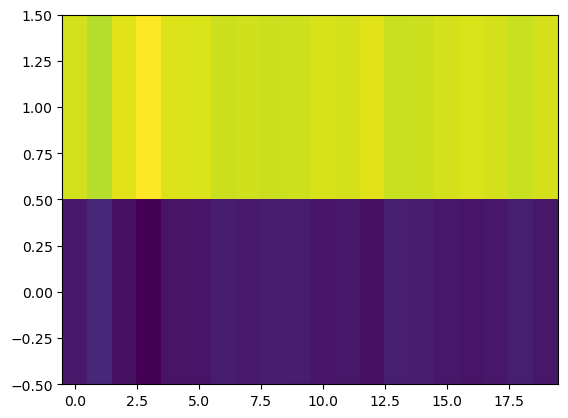

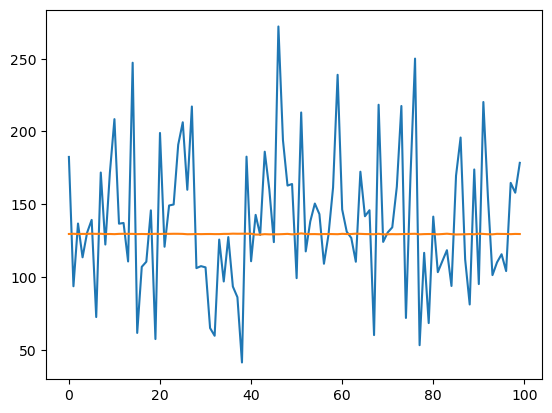

In [ ]:
if params['mode'] == 'train':
    train(model, dl_train, dl_valid, params)

# Evaluation of model performance

## Inference on test data

In [ ]:
dvc = DEVICE = torch.device('cuda' if torch.cuda.is_available() and params['gpu'] else 'cpu')
print(dvc)
if params['gpu']:
    with dvc:
        model = DNRI(params).cuda() if params['sparse'] else DNRI(params,edge2node_mat=ds_train.edge2node_mat).cuda()
else:
    model = DNRI(params)  if params['sparse'] else DNRI(params,ds_train.edge2node_mat)
print(next(model.decoder.parameters()).device,)# model.decoder.edge2node_mat.device)
print("LOADING BEST MODEL")
best_path = os.path.join(params['working_dir'],'best_model')
print(best_path)
model.load(best_path)
model.eval()
print(next(model.decoder.parameters()).device,)# model.decoder.edge2node_mat.device)

cuda
Using learned interaction net decoder.
cuda:0
LOADING BEST MODEL
../results/synth_charged_5_10k/dnri/seed_1/best_model
cuda:0


In [ ]:
params['data_path']

'../data/raw/synth_charged_5_10k/'

In [ ]:
feats = torch.load(params['data_path']+'test_feats')
feats_ = torch.load(params['data_path']+'test_feats') # not normalized feats

In [ ]:
feats  = feats[:,ds_train.slice_t]
feats_ = feats_[:,ds_train.slice_t]

In [ ]:
feats  = feats.transpose(1,2)
feats_ = feats_.transpose(1,2)

In [ ]:
feats[..., :2] = (feats[..., :2]-ds_train.loc_min)*2/(ds_train.loc_max-ds_train.loc_min)-1
feats[...,2: ] = (feats[...,2: ]-ds_train.vel_min)*2/(ds_train.vel_max-ds_train.vel_min)-1

In [ ]:
edges_true = torch.load(params['data_path']+'test_edges') # samples, 5, 5
# take out the diagonal and flatten
# Get the indices of diagonal elements
r,c = np.diag_indices(edges_true.shape[1])
# Create a mask to select non-diagonal elements
mask = torch.ones_like(edges_true[0], dtype=bool)
mask[r,c] = False
# Apply the mask to the matrix
edges_true = edges_true[:,mask] # samples, E=N*(N-1)
if params['sparse']:
    edges_true = edges_true[...,np.concatenate([np.flatnonzero(np.logical_and(row_idx==i.item(), col_idx==j.item())) for i,j in zip(s_e,r_e)])]
# take the latest 50 snapshots
edges_true = ((edges_true+1.)*.5)[:,:,None].expand(-1,-1,feats.shape[2]) # samples, E, T
# self.edges = F.one_hot(self.edges.long())  # samples, E, T, C
edges_true = edges_true.transpose(1,2)
edges_true.shape

torch.Size([10000, 50, 20])

In [ ]:
norm = ds_train.norm # 2/(train_data.loc_max-train_data.loc_min)
norm_v = ds_train.norm_v # 2/(train_data.vel_max-train_data.vel_min)

In [ ]:
params['norms'] = {'loc_max': ds_train.loc_max, 'loc_min': ds_train.loc_min,
                   'vel_max': ds_train.vel_max, 'vel_min': ds_train.vel_min,
                   'norm': ds_train.norm, 'norm_v': ds_train.norm_v,
                  }
params['norms']

{'loc_max': tensor(5.),
 'loc_min': tensor(-5.0000),
 'vel_max': tensor(6.4619),
 'vel_min': tensor(-6.3719),
 'norm': tensor(5.),
 'norm_v': tensor(6.4169)}

In [ ]:
feats.shape, edges_true.shape

(torch.Size([10000, 5, 50, 4]), torch.Size([10000, 50, 20]))

In [ ]:
N= feats.shape[1]
n=N
N,n

(5, 5)

In [ ]:
batch_size = 32  # 128

In [ ]:
assert model.training == False

In [ ]:
with torch.inference_mode(), dvc:
    model.to(dvc)
    node_feats, edge_feats = feats.to(dvc), get_dv(feats, params['sparse']).to(dvc)  # B, T, N, F
    node_feats_test = node_feats
    edge_feats_test = edge_feats
    # target one step in the future
    target = node_feats[:,:, 1:] if not params['pred_delta'] else node_feats.diff(dim=2) # [B:batch, T:time-1, N:num_object, F:num_feats] target the future

    if params['sparse']: # For instance, if we know particle 0 and 1 do not interact with each other
        send_edges, recv_edges = (s_e.cuda(), r_e.cuda()) if params['gpu'] else (s_e, r_e)
    else: # fully connected
        send_edges, recv_edges = torch.where(torch.ones(params['num_vars']) - torch.eye(params['num_vars']))
        edge2node_mat = nn.Parameter(torch.stack([(recv_edges == i)*1.
                                              for i in range(params['num_vars'])]),
                                 requires_grad=False)
    edge_index = torch.stack((send_edges, recv_edges))
    # implicit batching
    datalist = [Data(node_feats=n, edge_feats=e, edge_index=edge_index)
                         for n,e in zip(node_feats,edge_feats)]

    print(f'{len(datalist)=}')
    timesteps = node_feats.size(2)  # T
    dl = DataLoader(datalist, batch_size=batch_size)
    all_edges, all_preds = [], []
    all_prior_logits, all_posterior_logits = [], []
    # batching-------------------
    for b in tqdm(dl):
        node_feats, edge_feats, edge_index_ = getattrs(b,['node_feats','edge_feats', 'edge_index'])

        # Encode input = predict prior and edge class
        prior_logits, posterior_logits, prior_state = model.encoder(node_feats[:,:-1],edge_feats[:,:-1], edge_index_)
        all_prior_logits.append(prior_logits)
        all_posterior_logits.append(posterior_logits)

        # Decode = predict next timestep features
        hidden = model.decoder.get_initial_hidden(node_feats) # zeros B*N,H
        edges, predictions = [], []

        for step in range(timesteps - 1): # T-1
            current_inputs = node_feats[:, step], edge_feats[:,step],edge_index_  # B*N, F
            prediction, hidden, edge = model.single_step_forward(
                current_inputs,  # B*N, F
                hidden,  # B*N, H
                posterior_logits[:, step],  # B*E, C
                hard_sample=True
            )
            predictions.append(prediction)  # B*N, F
            edges.append(edge)              # B*E, C

        all_preds.append(torch.stack(predictions, dim=1)) # B*N, T-1, F
        all_edges.append(torch.stack(edges,dim=1)) # B*E,T-1,C

    # get loss
    # reconstruction
    all_preds=torch.cat(all_preds, dim=0)
    all_edges=torch.cat(all_edges, dim=0)
    print(f'{all_preds.shape=}, {target.shape=}')
    loss_nll = model.nll_gaussian(all_preds.reshape(-1,4), target.reshape(-1,4))

    # priors
    # learned prior
    all_posterior_logits=torch.cat(all_posterior_logits, dim=0)
    all_prior_logits=torch.cat(all_prior_logits, dim=0)

    prob = F.softmax(all_posterior_logits, dim=-1)
    loss_kl = loss_kl_learned = model.kl_categorical_learned(prob, all_prior_logits)
    # uniform (or guessed) prior
    if params['add_uniform_prior']:
        loss_kl_uniform = model.kl_categorical_avg(prob)
        loss_kl = 0.5 * loss_kl_learned + 0.5 * loss_kl_uniform

    loss = loss_nll + model.kl_coef * loss_kl
    loss = loss.mean().item()

    # mask_loss = torch.linalg.norm(target[...,:2], axis=-1)<model.Rinterior
    mask_loss_b = torch.linalg.norm(node_feats_test[:,:,1:,:2], axis=-1)<model.Rinterior
    idx_loss = torch.nonzero(mask_loss_b)
    mask_loss = mask_loss_b.reshape(-1,49)

node_feats = node_feats_test
edge_feats = edge_feats_test
predictions = all_preds
predictions = predictions.reshape(*node_feats.shape[:2],*predictions.shape[-2:])
edges = all_edges
posterior_logits = all_posterior_logits
prior_logits = all_prior_logits
import gc; gc.collect()
torch.cuda.empty_cache()

len(datalist)=10000


  0%|          | 0/313 [00:00<?, ?it/s]

all_preds.shape=torch.Size([50000, 49, 4]), target.shape=torch.Size([10000, 5, 49, 4])


In [ ]:
# test_data = SmallSynthDataPyG(params['data_path'], 'test', params)
# edges_true = test_data.edges
edge_feats_batch = Batch.from_data_list(datalist,follow_batch=['edge_feats']).edge_feats_batch
edges_b, mask = to_dense_batch(edges,edge_feats_batch)
edges_pred  = edges_b.argmax(dim=-1).long().transpose(1,-1).cpu()

In [ ]:
edges_true_ = edges_true[:,1:].long().cpu() # from the second timestep to coincide with predicted because first edges is from non-saved features

In [ ]:
loss

153.3005828857422

## Loss

In [ ]:
loss, *list(map(lambda x: x.mean().item(), [loss_nll,loss_kl, loss_kl_learned]))

(153.3005828857422,
 153.1201629638672,
 0.18041878938674927,
 0.18041878938674927)

In [ ]:
node_feats.shape, predictions.shape, mask_loss.shape, node_feats[:,:,1:,:2][mask_loss_b].shape

(torch.Size([10000, 5, 50, 4]),
 torch.Size([10000, 5, 49, 4]),
 torch.Size([50000, 49]),
 torch.Size([1340786, 2]))

In [ ]:
# MSE positions, velocities
unnorm_pred_pos = predictions[...,:2]*norm
unnorm_pred_vel = predictions[...,2:]*norm_v
unnorm_targ_pos = target[...,:2]*norm
unnorm_targ_vel = target[...,2:]*norm_v

mse_pos = F.mse_loss(unnorm_pred_pos, unnorm_targ_pos, reduction='none')
mse_vel = F.mse_loss(unnorm_pred_vel, unnorm_targ_vel, reduction='none')

nll_pos = ((unnorm_pred_pos-unnorm_targ_pos) ** 2 / (2 * model.prior_variance))
nll_vel = ((unnorm_pred_vel-unnorm_targ_vel) ** 2 / (2 * model.prior_variance))

print(list(map(lambda x: f'{x.sum(-1).mean().item():.3g}',
               [mse_pos, mse_vel, nll_pos, nll_vel])))

['0.00281', '0.691', '28.1', '6.91e+03']


In [ ]:
nll_base =((node_feats_test[:,:,:-1,][mask_loss_b] - target[mask_loss_b]) ** 2 / (2 * model.prior_variance))

In [ ]:
nll_base.sum(-1).mean(), nll_base[...,:2].sum(-1).mean(), nll_base[...,2:].sum(-1).mean()

(tensor(204.3158, device='cuda:0'),
 tensor(6.0800, device='cuda:0'),
 tensor(198.2358, device='cuda:0'))

In [ ]:
nll_base =((node_feats_test[:,:,:-1,]- target) ** 2 / (2 * model.prior_variance))

In [ ]:
nll_pos_b = nll_pos
nll_vel_b = nll_vel

In [ ]:
nll_pos.shape

torch.Size([10000, 5, 49, 2])

In [ ]:
nll = ((predictions - target) ** 2 / (2 * model.prior_variance))

In [ ]:
nll[...,:2].sum(-1).mean(), nll[...,2:].sum(-1).mean()

(tensor(1.1226, device='cuda:0'), tensor(167.8383, device='cuda:0'))

### Loss vs time

#### means

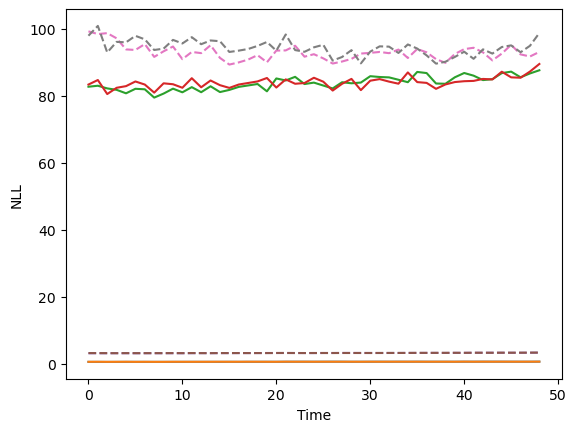

In [ ]:
# NLL in time
plt.plot(nll.mean((0,1)).cpu());
plt.plot(nll_base.mean((0,1), ).cpu(),'--');
plt.gca().set( xlabel='Time', ylabel='NLL');

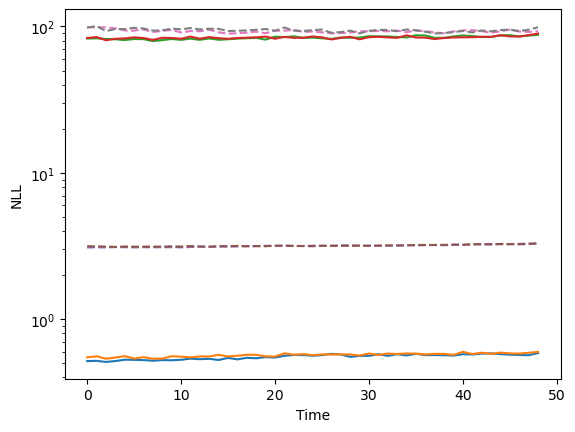

In [ ]:
plt.semilogy(nll.mean((0,1)).cpu());
plt.semilogy(nll_base.mean((0,1), ).cpu(),'--');
plt.gca().set( xlabel='Time', ylabel='NLL');

#### distribution

In [ ]:
nll_logbins = np.geomspace(1e-8,2e4)

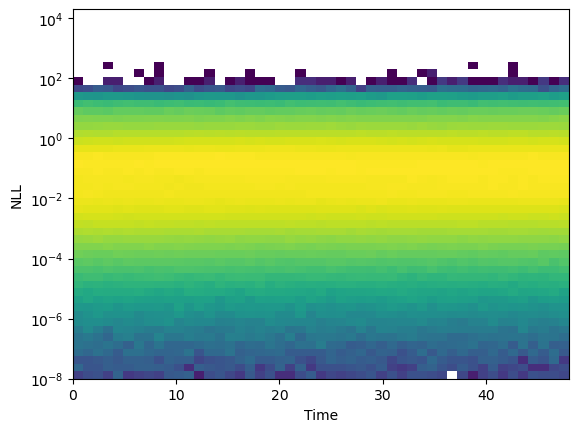

In [ ]:
plt.hist2d(np.tile(np.arange(nll.shape[2]),np.prod(nll.shape[0:2])).reshape(-1),
           nll[...,0].reshape(-1).cpu(),
           bins=[49,nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='Time', ylabel='NLL');

### Loss vs space

#### positions

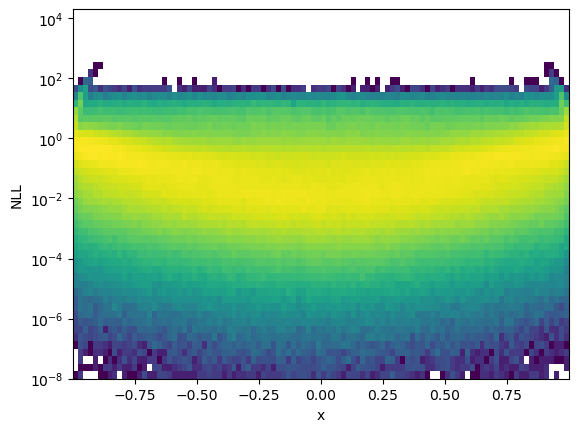

In [ ]:
plt.hist2d(target[...,0].reshape(-1).cpu(),
           nll[...,0].reshape(-1).cpu(),
           bins=[100, nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='x', ylabel='NLL');

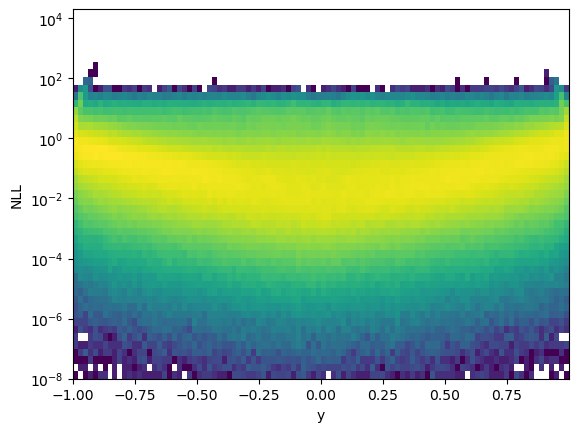

In [ ]:
plt.hist2d(target[...,1].reshape(-1).cpu(),
           nll[...,1].reshape(-1).cpu(),
           bins=[100, nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='y', ylabel='NLL');

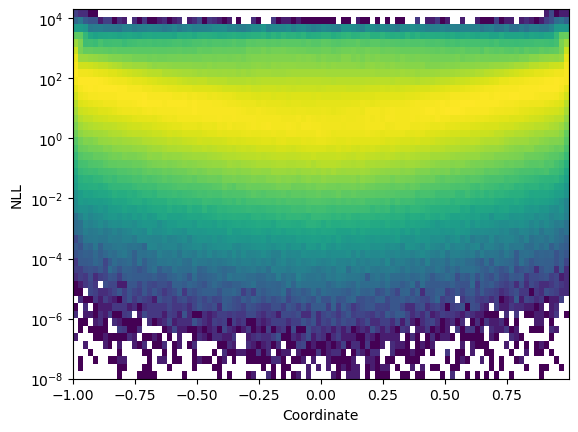

In [ ]:
plt.hist2d(target[...,:2].reshape(-1).cpu(),
           nll[...,2:].reshape(-1).cpu(),
           bins=[100, nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='Coordinate', ylabel='NLL');

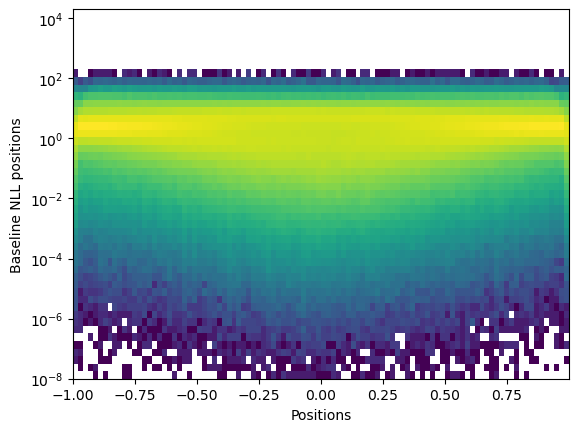

In [ ]:
plt.hist2d(target[...,:2].reshape(-1).cpu(),
           nll_base[...,:2].reshape(-1).cpu(),
           bins=[100, nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='Positions', ylabel='Baseline NLL positions');

In [ ]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[...,0].reshape(-1).cpu(), target[...,1].reshape(-1).cpu()
zs = nll[...,0:2].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

/tmp/ipykernel_896531/754753445.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


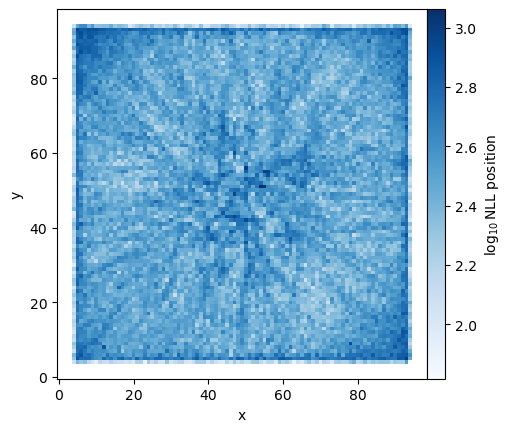

In [ ]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL position');
plt.gca().set(xlabel='x',ylabel='y');

#### velocities

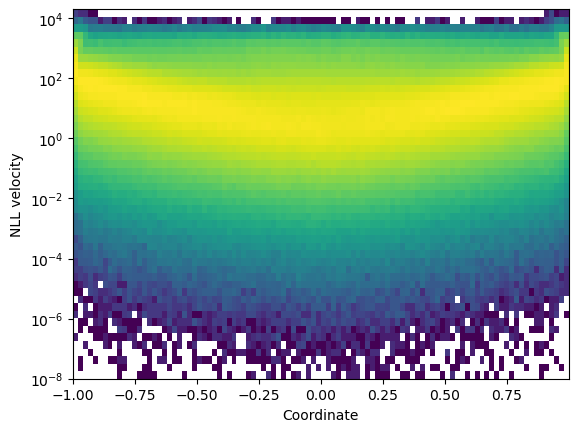

In [ ]:
plt.hist2d(target[...,:2].reshape(-1).cpu(),
           nll[...,2:].reshape(-1).cpu(),
           bins=[100, nll_logbins],norm='log');plt.yscale('log')
plt.gca().set( xlabel='Coordinate', ylabel='NLL velocity');

In [ ]:
nll[...,2:].min(), nll[...,2:].max()
nll_logbins = np.geomspace(1e-4,2e4)

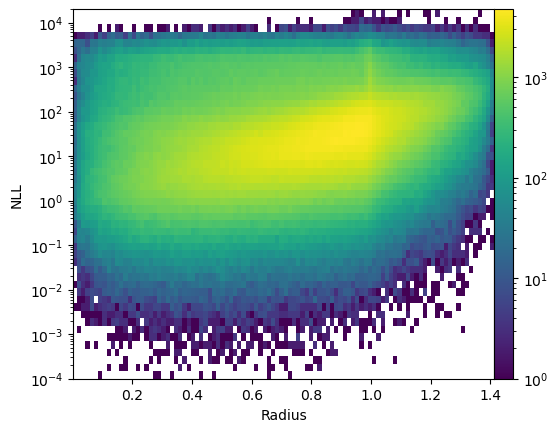

In [ ]:
plt.hist2d(torch.hypot(target[...,0].reshape(-1),target[...,1].reshape(-1)).cpu(),
           torch.hypot(nll[...,2].reshape(-1),nll[...,3].reshape(-1)).cpu(),
           bins=[100,nll_logbins],norm='log');
plt.yscale('log');plt.colorbar(pad=0);
plt.gca().set( xlabel='Radius', ylabel='NLL');

In [ ]:
bins = np.linspace(-1.1,1.1,100)
from scipy.stats import binned_statistic_2d
xs, ys = target[...,0].reshape(-1).cpu(), target[...,1].reshape(-1).cpu()
zs = nll[...,2:4].sum(-1).reshape(-1).cpu()
bs = binned_statistic_2d(xs,ys,zs,bins=bins,statistic='sum')

/tmp/ipykernel_896531/3473451225.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');


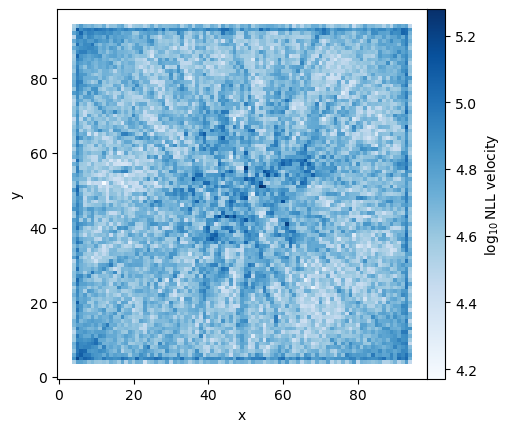

In [ ]:
plt.imshow(np.log10(bs.statistic), cmap='Blues',origin='lower');
plt.colorbar(pad=0, label=r'$\log_{10}$NLL velocity');
plt.gca().set(xlabel='x',ylabel='y');

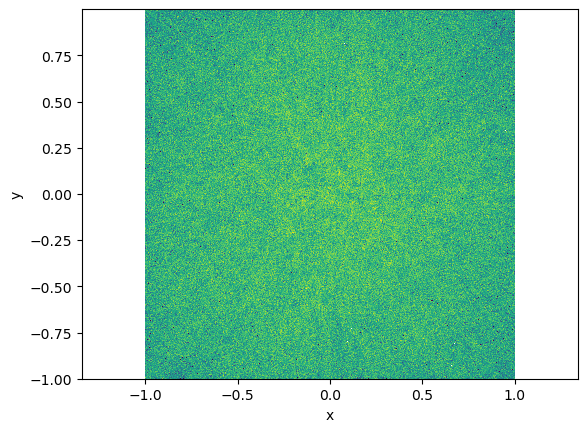

In [ ]:
plt.hist2d(target[...,0].reshape(-1).cpu().numpy(),
           target[...,1].reshape(-1).cpu().numpy(), 500, norm='log');
plt.axis('equal');
plt.gca().set( xlabel='x', ylabel='y');

### Masked Top losses

In [ ]:
target_b = target.transpose(2,1)
predictions_b = predictions.transpose(2,1)

In [ ]:
nll_vel_b.shape, mask_loss.shape,mask_loss_b.shape,idx_loss.shape

(torch.Size([10000, 5, 49, 2]),
 torch.Size([50000, 49]),
 torch.Size([10000, 5, 49]),
 torch.Size([1340786, 3]))

In [ ]:
nll_vel_b_mt = nll_vel_b*mask_loss_b[...,None].repeat(1,1,1,2)

In [ ]:
nll_pos_b_mt = nll_pos_b*mask_loss_b[...,None].repeat(1,1,1,2)

In [ ]:
nll_vel_b_mt.shape, mask_loss_b[...,None].repeat(1,1,1,2).shape

(torch.Size([10000, 5, 49, 2]), torch.Size([10000, 5, 49, 2]))

In [ ]:
nll_vel_top_k,top_k_vel = nll_vel_b_mt.sum((-1,-2,-3)).topk(10)

In [ ]:
nll_pos_top_k,top_k_pos = nll_pos_b_mt.sum((-1,-2,-3)).topk(10)

In [ ]:
print(nll_vel_top_k)
print(nll_pos_top_k)

tensor([11347906., 11065342., 10312621.,  9930442.,  9481638.,  9356846.,
         9273309.,  9137744.,  9091945.,  9061828.], device='cuda:0')
tensor([54477.0156, 50267.9141, 44168.1328, 39629.8516, 39287.4453, 39164.3242,
        38209.0547, 38009.7734, 37527.7578, 36668.2891], device='cuda:0')


In [ ]:
print(nll_vel_top_k)
print(nll_pos_top_k)

tensor([11347906., 11065342., 10312621.,  9930442.,  9481638.,  9356846.,
         9273309.,  9137744.,  9091945.,  9061828.], device='cuda:0')
tensor([54477.0156, 50267.9141, 44168.1328, 39629.8516, 39287.4453, 39164.3242,
        38209.0547, 38009.7734, 37527.7578, 36668.2891], device='cuda:0')


In [ ]:
circle_center,circle_radius = np.zeros(2), 5.

/tmp/ipykernel_896531/3411046419.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969073/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  axs[0].plot(*target_b[i,t,p[0],:2].T.cpu(), 'o', zorder=-1);


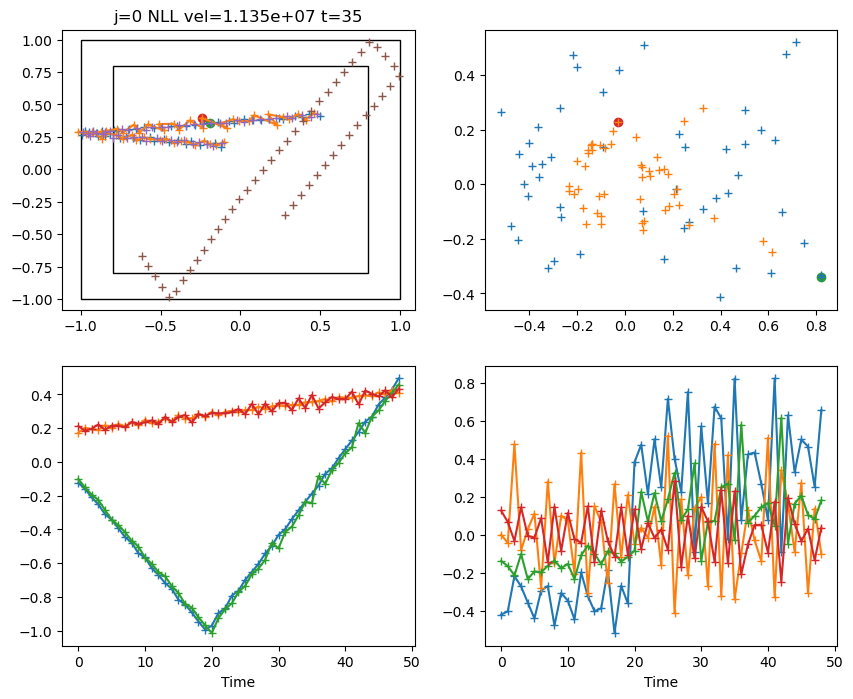

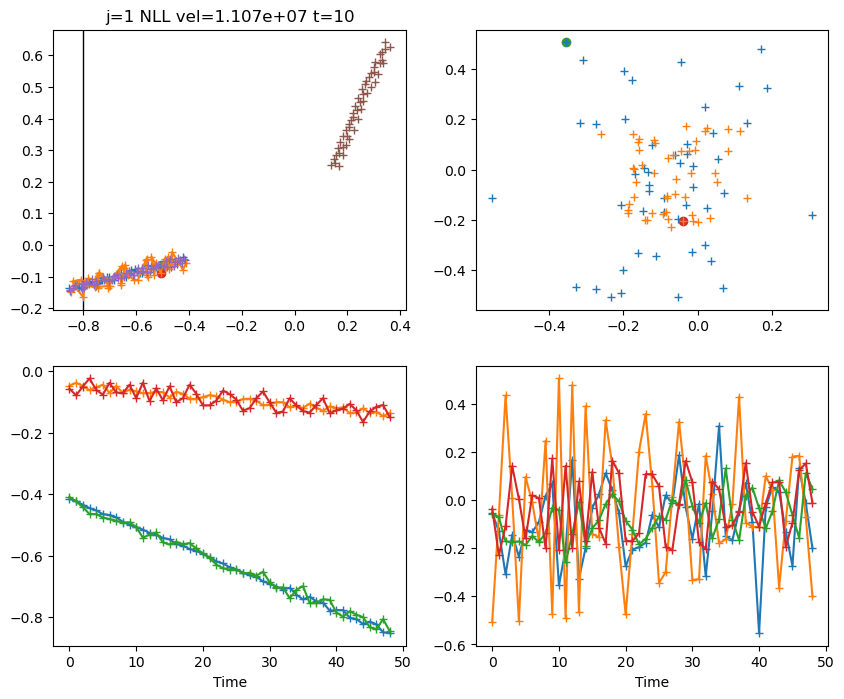

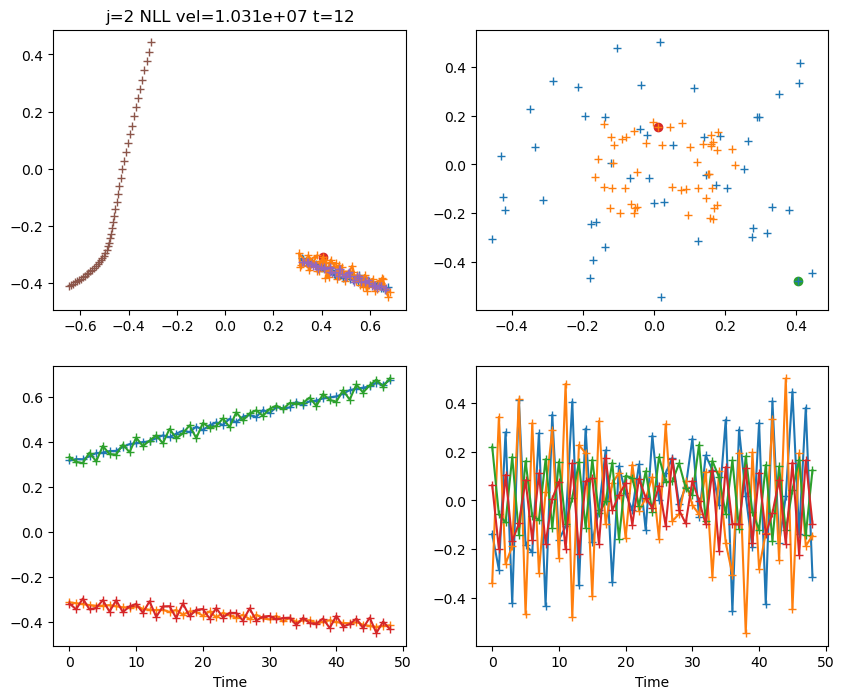

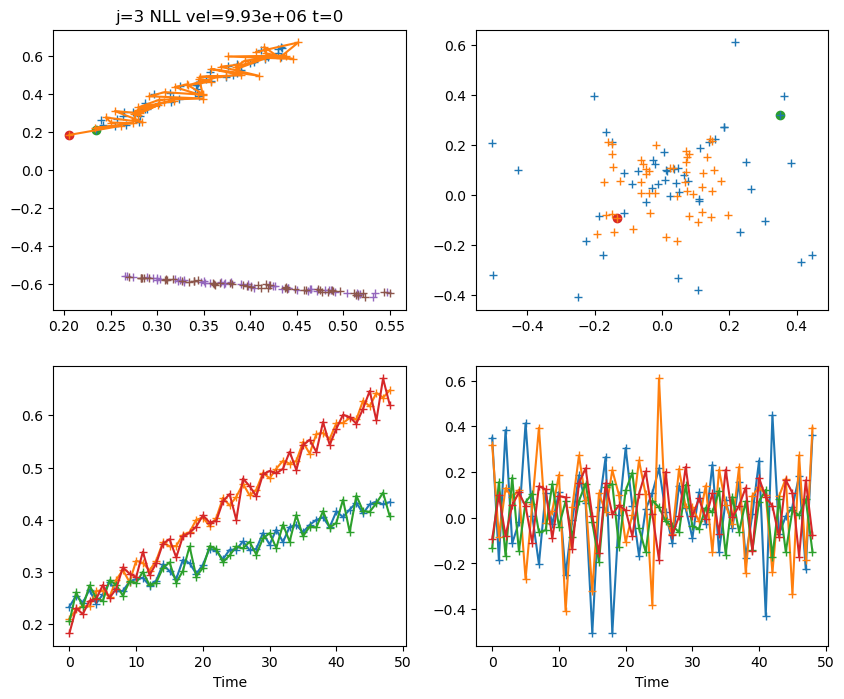

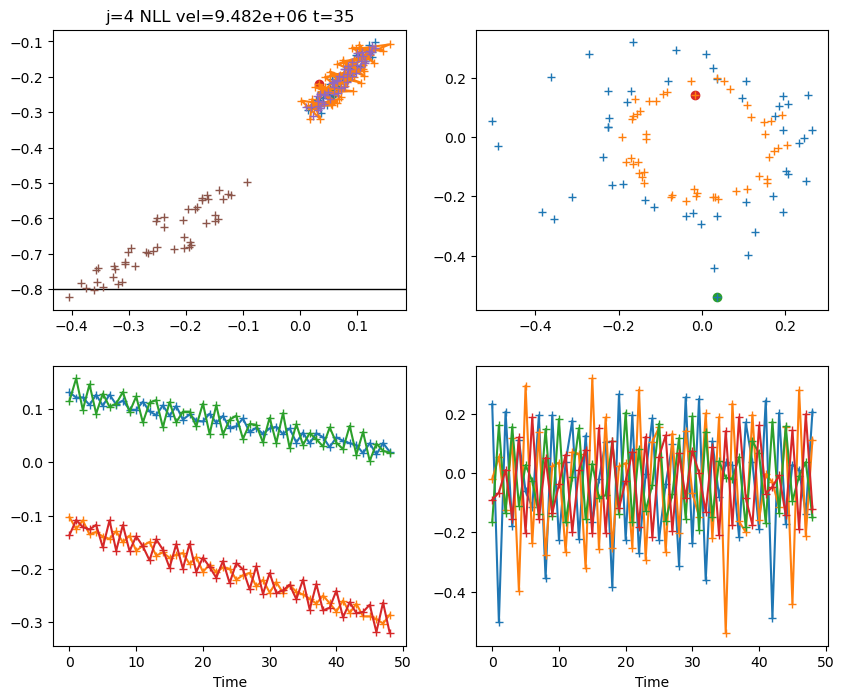

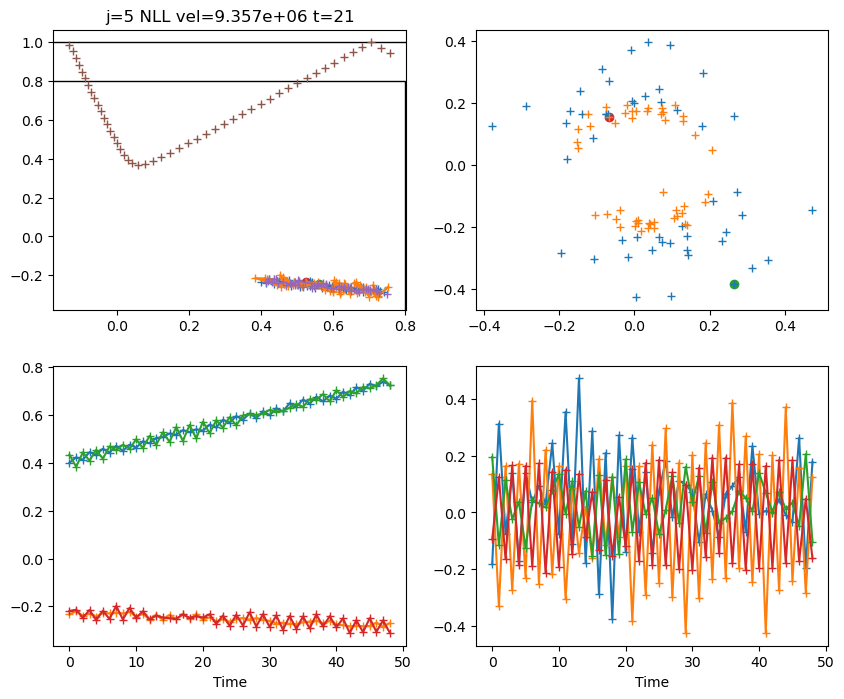

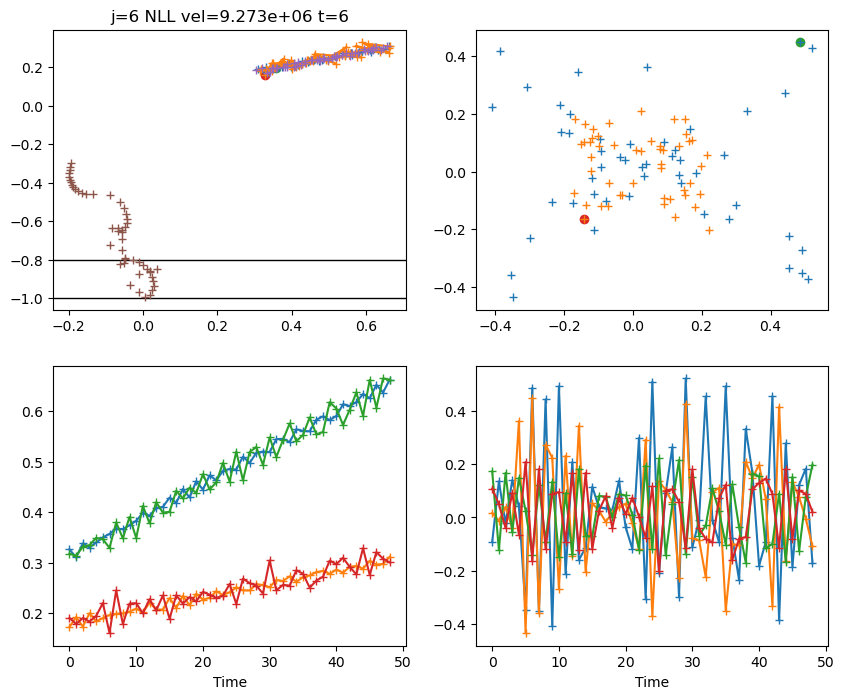

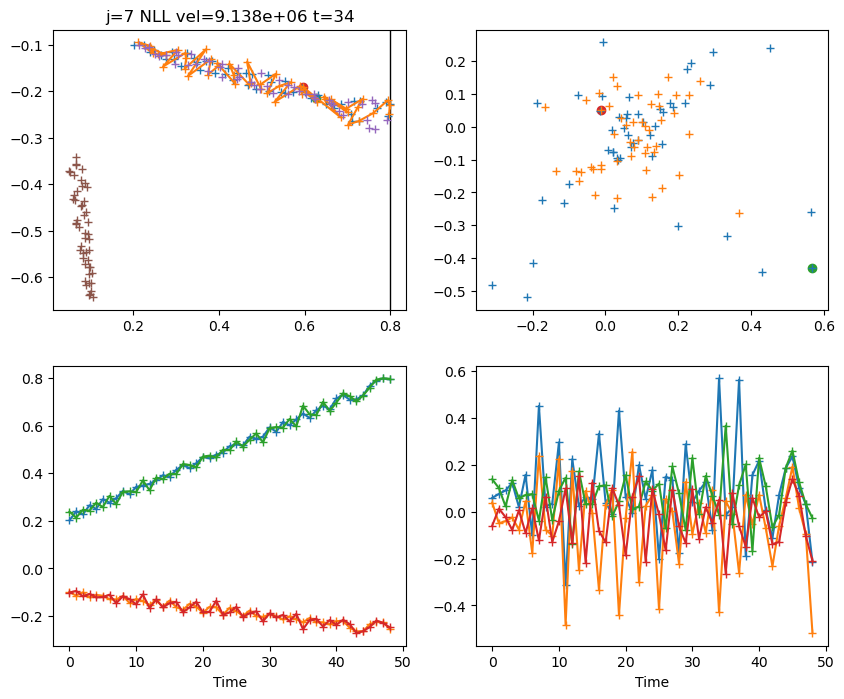

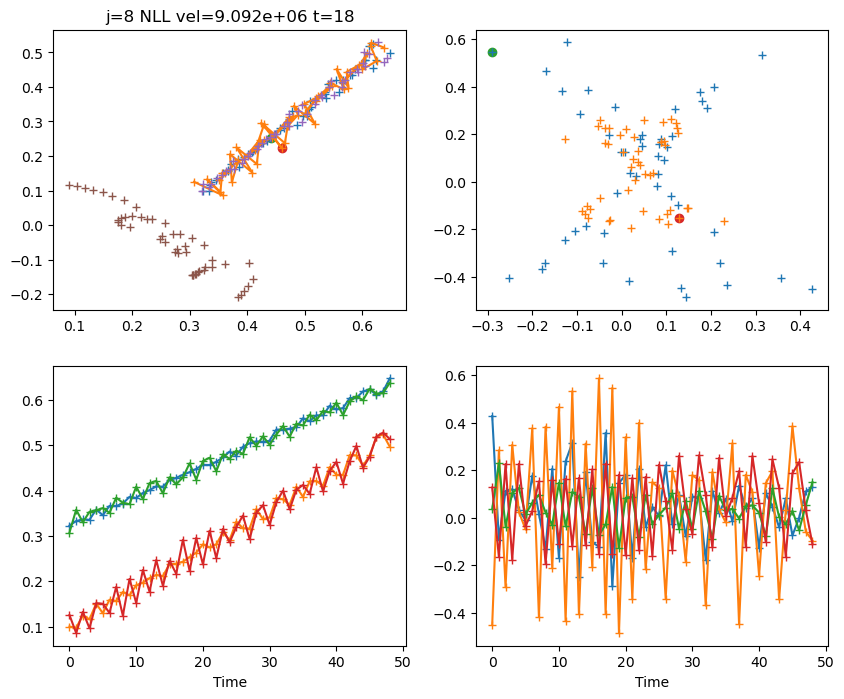

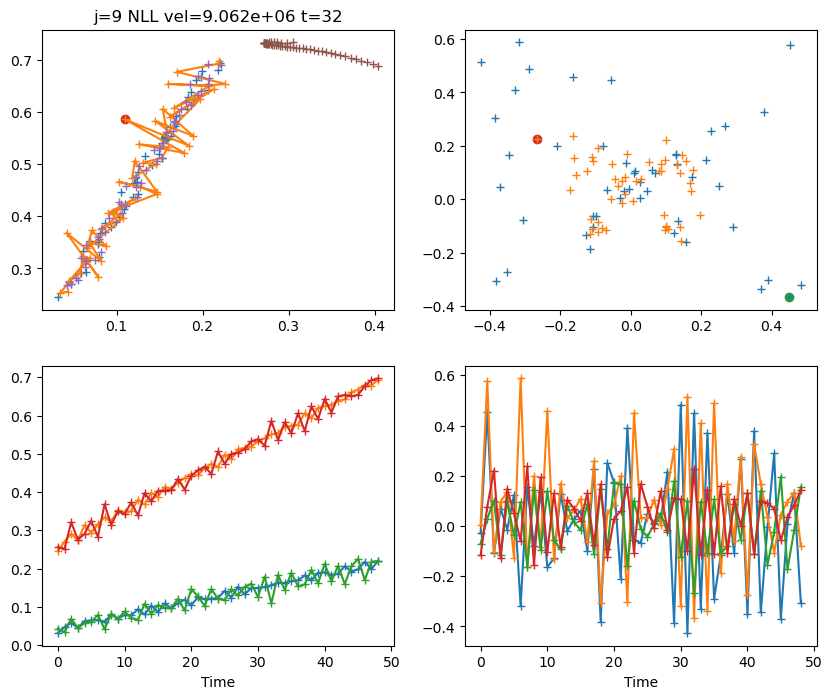

In [ ]:
for j, (i,nll_v) in enumerate(zip(top_k_vel,nll_vel_top_k)):
    t = nll_vel_b_mt[i,].sum((-1,-3)).argmax(-1).item()
    p = nll_vel_b_mt[i,:,t].sum(-1).topk(3).indices
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    axs = axs.flatten()
    axs[0].set_title(f'{j=} NLL vel={nll_v:.4g} {t=}')
    axs[0].plot(*target_b[i,:,p[0],:2].T.cpu(), '+');
    axs[0].plot(*predictions_b[i,:,p[0],:2].T.cpu(), '+-');
    axs[0].plot(*target_b[i,t,p[0],:2].T.cpu(), 'o', zorder=-1);
    axs[0].plot(*predictions_b[i,t,p[0],:2].T.cpu(), 'o', zorder=-1);
    axs[0].plot(*target_b[i,:,p[1],:2].T.cpu(), '+');
    axs[0].plot(*target_b[i,:,p[2],:2].T.cpu(), '+');
    axs[0].set(xlim=axs[0].get_xlim(),ylim=axs[0].get_ylim())
    axs[0].add_patch(plt.Rectangle(circle_center-(circle_radius/ds_train.norm).numpy(),
                                   2*circle_radius/ds_train.norm,
                                   2*circle_radius/ds_train.norm,
                                   fill=None))
    axs[0].add_patch(plt.Rectangle(circle_center-model.Rinterior,
                                   2*model.Rinterior,2*model.Rinterior,
                                fill=None))
    axs[1].plot(*target_b[i,:,p[0],2:].T.cpu(), '+');
    axs[1].plot(*predictions_b[i,:,p[0],2:].T.cpu(), '+');
    axs[1].plot(*target_b[i,t,p[0],2:].T.cpu(), 'o', zorder=-1);
    axs[1].plot(*predictions_b[i,t,p[0],2:].T.cpu(), 'o', zorder=-1);

    axs[2].plot(target_b[i,:,p[0],:2].cpu(), '+-');
    axs[2].plot(predictions_b[i,:,p[0],:2].cpu(), '+-');
    axs[3].plot(target_b[i,:,p[0],2:].cpu(), '+-');
    axs[3].plot(predictions_b[i,:,p[0],2:].cpu(), '+-');
    for ax in axs[2:]: ax.set_xlabel('Time');

## Raw preds

In [ ]:
target.shape, predictions.shape

(torch.Size([10000, 5, 49, 4]), torch.Size([10000, 5, 49, 4]))

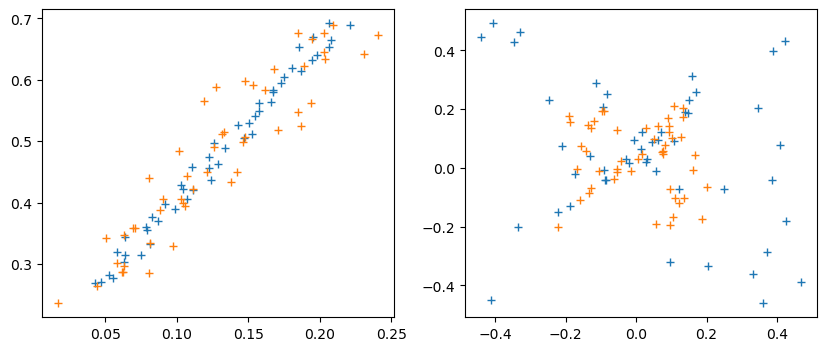

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(*target_b[i,:,0,:2].T.cpu(), '+');
axs[0].plot(*predictions_b[i,:,0,:2].T.cpu(), '+');
axs[1].plot(*target_b[i,:,0,2:].T.cpu(), '+');
axs[1].plot(*predictions_b[i,:,0,2:].T.cpu(), '+');

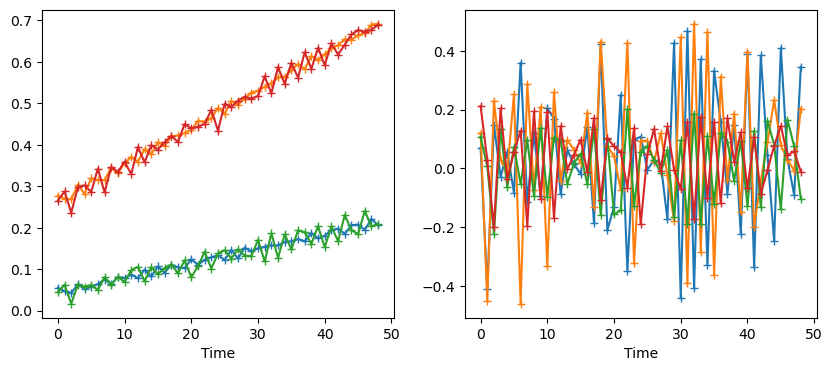

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,0,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,0,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,0,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,0,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

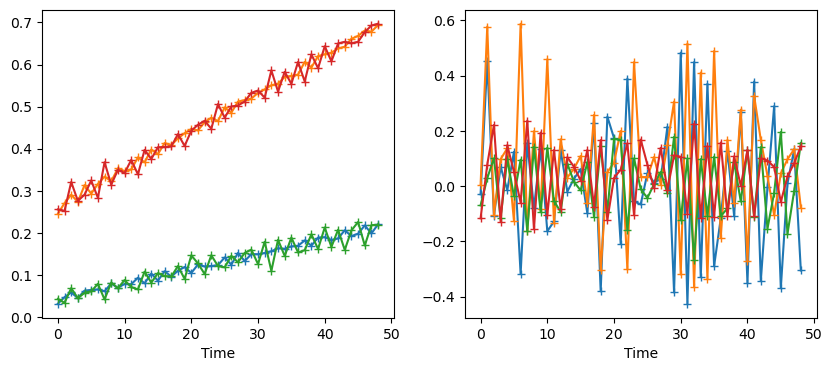

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].plot(target_b[i,:,1,:2].cpu(), '+-');
axs[0].plot(predictions_b[i,:,1,:2].cpu(), '+-');
axs[1].plot(target_b[i,:,1,2:].cpu(), '+-');
axs[1].plot(predictions_b[i,:,1,2:].cpu(), '+-');
for ax in axs: ax.set_xlabel('Time');

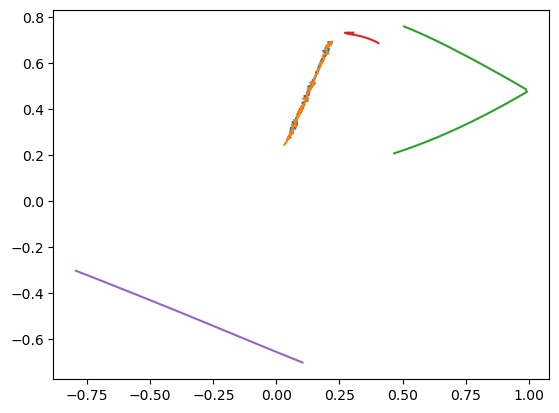

In [ ]:
for j in range(N):
    plt.plot(*target_b[i,:,j,:2].cpu().T);

## 1 MSE vs time

In [ ]:
def eval_forward_prediction(model, dataset, burn_in_steps, forward_pred_steps,
                            params, return_total_errors=False,bs=None):
    batch_size = params.get('batch_size', 128) if bs is None else bs
    data_loader = DataLoader(dataset, batch_size=batch_size,drop_last=True)# pin_memory=gpu)
    model.eval()
    model.to(dvc)
    total_se, batch_count, bs = 0, 0, 0
    all_errors, preds, edges = [], [], []
    for batch in tqdm(data_loader):
        node_feats, edge_feats, edge_index = getattrs(batch,['node_feats','edge_feats', 'edge_index'])
        with torch.inference_mode():
            model_inputs = Data(node_feats=node_feats[:,:burn_in_steps],
                                edge_feats=edge_feats[:,:burn_in_steps],
                                edge_index=edge_index,
                                batch=batch.batch
                               )
            model_preds, model_edges = model.predict_future(model_inputs,
                                                            forward_pred_steps,
                                                            return_edges=True,
                                                            return_everything=True)
            preds.append(model_preds)
            edges.append(model_edges)
            # BN, T-1, F
            gt_predictions = node_feats[:,1:] #if True else node_feats[:, burn_in_steps:burn_in_steps+forward_pred_steps]
            batch_count += 1
            mse = F.mse_loss(model_preds,gt_predictions,reduction='none').mean(dim=-1)
            if return_total_errors:
                all_errors.append(mse)
            else:
                total_se += mse.sum(dim=0) # T-1
        bs+=len(batch.batch.unique()) # +B
    if return_total_errors:
        return torch.cat(all_errors, dim=0), torch.cat(preds,dim=0), torch.cat(edges,dim=0)
    else:
        return total_se / bs  # bs=len(dataset)

In [ ]:
params['data_path']

'../data/raw/synth_charged_5_10k/'

In [ ]:
test_data = SmallSynthDataPyG(params['data_path'], 'test', params)
forward_pred = test_data.node_feats.shape[2] - params['test_burn_in_steps']  # 50-10
test_mse, test_preds, test_edges = eval_forward_prediction(model,
                                    test_data.datalist,
                                    params['test_burn_in_steps'],
                                    forward_pred, params,
                                    return_total_errors=True,
                                    bs=100
                                   )
test_mse = test_mse.cpu()
path = os.path.join(params['working_dir'], '2024_'+params['error_out_name']%params['test_burn_in_steps'])
#np.save(path, test_mse.cpu().numpy())
print(path)

Using given norm


  0%|          | 0/2 [00:00<?, ?it/s]

../results/synth_charged_5_10k/dnri/seed_1/2024_prediction_errors_10step.npy


In [ ]:
# np.save('synth_'+'test_mse_burninsteps10', test_mse.cpu().numpy())

In [ ]:
params['data_path'], test_preds.shape, test_data.node_feats.shape

('../data/raw/synth_charged_5_10k/',
 torch.Size([1000, 49, 4]),
 torch.Size([200, 5, 50, 4]))

In [ ]:
test_mse_1  = test_mse.mean(0)[0].item()
test_mse_15 = test_mse.mean(0)[14].item()
test_mse_25 = test_mse.mean(0)[24].item()
print("FORWARD PRED RESULTS:")
print("\t1 STEP: ", test_mse_1)
print("\t15 STEP: ",test_mse_15)
print("\t25 STEP: ",test_mse_25)

FORWARD PRED RESULTS:
	1 STEP:  0.004491504747420549
	15 STEP:  0.01647225208580494
	25 STEP:  0.043003082275390625


In [ ]:
test_preds.shape,test_mse.shape

(torch.Size([1000, 49, 4]), torch.Size([1000, 49]))

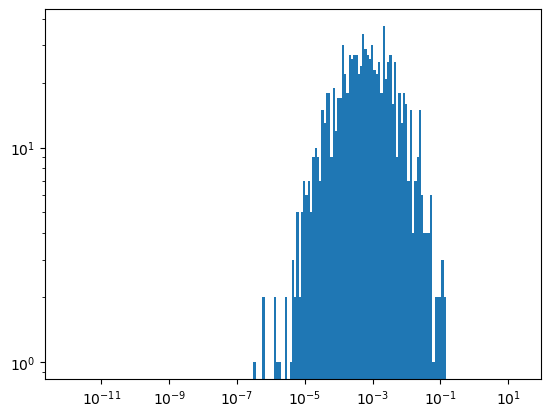

In [ ]:
plt.hist(test_mse[:,0], bins=np.concatenate([[0],np.geomspace(1e-12,2e1,200)]), log=True); plt.xscale('log');

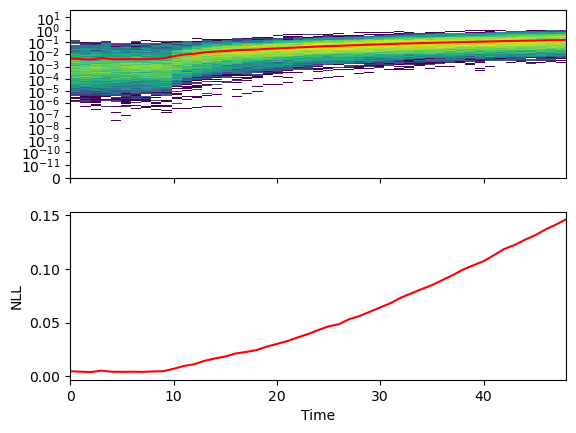

In [ ]:
logbins = np.concatenate([[0],np.geomspace(1e-11,4e1,200)])
fig,axs = plt.subplots(2,1, sharex=True )#figsize=(12,4))
axs = axs.flatten()
axs[0].hist2d(np.tile(np.arange(test_mse.shape[-1]),test_mse.shape[0]),
           test_mse.reshape(-1),
           bins = [49,logbins], norm='log'
          );
axs[0].plot(test_mse.mean(0),'r')
axs[0].set_yscale('symlog', linthresh=1e-11)
axs[1].plot(test_mse.mean(0),'r');
axs[1].set_xlabel('Time');axs[1].set_ylabel('NLL');

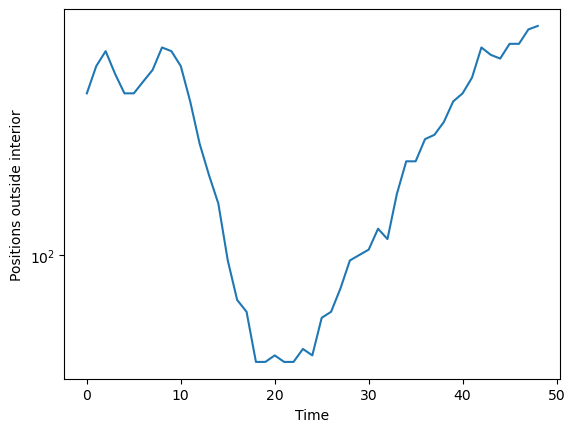

In [ ]:
plt.semilogy((test_preds[:,:,:2]>model.Rinterior).any(-1).sum(0).cpu().numpy());
plt.gca().set( xlabel='Time',ylabel='Positions outside interior', yscale='symlog');

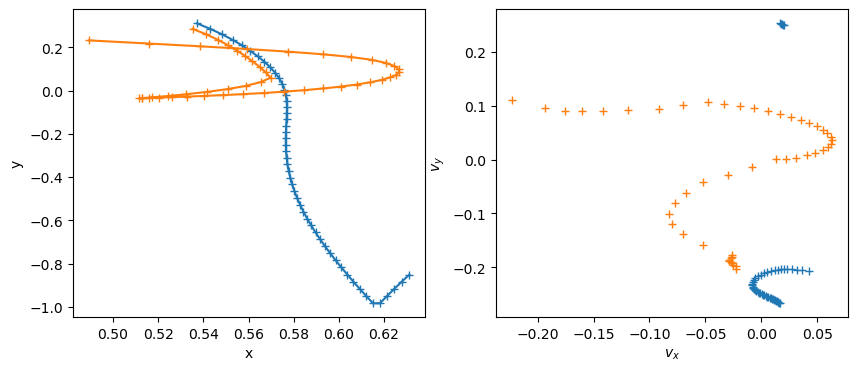

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
i=0; j=0
axs[0].plot(*test_data.node_feats.reshape(-1,50,4)[i+N*j,:,:2].T.cpu().numpy(),'+-');
axs[0].plot(*test_preds[i+j*N,:,:2].T.cpu().numpy(),'+-');
axs[0].set_xlabel('x');axs[0].set_ylabel('y');
axs[1].plot(*test_data.node_feats[i,j,:,2:].T.cpu().numpy(), '+');
axs[1].plot(*test_preds[i+j*N,:,2:].T.cpu().numpy(), '+');
axs[1].set_xlabel(r'$v_x$');axs[1].set_ylabel(r'$v_y$');

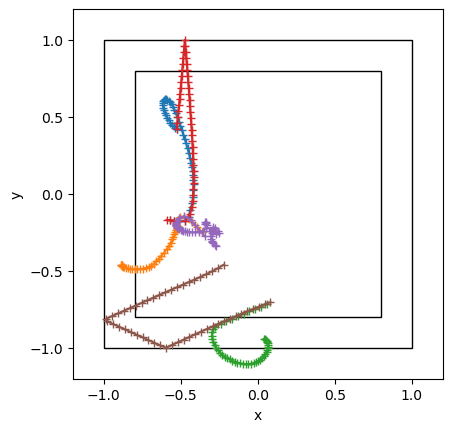

In [ ]:
i=6
plt.plot(*test_preds[i*N-1,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_preds[i*N-2,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_preds[i*N-3,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_data.node_feats[i-1,-1,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_data.node_feats[i-1,-2,:,:2].T.cpu().numpy(),'+-');
plt.plot(*test_data.node_feats[i-1,-3,:,:2].T.cpu().numpy(),'+-');
plt.gca().add_patch(plt.Rectangle(np.zeros(2)-model.Rinterior,2*model.Rinterior,2*model.Rinterior,fill=None));
plt.gca().add_patch(plt.Rectangle(np.zeros(2)-(circle_radius/ds_train.norm).numpy(),
                                  2*circle_radius/ds_train.norm,2*circle_radius/ds_train.norm,fill=None));
plt.xlim(-1.2,1.2);plt.ylim(-1.2,1.2);
plt.gca().set_aspect('equal');
plt.xlabel('x');plt.ylabel('y');

## 2 Edges

### Spurious edges due to small messages

In [ ]:
with torch.inference_mode() and dvc:
    eps = 1e-3
    start_idx = 1 if model.decoder.skip_first_edge_type else 0
    false_edges = torch.zeros_like(edges)  # to correct predicted edges
    assert model.train_hard_sample
    datalist_ = [Data(edge_feats=e, edge=ed)
                 for e,ed in zip(edge_feats[:,:,:-1],
                                 edges.reshape(*edge_feats.shape[:2],
                                               *edges.shape[-2:]))]
    print(f'{len(datalist_)=}')
    dl_ = DataLoader(datalist_, batch_size=batch_size, follow_batch=["edge"])
    # batching-------------------
    bi=0
    for b in tqdm(dl_):
        edge_feats_ = b['edge_feats']
        edges_ = b['edge']

        d = edge_feats_[...,0:1]  # (B*E,T,1) distances
        v = edge_feats_[...,1: ]  # (B*E,T,2) versor
        for i in range(len(model.decoder.edge_functions)):
            msg = model.decoder.edge_functions[i](d)*v    # BE, T, 2
            msg_near_zero = msg.abs().sum(-1)<eps
            # spurious = near zero and predicted as interacting edge
            false_edges[bi:bi+b.edge_ptr[-1],:,i+start_idx] = 1.*(msg_near_zero*edges_[...,i+start_idx])
        bi +=b.edge_ptr[-1]
        #print(bi.item())

    false_edges[...,0] = false_edges[...,start_idx:].sum(-1)
    false_edges[...,start_idx:] = -false_edges[...,start_idx:]
torch.cuda.empty_cache()

len(datalist_)=10000


  0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
false_edges.shape, false_edges.abs().max()

(torch.Size([200000, 49, 2]), tensor(1., device='cuda:0'))

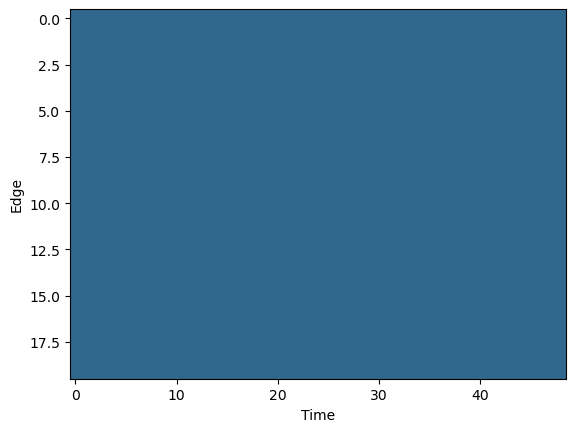

In [ ]:
edge_shape = edge_feats.shape[0],params['num_vars']*(params['num_vars']-1),edge_feats.shape[-2]-1,params['num_edge_types']
plt.imshow(false_edges.reshape(edge_shape)[0,...,1].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');
plt.gca().set( xlabel='Time', ylabel='Edge');

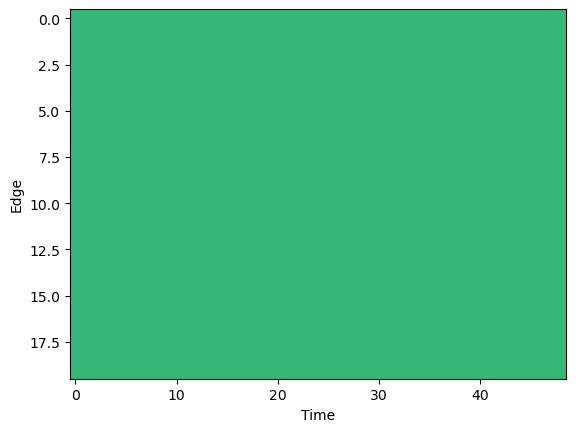

In [ ]:
plt.imshow(edges.reshape(edge_shape)[0,...,0].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');
plt.gca().set( xlabel='Time', ylabel='Edge');

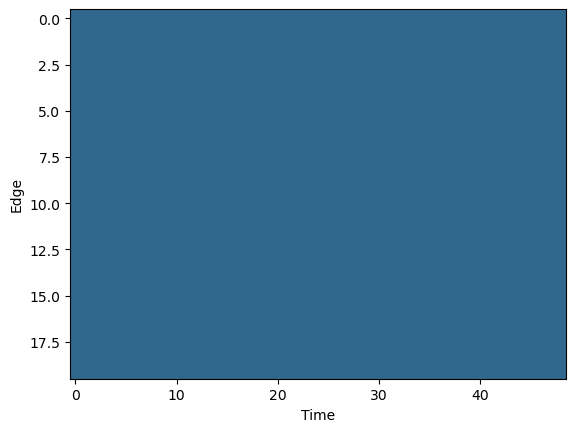

In [ ]:
plt.imshow(edges.reshape(edge_shape)[0,...,1].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');
plt.gca().set( xlabel='Time', ylabel='Edge');

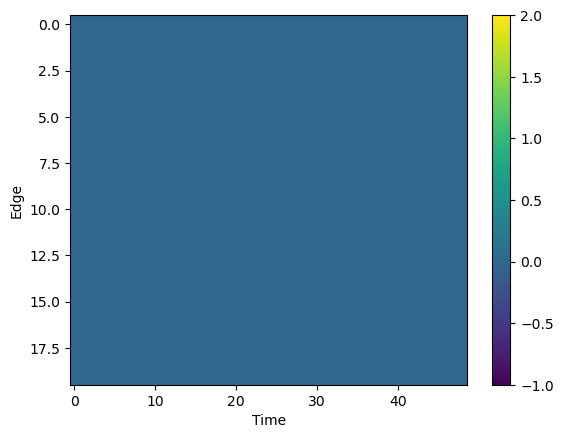

In [ ]:
plt.imshow((edges+false_edges).reshape(edge_shape)[0,...,1].cpu().numpy(),aspect='auto', vmin=-1,vmax=2, interpolation='none');
plt.colorbar();
plt.gca().set( xlabel='Time', ylabel='Edge');

### F1 score

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
def f1_score_dnri(edges_pred, edges_true_):
    # Compute macro/binary F1 for whole edge tensor
    if isinstance(edges_true_,torch.Tensor): edges_true_ = edges_true_.numpy()
    if isinstance(edges_pred,torch.Tensor): edges_pred = edges_pred.cpu().numpy()
    return f1_score(edges_true_.reshape(-1),
                    edges_pred.reshape(-1),
                    average='macro' if edges_true_.shape[-1]>2 else 'binary'), None

def f1_score_dnri_(edges_pred, edges_true_,):
    # Compute per‑channel (time-wise) F1 scores
    if isinstance(edges_true_,torch.Tensor): edges_true_ = edges_true_.numpy()
    if isinstance(edges_pred,torch.Tensor): edges_pred = edges_pred.cpu().numpy()
    return [f1_score(edges_true_[...,i].reshape(-1),
                    edges_pred[...,i].reshape(-1),
                    average='macro' if edges_true_.shape[-1]>2 else 'binary')
           for i in range(edges_pred.shape[-1])]

It can happen the encoder classifies an interacting edge with the correct potential learned by the decoder but with the label not matching the arbitrary naming of the edge types.

In [ ]:
edges_order = [1,0]

In [ ]:
f1_score_dnri((edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2)) # macro average (equal class weight)

(0.5784784937238837, None)

In [ ]:
f1_score_dnri((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))

(0.5771742089393985, None)

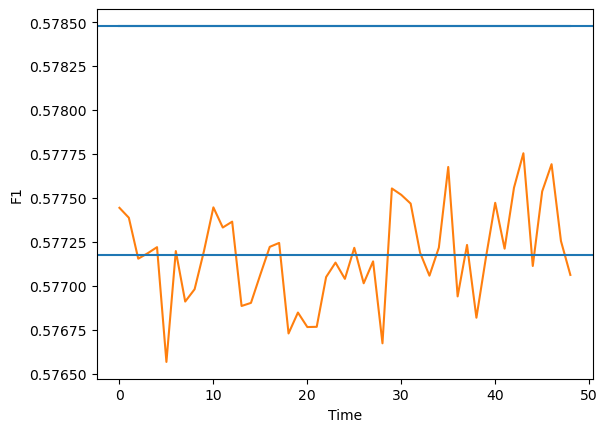

In [ ]:
f1_test = f1_score_dnri_((edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))
f1_test_mean = np.mean(f1_test)
plt.plot(f1_test, label='test edges');plt.axhline(f1_test_mean);

f1_test_false = f1_score_dnri_((edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy(),
                   edges_true[:,1:].transpose(1,2))
f1_test_false_mean = np.mean(f1_test_false)
plt.plot(f1_test_false, label='test edges-false edges');plt.axhline(f1_test_false_mean);
plt.gca().set( xlabel='Time', ylabel='F1');
plt.legend();

In [ ]:
cm = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  normalize='true'
                 )

cm_ = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  edges[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  #normalize='true'
                 )

In [ ]:
with np.printoptions(precision=3, suppress=True):
    print(cm)
    print(cm_)

[[0.543 0.457]
 [0.385 0.615]]
[[2659230 2239790]
 [1885667 3015313]]


In [ ]:
cm = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  (edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  normalize='true'
                 )

cm_ = confusion_matrix(edges_true[:,1:].transpose(1,2).reshape(-1),
                  (edges+false_edges)[...,edges_order].argmax(-1).cpu().numpy().reshape(-1),
                  #normalize='true'
                 )

In [ ]:
with np.printoptions(precision=3, suppress=True):
    print(cm)
    print(cm_)

[[0.551 0.449]
 [0.396 0.604]]
[[2698741 2200279]
 [1940457 2960523]]


### Edge visual structure

In [ ]:
edges_ = edges + false_edges

In [ ]:
# predicted edges, true
edges_b.shape, edges_pred.shape, edges_true.shape, edges_true_.shape

(torch.Size([10000, 20, 49, 2]),
 torch.Size([10000, 49, 20]),
 torch.Size([10000, 50, 20]),
 torch.Size([10000, 49, 20]))

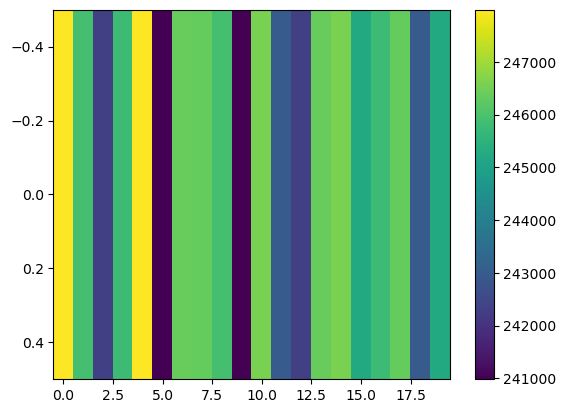

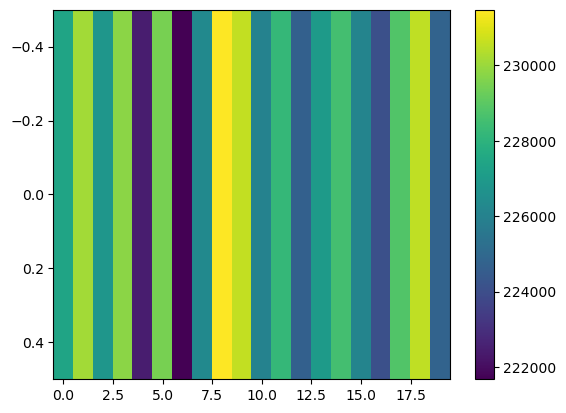

In [ ]:
h = plt.imshow((edges_true[:,1:].to(bool).numpy().reshape(-1,edges_true.shape[-1])==True).sum(0)[None], aspect='auto', interpolation='none');
cbar = plt.colorbar(h)
plt.figure();
h=plt.imshow((torch.argmax(edges_b,dim=-1).long().transpose(1,-1).cpu().numpy().reshape(-1,edges_b.shape[1])!=0).sum(0)[None], aspect='auto', cmap=cbar.cmap);
cbar = plt.colorbar(h)

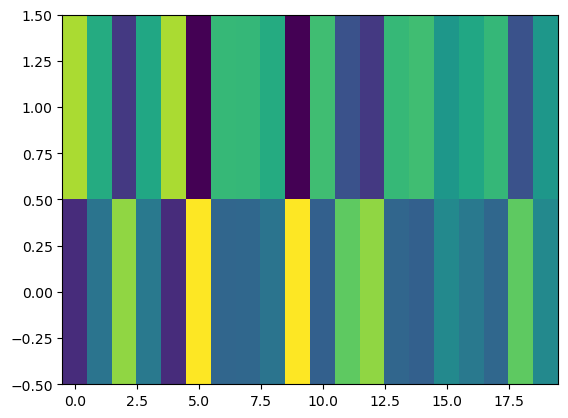

In [ ]:
plt.imshow(get_edges_count_table(edges_true_, dim=2),origin='lower', aspect='auto', interpolation='none');

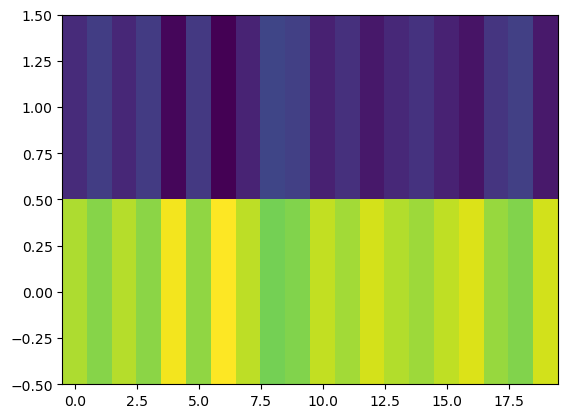

In [ ]:
plt.imshow(get_edges_count_table(edges_pred, dim=2),origin='lower', aspect='auto', interpolation='none');

In [ ]:
edges_pred.shape

torch.Size([10000, 49, 20])

In [ ]:
edges_pred[0,0].shape, row_idx.shape, col_idx.shape

(torch.Size([20]), (20,), (20,))

In [ ]:
N

5

In [ ]:
params['data_path']

'../data/raw/synth_charged_5_10k/'

In [ ]:
# np.savez_compressed("draft/synth3_21_edge_structure",
#                     N=N,
#                     edges_pred=edges_pred.numpy(),
#                     row_idx=row_idx, col_idx=col_idx
#                    )

In [ ]:
# adjacency_types = np.zeros((N,N))
# adjacency_types[row_idx, col_idx] = edges_pred[0,0].numpy()

In [ ]:
# def plot_adjacency_matrix(adjacency_types):
#     plt.imshow(adjacency_types, cmap='Blues', norm='symlog',
#                # to have white zero? TODO linear segmented cmaps with blues
#            aspect='equal', interpolation='none', );#extent=(1,N,N,1));
#     cbar = plt.colorbar(label='Edge count', pad=0.01); #cbar.set_tick_params(direction='in',);
#     plt.ylabel('Sending Node');plt.xlabel('Receiving Node');
#     plt.locator_params(nbins=3); plt.tick_params(direction='in', left=False, bottom=False);
#     plt.xticks(np.array([0,6,13,20]), ['1','7','14','21'])
#     plt.yticks(np.array([0,6,13,20]), ['1','7','14','21'])

In [ ]:
# adjacency_types = np.zeros((N,N))
# adjacency_types[row_idx, col_idx] = F.one_hot(edges_pred[0,0], num_classes=3)[:,2].numpy()

In [ ]:
# plot_adjacency_matrix(adjacency_types)

In [ ]:
# adjacency_types = np.zeros((N,N))
# adjacency_types[row_idx, col_idx] = edges_pred[0].sum((0)).numpy()

In [ ]:
# plot_adjacency_matrix(adjacency_types)

In [ ]:
# plt.imshow(adjacency_types, cmap='Blues', norm='log',vmin=.9);plt.colorbar();

In [ ]:
# adjacency_types = np.zeros((N,N))
# adjacency_types[row_idx, col_idx] = edges_pred.sum((0,1)).numpy()

In [ ]:
# plot_adjacency_matrix(adjacency_types)

### Edges predictions in time

In [ ]:
edges_prior  = prior_logits.cpu().detach()
edges_logits = posterior_logits.cpu().detach()

In [ ]:
edges_prior_b, mask = to_dense_batch(edges_prior,edge_feats_batch.cpu())
edges_logits_b, mask = to_dense_batch(edges_logits,edge_feats_batch.cpu())

In [ ]:
edges_prior_b = edges_prior_b.transpose(1,2)
edges_logits_b = edges_logits_b.transpose(1,2)

In [ ]:
edges_prior.shape, edges_prior_b.shape, edges_logits.shape, edges_logits_b.shape

(torch.Size([200000, 49, 2]),
 torch.Size([10000, 49, 20, 2]),
 torch.Size([200000, 49, 2]),
 torch.Size([10000, 49, 20, 2]))

In [ ]:
import numpy as np
ep = np.argmax(edges_prior_b.numpy()[...,edges_order], axis=-1)
ec = np.argmax(edges_logits_b.numpy()[...,edges_order], axis=-1)

In [ ]:
el = np.argmax(torch.nn.functional.gumbel_softmax(edges_logits_b, tau=model.gumbel_temp/2, hard=False,).cpu().numpy()[...,edges_order], axis=-1)

In [ ]:
edges_t = edges_true_.numpy()

In [ ]:
edges_t.shape, ep.shape, ec.shape, el.shape

((10000, 49, 20), (10000, 49, 20), (10000, 49, 20), (10000, 49, 20))

In [ ]:
edges_b.shape

torch.Size([10000, 20, 49, 2])

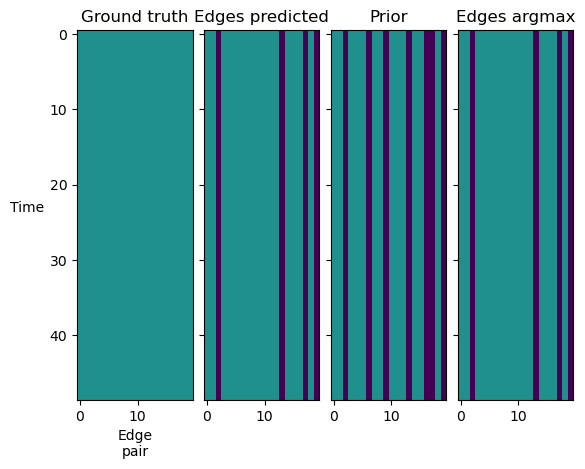

In [ ]:
i=2 # timeseries sample
fig, axs = plt.subplots(1,4, sharey=True, gridspec_kw=dict(wspace=0.1))
for ax, x, t in zip(axs,[edges_t[i], edges_b[i,...,edges_order].argmax(-1).T.cpu(), ep[i],ec[i]],
                        ['Ground truth',  'Edges predicted','Prior', 'Edges argmax']):
    ax.imshow(x,aspect='auto', vmin=0,vmax=2, interpolation='none');  ax.set_title(t);

axs[0].set_ylabel('Time', rotation=0, ha='right'); axs[0].set_xlabel('Edge\npair');

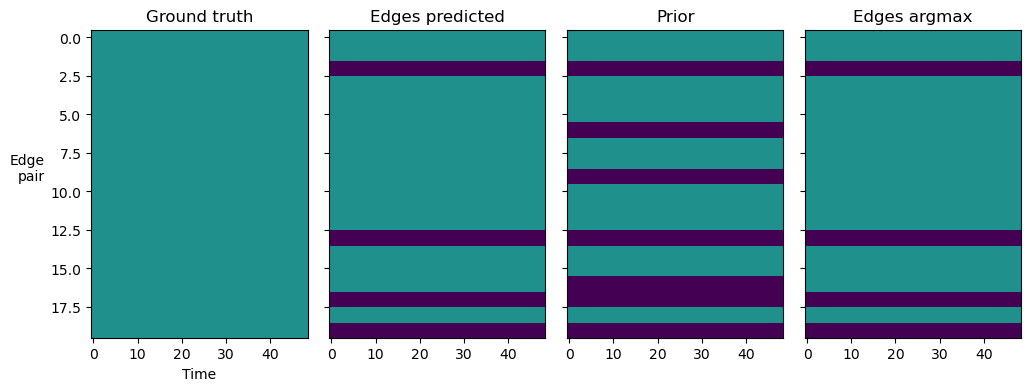

In [ ]:
i=2 # timeseries sample
fig, axs = plt.subplots(1,4, sharey=True,figsize=(12,4), gridspec_kw=dict(wspace=0.1))
for ax, x, t in zip(axs,[edges_t[i].T, edges_b[i,...,edges_order].argmax(-1).cpu(), ep[i].T,ec[i].T],
                        ['Ground truth',  'Edges predicted','Prior', 'Edges argmax']):
    ax.imshow(x,aspect='auto', vmin=0,vmax=2, interpolation='none');  ax.set_title(t);

axs[0].set_xlabel('Time'); axs[0].set_ylabel('Edge\npair', rotation=0, ha='right');

### Posterior Logits vs distance

In [ ]:
model.use_supergaussian

False

In [ ]:
posterior_logits.max(), posterior_logits.min()

(tensor(19.5836, device='cuda:0'), tensor(-27.7245, device='cuda:0'))

In [ ]:
all_posterior_logits.shape

torch.Size([200000, 49, 2])

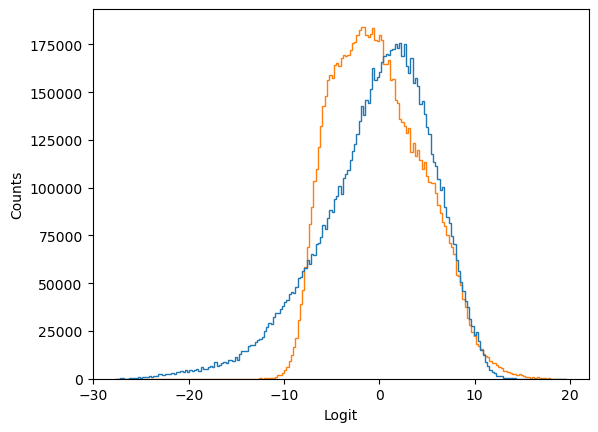

In [ ]:
plt.hist(all_posterior_logits.reshape(-1, all_posterior_logits.shape[-1]).cpu().numpy(), 200,histtype='step');
plt.gca().set( xlabel='Logit', ylabel='Counts');

In [ ]:
edge_feats[:,:,:-1,0].shape,all_posterior_logits[...,0].shape

(torch.Size([10000, 20, 49]), torch.Size([200000, 49]))

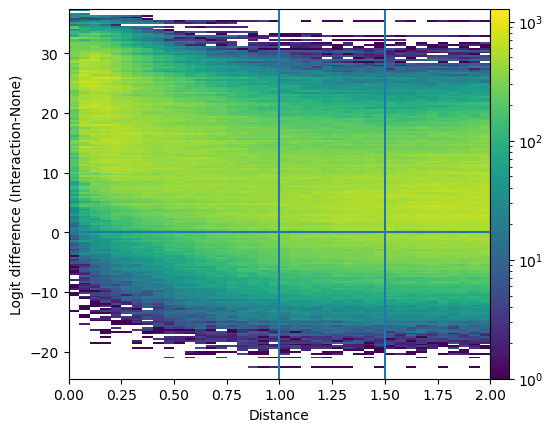

In [ ]:
plt.hist2d(norm*edge_feats[:,:,:-1,0].reshape(-1).cpu().numpy(),
           all_posterior_logits[...,1].reshape(-1).cpu().numpy()
           -all_posterior_logits[...,0].reshape(-1).cpu().numpy(),
           200,range=[[0,10],None], norm="log",);
plt.colorbar(pad=0);plt.axvline(1);plt.axvline(1.5);plt.axhline(0);
if model.use_supergaussian:
    sigma = model.super_gaussians._parameters['sigma'][0].detach().cpu()
    print(f'{sigma=:.3g}')
    beta  = model.super_gaussians._parameters['beta'][0].detach().cpu()
    x= torch.linspace(0,10,200)/norm
    plt.plot(x*norm,
             10*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)),
            c='C1');
plt.xlabel('Distance');plt.ylabel('Logit difference (Interaction-None)');
plt.xlim(0,2);

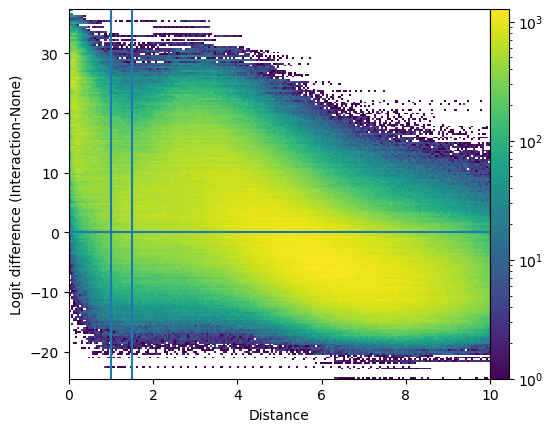

In [ ]:
plt.hist2d(norm*edge_feats[:,:,:-1,0].reshape(-1).cpu().numpy(),
           all_posterior_logits[...,1].reshape(-1).cpu().numpy()
           -all_posterior_logits[...,0].reshape(-1).cpu().numpy(),
           200,range=[[0,10],None], norm="log",);
plt.colorbar(pad=0);plt.axvline(1);plt.axvline(1.5);plt.axhline(0);
if model.use_supergaussian:
    sigma = model.super_gaussians._parameters['sigma'][0].detach().cpu()
    print(f'{sigma=:.3g}')
    beta  = model.super_gaussians._parameters['beta'][0].detach().cpu()
    x= torch.linspace(0,10,200)/norm
    plt.plot(x*norm,
             10*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)),
            c='C1');
plt.xlabel('Distance');plt.ylabel('Logit difference (Interaction-None)');
# plt.xlim(0,2);

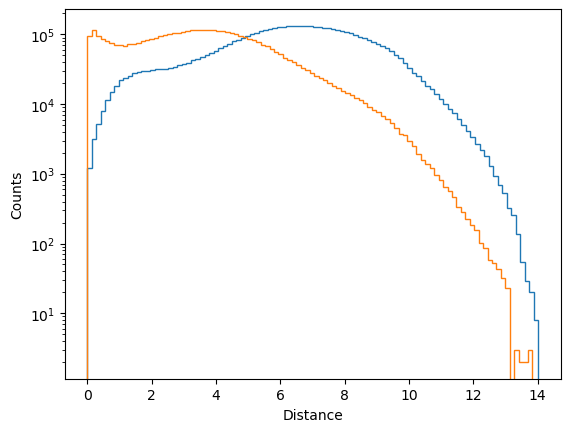

In [ ]:
for i in range(all_posterior_logits.shape[-1]):
    plt.hist(ds_train.norm*edge_feats[:,:,:-1,0].reshape(-1)[(all_posterior_logits.argmax(-1)==i).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
if model.use_supergaussian:
    with torch.inference_mode():
        x = torch.linspace(0,6,1000)/ds_train.norm
        for sigma, beta in zip(model.super_gaussians._parameters['sigma'].cpu(),
                               model.super_gaussians._parameters['beta'].cpu()):
            plt.plot(x*ds_train.norm,1e6*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)));
        plt.yscale('symlog');
plt.gca().set( xlabel='Distance', ylabel='Counts');
torch.cuda.empty_cache()

### Edges predictions vs distance

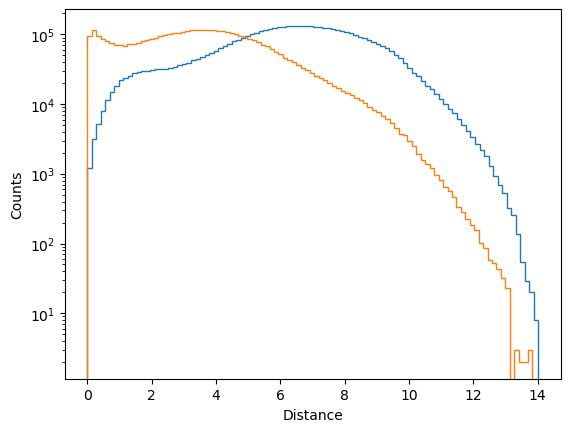

In [ ]:
for i in range(3):
    plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(edges_pred.transpose(2,1)==i).reshape(-1)].cpu().numpy(),100,log=True, histtype='step');
plt.gca().set( xlabel='Distance', ylabel='Counts');
torch.cuda.empty_cache()

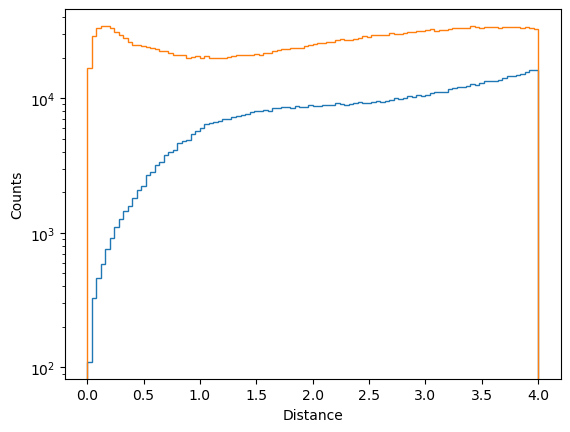

In [ ]:
for i in range(3):
    plt.hist(norm*edge_feats[:,:,:-1,0].reshape(-1)[(edges_pred.transpose(2,1)==i).reshape(-1)].cpu().numpy(),
             100,range=[0,4],log=True, histtype='step');
plt.gca().set( xlabel='Distance', ylabel='Counts');
torch.cuda.empty_cache()

In [ ]:
edges_pred.shape, edge_feats.shape, edges_true_.shape

(torch.Size([10000, 49, 20]),
 torch.Size([10000, 20, 50, 3]),
 torch.Size([10000, 49, 20]))

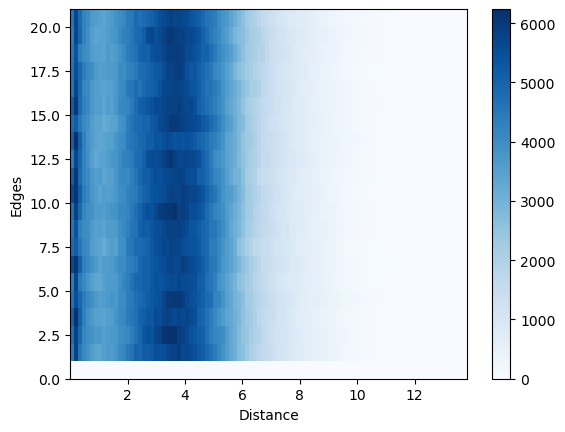

In [ ]:
edges_bins = np.arange(edges_pred.shape[-1]+2)
mask_i  = (edges_pred.transpose(2,1)==1).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = (np.arange(edges_pred.shape[-1])+1)[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[100,edges_bins],cmap='Blues');
bins_d = h[1]
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');

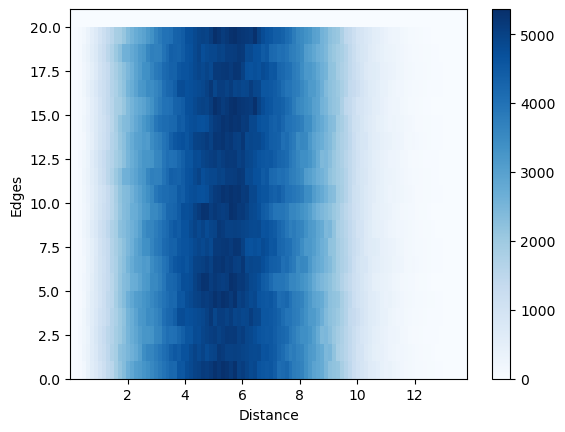

In [ ]:
mask_i  = (edges_true_.transpose(2,1)==1).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[bins_d,edges_bins],cmap='Blues');
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');

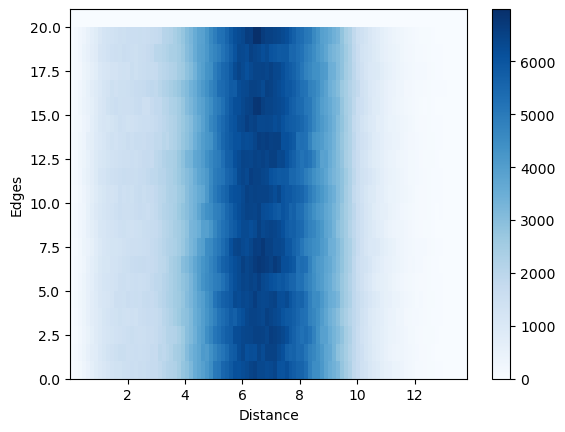

In [ ]:
mask_i  = (edges_pred.transpose(2,1)==0).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[bins_d,edges_bins],cmap='Blues');
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');
torch.cuda.empty_cache()

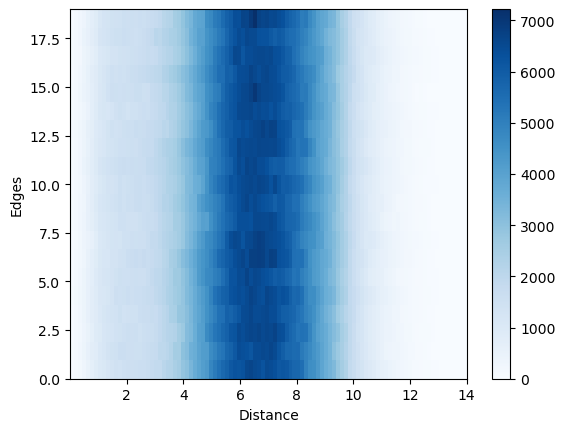

In [ ]:
mask_i  = (edges_pred.transpose(2,1)==0).reshape(-1)
x = norm*edge_feats[:,:,:-1,0].reshape(-1)[mask_i].cpu().numpy()
y = np.arange(edges_pred.shape[-1])[None,:,None].repeat(edges_pred.shape[0], axis=0).repeat(edges_pred.shape[1],axis=-1).reshape(-1)
y = y[mask_i]
h = plt.hist2d(x,y,bins=[100,edges_pred.shape[-1]],cmap='Blues');
plt.colorbar()
plt.gca().set( xlabel='Distance', ylabel='Edges');
torch.cuda.empty_cache()

# 3 Extraction of forces

## Active force

In [ ]:
def active_force(self, n_points=50):
    self.eval()
    dvc = next(self.parameters()).device
    with torch.no_grad():
        ori = torch.linspace(0.,2*3.14159,n_points,device=dvc)[:,None]
        versor = torch.cat([torch.cos(ori),torch.sin(ori),],dim=-1)[:,None]
        node_feats = torch.linspace(0.,0.5,n_points,device=dvc)[None,:,None]*versor
        agg_msg_zero = torch.zeros(n_points,n_points,2,device=dvc)
        aug_inputs = torch.cat([node_feats, agg_msg_zero], dim=-1) # B*N,F+O

        # NODE FUNCTION--------------------------------
        pred_x = self.decoder.node_function_x(aug_inputs)   # B*N,O
        pred_v = self.decoder.node_function_v(node_feats)
        pred = torch.cat([pred_x,pred_v],dim=-1).cpu().numpy()
        return ori.cpu().numpy(), pred, node_feats.cpu().numpy()

In [ ]:
ori, delta_active, velocities = active_force(model)

In [ ]:
ori.shape, delta_active.shape, velocities.shape

((50, 1), (50, 50, 4), (50, 50, 2))

The input to the node function are velocities and zeros.
The first output are deltas of position scaled by delta of time that take a very similar shape to input velocities. The other output are deltas of velocity and are mostly zero. Hence, there is no active force.

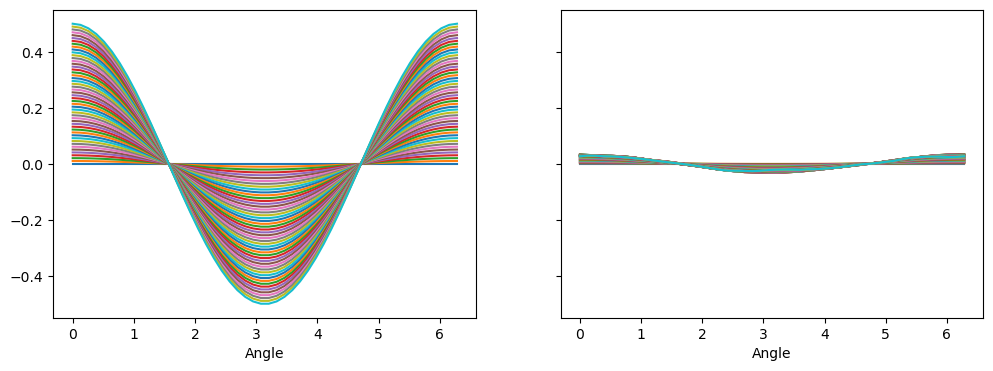

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True);
axs[0].plot(ori,   velocities[:,:,0]); # velx
axs[1].plot(ori, delta_active[:,:,0]); # dx
for ax in axs: ax.set(xlabel='Angle',);

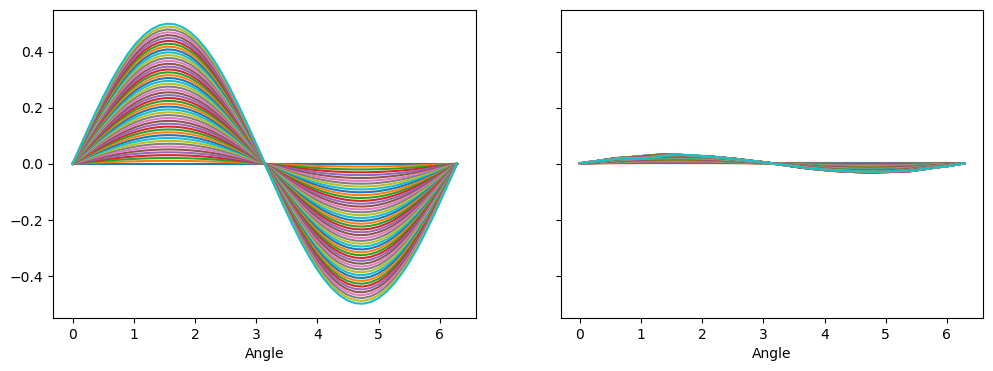

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True);
axs[0].plot(ori, velocities[:,:,1]); # vely
axs[1].plot(ori,delta_active[:,:,1]); # dy
for ax in axs: ax.set(xlabel='Angle',);

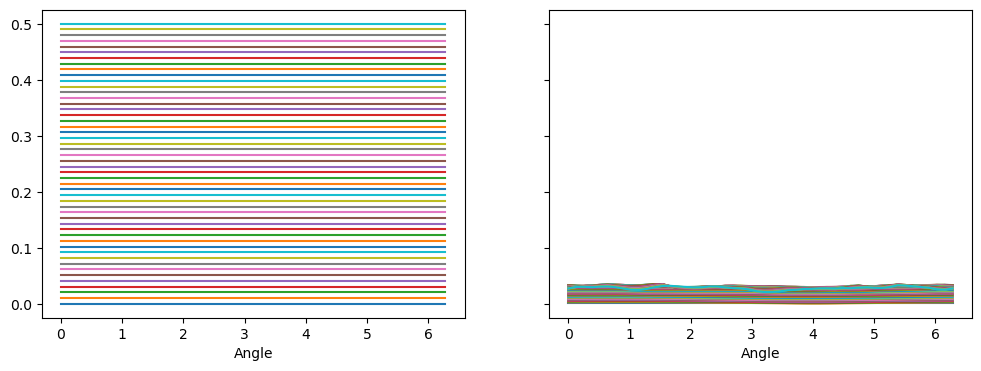

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharey=True);
axs[0].plot(ori, np.hypot(velocities[:,:,0],velocities[:,:,1])); # velx
axs[1].plot(ori, np.hypot(delta_active[:,:,0],delta_active[:,:,1])); # dx
for ax in axs: ax.set(xlabel='Angle',);

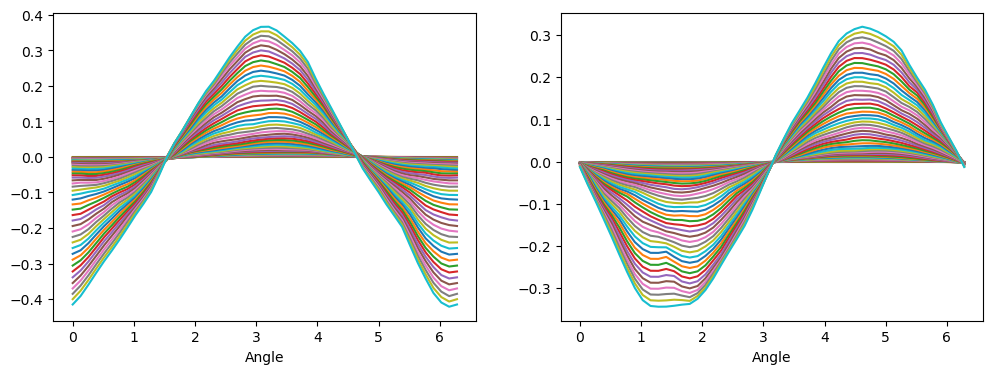

In [ ]:
# dv
fig, axs = plt.subplots(1,2, figsize=(12,4));
axs[0].plot(ori,delta_active[:,:,2]); axs[1].plot(ori,delta_active[:,:,3]);
for ax in axs: ax.set(xlabel='Angle',);

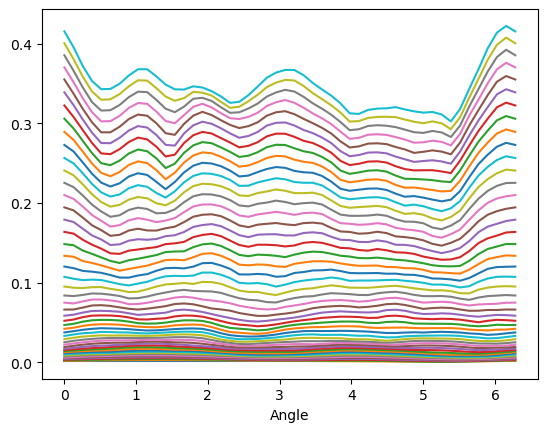

In [ ]:
# dv
plt.plot(ori,np.hypot(delta_active[:,:,2],delta_active[:,:,3]));
plt.gca().set( xlabel='Angle',);

## Force from the edge function

As we devised the decoder with the priors of single magnitude by distance versor (getting radial symmetry) and explicit addition of the message to the node function, the messages already correspond to the forces.

In [ ]:
norm = params['norms']['norm']
norm_v = params['norms']['norm_v']

In [ ]:
delta_t = ds_train.delta_t

In [ ]:
d_max = 10; n_points = 100
with torch.no_grad():
    dvc = next(model.parameters()).device
    distance = torch.linspace(0.01,d_max, n_points, device=dvc)[None,:, None] # 1, n_points, 1
    d = distance/norm
    msg1 = model.decoder.edge_functions[0](d)*norm_v/delta_t
    msg2 = model.decoder.edge_functions[1](d)*norm_v/delta_t

In [ ]:
d_=np.linspace(0.01,d_max,n_points)
dv_theo1 = np.minimum(100,1/d_**2)

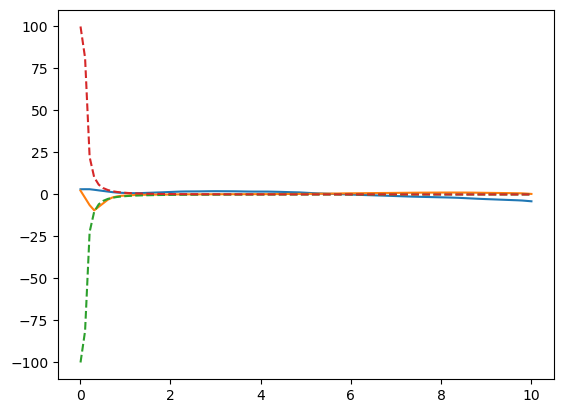

In [ ]:
plt.plot(distance.squeeze().cpu().numpy(),msg1.squeeze().cpu().numpy());
plt.plot(distance.squeeze().cpu().numpy(),msg2.squeeze().cpu().numpy());
plt.plot(d_,-dv_theo1, '--', label='Attractive');
plt.plot(d_,dv_theo1, '--',label='Repulsive');
if model.use_supergaussian:
    max_val = max(torch.max(msg1), torch.max(msg2)).cpu()
    x= (torch.linspace(0,10,200)/norm).cpu()
    sigma = model.super_gaussians._parameters['sigma'][0].detach().cpu()
    beta  = model.super_gaussians._parameters['beta'][0].detach().cpu()
    print(f'{sigma=:.3g}')
    plt.plot(x*norm.cpu().numpy(),
             max_val*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)),);
    sigma = model.super_gaussians._parameters['sigma'][1].detach().cpu()
    beta  = model.super_gaussians._parameters['beta'][1].detach().cpu()
    print(f'{sigma=:.3g}')
    plt.plot(x*norm,
             max_val*torch.exp(-1.*torch.pow(torch.square(x) / (2. * torch.square(sigma)), beta)),);

## Force magnitude from the messages

This is for the previous version. Currently, the linearity is imposed.

Interpreting the message components. As noted in ActiveNet, if the machine learns properly, the message that goes to the node function suffers a linear transformation to become a delta of velocity. Taking advantage of this, we fit the linear transformation and map the messages to forces.

In [ ]:
def interparticle_force_modulus(self, d_max=3, n_points=50, j=0, norm=None):
    assert j in [0,1]
    self.eval()
    with torch.no_grad():
        if norm is None:
            train_data = torch.load(os.path.join(params['data_path'], 'train_feats'))
            norm = 0.5*(train_data[:, :, :, :2].max()- train_data[:, :, :, :2].min()).abs() # 0.1
            print(norm)
        else:
            print('Using given Norm')
        aggregate_zero = torch.zeros(n_points,N,256)
        distance = torch.linspace(0.01,d_max, n_points)[None,:, None] # 1, n_points, 1
        d = distance/norm
        alphas = torch.linspace(0,2*3.14159,n_points) # distance versor angle wrt x axis
        ori = torch.linspace(0,2*np.pi,n_points+1,)[:-1,None]
        cos_ori = torch.cos(ori);    sin_ori = torch.sin(ori)
        versor = torch.cat([cos_ori,sin_ori,],dim=-1)[:,None] # n_points,1, 2
        F_inter  = torch.zeros(n_points,n_points, 1) # modulus of N particles at n distances and n alphas
        node_feats = torch.full((n_points,n_points,2),0.04)  # velocity
        edges_ = torch.ones(n_points,n_points,params['num_edge_types']); # n_points, C=3 edge_types

        # for edge_type...j
        norm_msg  = 1
        start_idx = 1 if model.decoder.skip_first_edge_type else 0
        msg = model.decoder.edge_functions[j](d)*versor # n_points, n_points, 2
        msg = msg*edges_[:,:,j+start_idx:j+start_idx+1]    # <-- Encoder z edges predictions
        msg = msg/norm_msg     # (B,E,O)

        agg_msg_zero = torch.zeros(n_points,n_points,2,device='cpu')
        aug_inputs_zero = torch.cat([node_feats, agg_msg_zero], dim=-1) # B*N,F+O

        # NODE FUNCTION--------------------------------
        pred_x_ = self.decoder.node_function_x(aug_inputs_zero)   # B*N,O
        pred_v_ = self.decoder.node_function_v(node_feats)
        F_active = torch.cat([pred_x_,pred_v_],dim=-1)#.cpu().numpy()

        aug_inputs = torch.cat([node_feats, msg], dim=-1) # B*N,F+O

        # NODE FUNCTION--------------------------------
        pred_x = self.decoder.node_function_x(aug_inputs)   # B*N,O
        pred_v = self.decoder.node_function_v(node_feats) + msg
        deltas = torch.cat([pred_x,pred_v],dim=-1)#.cpu().numpy()

        F_inter = torch.hypot(deltas[...,-1]- F_active[...,-1],
                              deltas[...,-2]- F_active[...,-2])
        assert torch.all(torch.isfinite(F_inter))
    return distance.squeeze(), F_inter.detach().numpy(), deltas, ori, node_feats, msg

In [ ]:
dist, f, deltas_a, alphas, node_feats, msg = interparticle_force_modulus(model.cpu(),n_points=300,d_max=4, j=0, norm=params['norms']['norm'])

Using given Norm


In [ ]:
dist, f2, deltas_a2, alphas, node_feats, msg2 = interparticle_force_modulus(model.cpu(),n_points=300,d_max=4, j=1, norm=params['norms']['norm'])

Using given Norm


In [ ]:
norm = params['norms']['norm'].cpu().numpy()
norm_v = params['norms']['norm_v'].cpu().numpy()

In [ ]:
delta_t = ds_train.delta_t

/tmp/ipykernel_896531/154290628.py:2: RuntimeWarning: divide by zero encountered in divide
  dv_theo1 = np.minimum(100,1/d_**2)


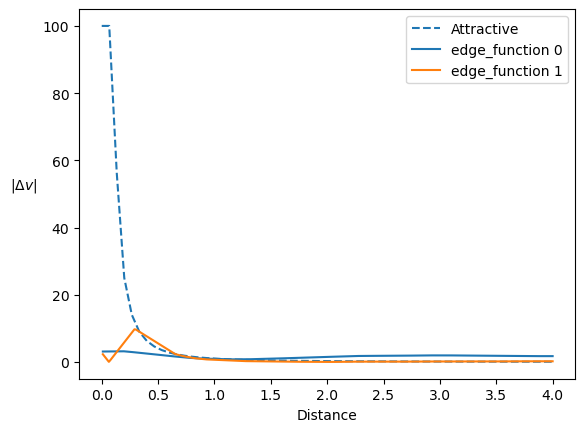

In [ ]:
d_=np.linspace(0,dist.max(),61)
dv_theo1 = np.minimum(100,1/d_**2)
plt.plot(d_,dv_theo1, '--', label='Attractive');
plt.plot(dist,f.mean(0)*norm_v/delta_t, c=f'C0', label=f'edge_function 0');
plt.plot(dist,f2.mean(0)*norm_v/delta_t, c=f'C1', label=f'edge_function 1');
plt.xlabel('Distance'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');
plt.legend(ncol=1);

/tmp/ipykernel_896531/154290628.py:2: RuntimeWarning: divide by zero encountered in divide
  dv_theo1 = np.minimum(100,1/d_**2)


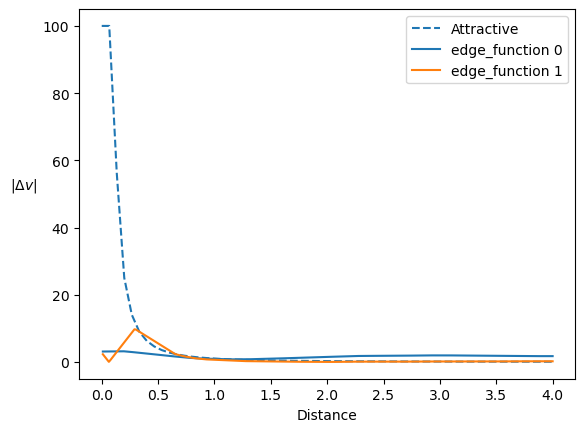

In [ ]:
d_=np.linspace(0,dist.max(),61)
dv_theo1 = np.minimum(100,1/d_**2)
plt.plot(d_,dv_theo1, '--', label='Attractive');
plt.plot(dist,f.mean(0)*norm_v/delta_t, c=f'C0', label=f'edge_function 0');
plt.plot(dist,f2.mean(0)*norm_v/delta_t, c=f'C1', label=f'edge_function 1');
plt.xlabel('Distance'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');
plt.legend(ncol=1);

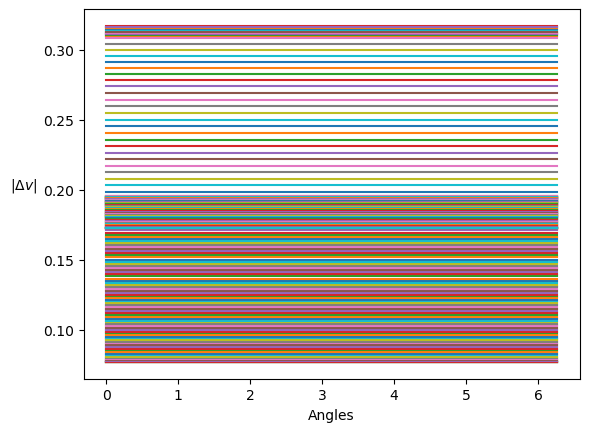

In [ ]:
plt.plot(alphas,f*norm_v);plt.xlabel('Angles'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');

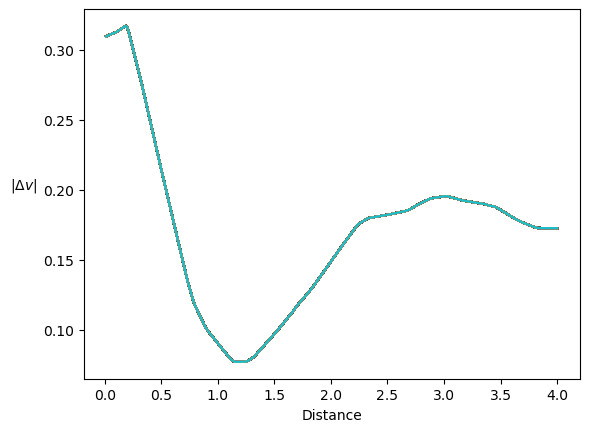

In [ ]:
plt.plot(dist,f.T*norm_v);plt.xlabel('Distance'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');

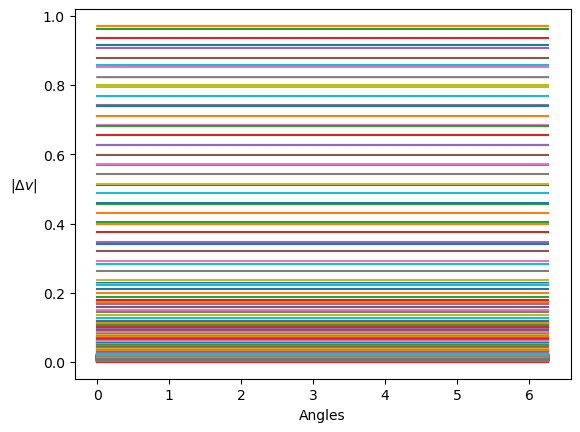

In [ ]:
plt.plot(alphas,f2*norm_v);plt.xlabel('Angles'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');

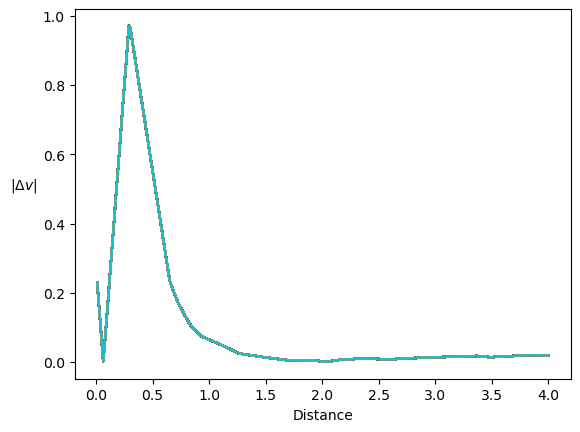

In [ ]:
plt.plot(dist,f2.T*norm_v);plt.xlabel('Distance'); plt.ylabel(r'$|\Delta v|$', rotation=0, ha='right');

## Message linear transformation

In [ ]:
msg.shape, deltas_a.shape

(torch.Size([300, 300, 2]), torch.Size([300, 300, 4]))

In [ ]:
# Define the two sets of 2D points
X = msg.reshape(-1,2)
Y = deltas_a[...,2:].reshape(-1,2)

# Add a column of ones to X for the bias term
X_homogeneous = np.hstack((X, np.ones((X.shape[0], 1))))

# Compute the linear transformation using least squares
A, residuals, rank, s = np.linalg.lstsq(X_homogeneous, Y, rcond=None)

# Print the linear transformation matrix
print(A)

# Apply the linear transformation to X
transformed_X = np.dot(X_homogeneous, A)

[[ 1.00000000e+00 -2.62519566e-11]
 [ 2.61075653e-12  1.00000000e+00]
 [-4.95930761e-03 -5.89593500e-03]]


In [ ]:
r2 = 1 - residuals / (Y.numpy().size * Y.var().numpy());r2

array([1., 1.])

In [ ]:
transformed_X.shape

(90000, 2)

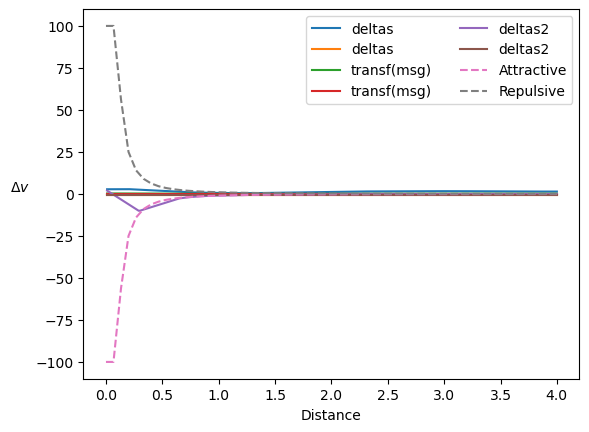

In [ ]:
plt.plot(dist,deltas_a[0,:,2:]*norm_v/delta_t, label='deltas');
plt.plot(dist,transformed_X.reshape(300,300,2)[0]*norm_v, label='transf(msg)');
plt.plot(dist,deltas_a2[0,:,2:]*norm_v/delta_t, label='deltas2');
plt.plot(d_,-dv_theo1, '--', label='Attractive');
plt.plot(d_,dv_theo1, '--',label='Repulsive');
plt.legend(ncol=2);plt.xlabel('Distance'); plt.ylabel(r'$\Delta v$', rotation=0, ha='right');

In [ ]:
# Define the two sets of 2D points
X2 = msg2.reshape(-1,2)
Y2 = deltas_a2[...,2:].reshape(-1,2)

# Add a column of ones to X for the bias term
X_homogeneous2 = np.hstack((X2, np.ones((X2.shape[0], 1))))

# Compute the linear transformation using least squares
A2, residuals, rank, s = np.linalg.lstsq(X_homogeneous2, Y2, rcond=None)

# Print the linear transformation matrix
print(A2)

# Apply the linear transformation to X
transformed_X2 = np.dot(X_homogeneous2, A2)

[[ 1.00000000e+00  1.14179534e-11]
 [-8.26970203e-12  9.99999999e-01]
 [-4.95930760e-03 -5.89593499e-03]]


In [ ]:
r2 = 1 - residuals / (Y2.numpy().size * Y2.var().numpy());r2

array([1., 1.])

In [ ]:
A_ = [A,A2]

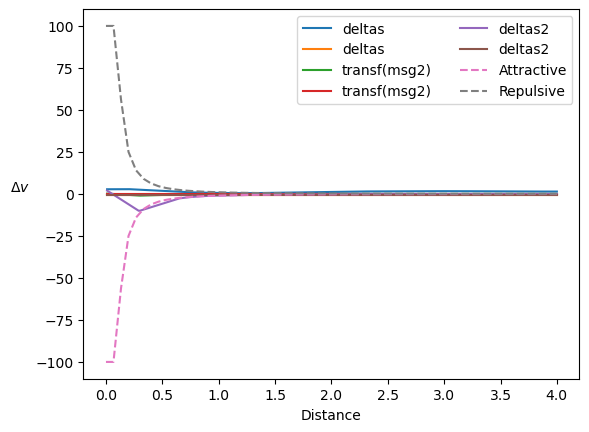

In [ ]:
plt.plot(dist,deltas_a[0,:,2:]*norm_v/delta_t, label='deltas');
plt.plot(dist,transformed_X2.reshape(300,300,2)[0]*norm_v, label='transf(msg2)');
plt.plot(dist,deltas_a2[0,:,2:]*norm_v/delta_t, label='deltas2');
plt.plot(d_,-dv_theo1, '--', label='Attractive');
plt.plot(d_,dv_theo1, '--',label='Repulsive');
plt.legend(ncol=2);plt.xlabel('Distance'); plt.ylabel(r'$\Delta v$', rotation=0, ha='right');

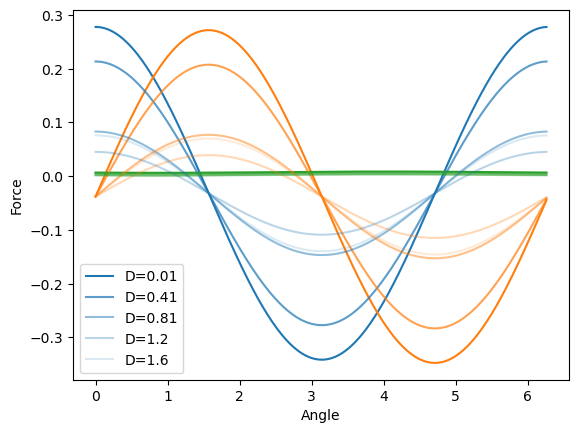

In [ ]:
for i in range(0,130,30):
    plt.plot(alphas,deltas_a[:,i,2]*norm_v, c=f'C{i}', alpha=((200-i)/200)**2, label=f'D={dist[i]:.2g}');
    plt.plot(alphas,deltas_a[:,i,3]*norm_v, c=f'C{i+1}', alpha=((200-i)/200)**2);
    plt.plot(alphas,((deltas_a[:,i,2:])**2).sum(-1).sqrt()/norm_v, c=f'C{i+2}', alpha=((200-i)/200)**2);
plt.legend();plt.xlabel('Angle'); plt.ylabel('Force');

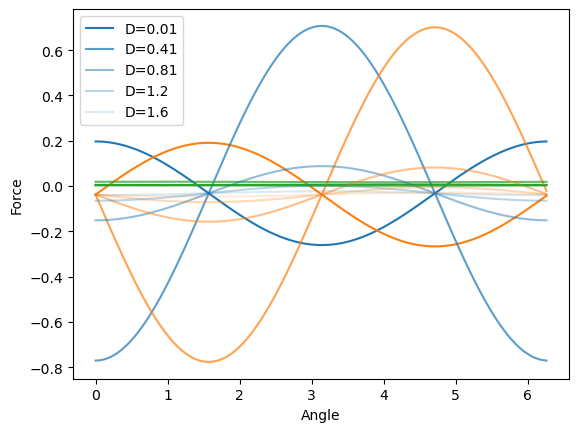

In [ ]:
for i in range(0,130,30):
    plt.plot(alphas,deltas_a2[:,i,2]*norm_v, c=f'C{i}', alpha=((200-i)/200)**2, label=f'D={dist[i]:.2g}');
    plt.plot(alphas,deltas_a2[:,i,3]*norm_v, c=f'C{i+1}', alpha=((200-i)/200)**2);
    plt.plot(alphas,((deltas_a2[:,i,2:])**2).sum(-1).sqrt()/norm_v, c=f'C{i+2}', alpha=((200-i)/200)**2);
plt.legend();plt.xlabel('Angle'); plt.ylabel('Force');

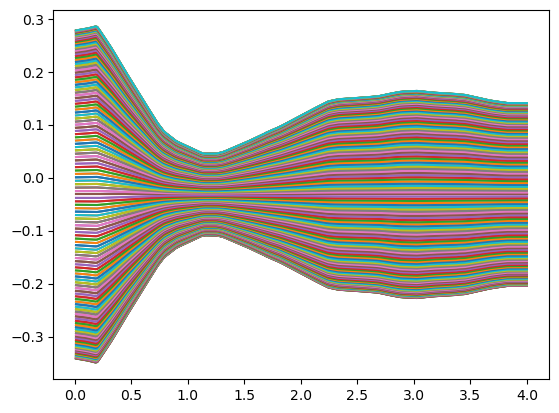

In [ ]:
plt.plot(dist,transformed_X.reshape(300,300,2)[:,:,0].T*norm_v);

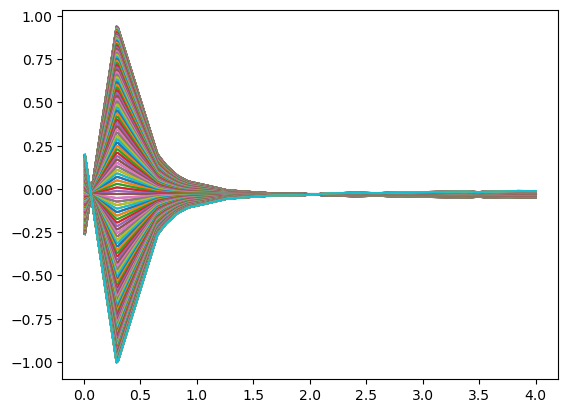

In [ ]:
plt.plot(dist,deltas_a2[:,:,2].T*norm_v);

The force magnitude has no dependency of the angle.

## Force functional form from test samples messages

for all test inputs:
put msg homogenous to np.dot with A and A2.
Then, multiply by edge prediction.

In [ ]:
edge_feats_test_ = edge_feats_test.transpose(1,2)[:, :-1]

In [ ]:
node_feats_test_ = node_feats_test[:,:,1:].transpose(1,2)

In [ ]:
params['data_path']

'../data/raw/synth_charged_5_10k/'

In [ ]:
test_data = SmallSynthDataPyG(params['data_path'], 'test', params, max_samples=20000)
edges_true = test_data.edges
edge_feats_batch = Batch.from_data_list(test_data.datalist,follow_batch=['edge_feats']).edge_feats_batch
edges_b, mask = to_dense_batch(edges,edge_feats_batch)
edges_true_ = edges_true[:,:].long().cpu()
edges_pred  = edges_b.argmax(dim=-1).long().transpose(1,-1).cpu()

Using given norm


In [ ]:
edges.shape, edges_b.shape

(torch.Size([200000, 49, 2]), torch.Size([10000, 20, 49, 2]))

In [ ]:
edges_pred_onehot = F.one_hot(edges_pred)

In [ ]:
node_feats_test_.shape, edge_feats_test_.shape, edges_pred.shape, edges_pred_onehot.shape

(torch.Size([10000, 49, 5, 4]),
 torch.Size([10000, 49, 20, 3]),
 torch.Size([10000, 49, 20]),
 torch.Size([10000, 49, 20, 2]))

In [ ]:
edge_feats_test_.device, next(model.parameters()).device

(device(type='cuda', index=0), device(type='cpu'))

In [ ]:
edge_feats_test_ = edge_feats_test_.cpu()

In [ ]:
#  get messages from edge_feats_test
msg = [torch.zeros(*edge_feats_test_.shape[:-1],len(model.decoder.edge_functions)),
       torch.zeros(*edge_feats_test_.shape[:-1],len(model.decoder.edge_functions))]
msg_homo = [torch.zeros(np.prod(edge_feats_test_.shape[:-1]),len(model.decoder.edge_functions)+1),
            torch.zeros(np.prod(edge_feats_test_.shape[:-1]),len(model.decoder.edge_functions)+1)]
msg_transf =[0,0]
msg_f = [0,0]
with torch.no_grad():
    # msg_norm = 1
    for i in trange(len(model.decoder.edge_functions)):
        msg[i] = model.decoder.edge_functions[i](edge_feats_test_[...,0:1])*edge_feats_test_[...,1:]
        msg[i] = msg[i].reshape(-1,2)
        # Add a column of ones to X for the bias term
        msg_homo[i] = torch.hstack((msg[i], torch.ones((msg[i].shape[0], 1),device=msg[i].device)))
        # Apply the linear transformation to X
        msg_transf[i] = np.dot(msg_homo[i].detach().cpu(), A_[i]).reshape(*edge_feats_test_.shape[:-1],len(model.decoder.edge_functions))

        msg_f[i] = msg_transf[i]*edges_pred_onehot[...,i+1*params['skip_first'],None].numpy()
torch.cuda.empty_cache()

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
msg_f[0].shape, edge_feats_test_.shape, edges_pred.shape

((10000, 49, 20, 2),
 torch.Size([10000, 49, 20, 3]),
 torch.Size([10000, 49, 20]))

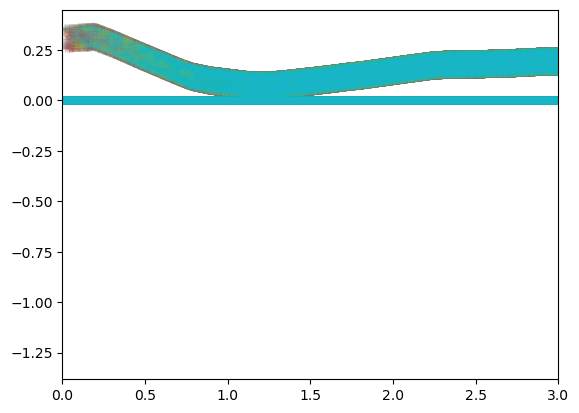

In [ ]:
for i in range(edge_feats_test_.shape[2]):
    # know the sign by the product of the force and the distance versors
    p  = msg_f[0][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
    # take the max to avoid floating point errors bw components
    ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)
    plt.plot(
         edge_feats_test_  [...,i,0:1].reshape(-1,1).cpu().numpy()*norm,
         ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v,
         '+',alpha=0.1,
        );
plt.xlim(0,3);

In [ ]:
# edges contributing to message_0
msg_f0_idx = np.unique(np.nonzero(msg_f[0]>0.01)[2]); msg_f0_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

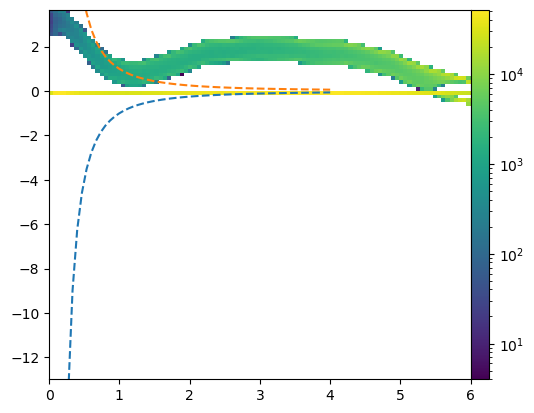

In [ ]:
i=msg_f0_idx #49
p  = msg_f[0][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)

plt.hist2d(
     edge_feats_test_  [...,i,0:1].reshape(-1).cpu().numpy()*norm,
     ps*np.hypot(*msg_f[0][:,:,i].reshape(-1,2).T)*norm_v/delta_t,
    100, range=[[0,6],None], norm='log',
    );
plt.plot(d_,-dv_theo1, '--', label='Attractive');
plt.plot(d_,dv_theo1, '--',label='Repulsive');
plt.colorbar(pad=0);

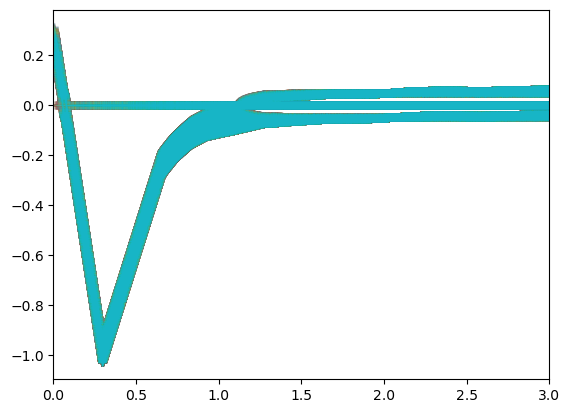

In [ ]:
# message*edge_pred
for i in range(edge_feats_test_.shape[2]): # edges
    p  = msg_f[1][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
    ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)

    plt.plot(
         edge_feats_test_  [...,i,0:1].reshape(-1,1).cpu().numpy()*norm,
         ps*np.hypot(*msg_f[1][:,:,i].reshape(-1,2).T)*norm_v,
          '+', alpha=0.1
        );
plt.xlim(0,3);

In [ ]:
# edges contributing to message_0
msg_f1_idx = np.unique(np.nonzero(msg_f[1]<-0.01)[2]); msg_f1_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

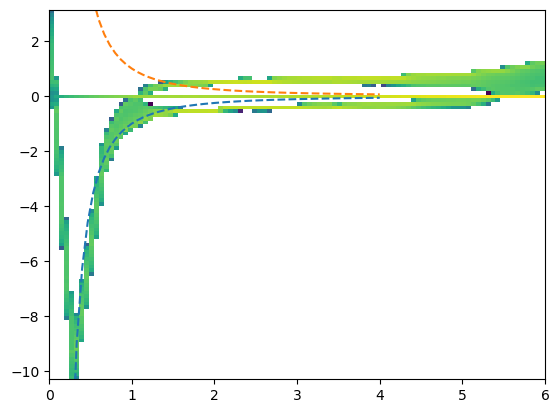

In [ ]:
i=msg_f1_idx
p  = msg_f[1][:,:,i]*edge_feats_test_[...,i,1:].cpu().numpy()
ps = np.take_along_axis(np.sign(p), np.argmax(np.abs(p), axis=-1,keepdims=True), axis=-1).reshape(-1)
plt.hist2d(
     edge_feats_test_  [...,i,0:1].reshape(-1).cpu().numpy()*norm,
     ps*np.hypot(*msg_f[1][:,:,i].reshape(-1,2).T)*norm_v/delta_t,
    100, range=[[0,6],None], norm='log'
    );
plt.plot(d_,-dv_theo1, '--', label='Attractive');
plt.plot(d_,dv_theo1, '--',label='Repulsive');

In [ ]:
torch.cuda.empty_cache()